In [2]:
import numpy as np
from timeit import default_timer as timer

from joblib import Parallel, delayed

import multiprocessing

num_cores = multiprocessing.cpu_count()

from functools import reduce

import pickle

import pandas as pd

import matplotlib.pyplot as plt


### Data downloading

In [14]:
D=np.load("X.npy") #IMG Data1

In [15]:
D.shape 

(1323, 85142)

In [16]:
from matplotlib.pyplot import pcolormesh

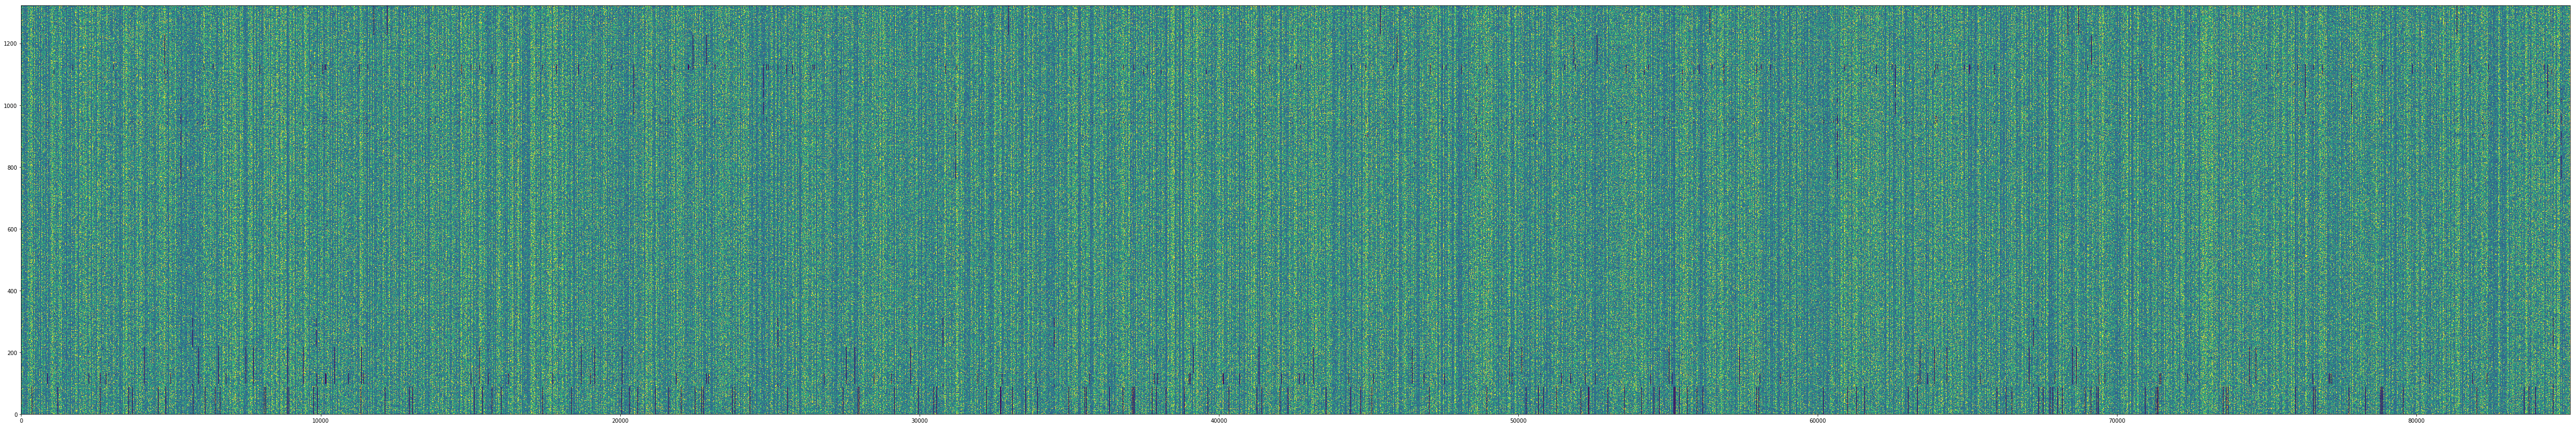

In [38]:
fig, ax = plt.subplots()

ax.pcolormesh(D)

fig.set_figwidth(85)    #  ширина и
fig.set_figheight(14)    #  высота "Figure"
#fig.set_facecolor('floralwhite')
#ax.set_facecolor('seashell')

plt.show()

In [39]:
 #pcolormesh(range(85142),range(1323),D)

In [40]:
plt.show()

In [4]:
print(D.dtype.names)


None


In [419]:
cnt=0

for r in range(D.shape[0]):
    for c in range(D.shape[1]):
        if D[r][c]==-1:
            cnt+=1
                
                
            
            
        

In [420]:
cnt

553430

### Sequential code for object-attribute bicluster generation

start = timer()

Objects={}
Attributes={}
idx=0

for r in range(D.shape[0]):
    Cols=[]
    for c in range(D.shape[1]):
        if D[r][c]==-1:
            Cols.append(c)
    #if r%1000==0: print(r)

    Objects[r]=Cols
    
end = timer()
print("Object primes", end - start) # Time in seconds, e.g. 5.38091952400282        

start = timer()

for c in range(D.shape[1]):
    Rows=[]
    for r in range(D.shape[0]):
        if D[r][c]==-1:
            Rows.append(r)
    #if c%1000==0: print(c)
            
    Attributes[c]=Rows
    
end = timer()
print("Attribute primes", end - start)

start = timer()
    
for r in range(D.shape[0]):
    for c in range(D.shape[1]):
        if D[r][c]==-1:
            if [Attributes[c],Objects[r]] not in B.values():
                B[(r,c)]=(Attributes[c], Objects[r])
                idx=idx+1
                #if idx%1000==0: print(idx)
            #B[(r,c)]=(Attributes[r], Objects[c])
            #idx=idx+1
            #if idx%1000==0: print(idx)

end = timer()
print("Pairing phase", end - start)       
   

### Parallel code for object-attribute bicluster generation

In [1]:
B={}
Objects={}
Attributes={}
idx=0



def objPrime(r,D):
    Cols=[]
    for c in range(D.shape[1]):
        if D[r][c]==-1:
            Cols.append(c)
    if r%1000==0: print(r)

    return Cols


       


#start = timer()            

    
def attrPrime(c,D):    
    Rows=[]
    for r in range(D.shape[0]):
        if D[r][c]==-1:
            Rows.append(r)
    if c%1000==0: print(c)
            
    return Rows




start = timer()

Objects = Parallel(n_jobs=num_cores)(delayed(objPrime)(r,D) for r in range(D.shape[0]))

end = timer()
print("Object primes", end - start) # Time in seconds, e.g. 5.38091952400282 

start = timer()    

#Objects = Parallel(n_jobs=num_cores/2)(delayed(objPrime)(r,D) for r in list(range(D.shape[0])))



Attributes = Parallel(n_jobs=num_cores)(delayed(attrPrime)(c,D) for c in range(D.shape[1]))

end = timer()
print("Attribute primes", end - start)

start = timer()

 
def biclGen(r,D,Objects,Attributes):
    idx=0
    B={}
    for c in range(D.shape[1]):
        if D[r][c]==-1:
            
             if [Attributes[c],Objects[r]] not in B.values():
                B[(r,c)]=[Attributes[c], Objects[r]]
                idx=idx+1
                if idx%1000==0: print(idx)
            #B[(r,c)]=(Attributes[r], Objects[c])
            #idx=idx+1
            #if idx%1000==0: print(idx)
    return B
            
                

    
Bicl = Parallel(n_jobs=num_cores)(delayed(biclGen)(r,D, Objects, Attributes) for r in range(D.shape[0]))


end = timer()
print("Pairing phase", end - start)    



NameError: name 'timer' is not defined

In [6]:
start = timer()

B = reduce((lambda x, y: {**x, **y}), Bicl)

end = timer()
print("Reduce", end - start)  

NameError: name 'Bicl' is not defined

In [4]:
len(Bicl)

NameError: name 'Bicl' is not defined

In [5]:
len(B)



NameError: name 'B' is not defined

In [8]:
def Density(D,b):
    num=0
    for i in b[0]:
        for j in b[1]:
            if D[i][j]==-1:
                num=num+1
    return num/(len(b[0])*len(b[1]))

In [9]:
Density(D,B[(0,0)])

0.9835927375215471

In [16]:
len(B)

383733

### Computation of basic statistics 

In [10]:
def biclDenLen(D,Bk,key):
    den={}
    den[key]=(Density(D,Bk), len(Bk[0]),len(Bk[1]))
    if key[0]%10==0: print(key)
    return den
           
keys=B.keys()

import os
from joblib import dump, load

folder = './joblib_memmap2'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

data_filename_memmap = os.path.join(folder, 'data_memmap')
dict_filename_memmap = os.path.join(folder, 'dict_memmap')

dump(D, data_filename_memmap)
dump(B, dict_filename_memmap)
D = load(data_filename_memmap, mmap_mode='r')
B = load(dict_filename_memmap, mmap_mode='r')
                
start = timer()
    
#Bdl = Parallel(n_jobs=num_cores, backend="threading", verbose=100, pre_dispatch="100*n_jobs", batch_size=100)(delayed(biclDenLen)(D,B[key],key) for key in keys)
Bdl = Parallel(n_jobs=num_cores, verbose=100, pre_dispatch="100*n_jobs", batch_size=100)(delayed(biclDenLen)(D,B[key],key) for key in keys)



end = timer()
print("Density calculation phase", end - start) 

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done 100 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 200 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 300 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 400 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 500 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 600 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 700 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 800 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 900 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 1000 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 1100 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 1200 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 1300 tasks      | elapsed:  5.4min
[Parallel(n_jobs=12)]: Done 1400 tasks      | elapsed:  5.6min
[Parallel(n_jobs=12)]: Done 1500 tasks      | elap

[Parallel(n_jobs=12)]: Done 13000 tasks      | elapsed: 33.0min
[Parallel(n_jobs=12)]: Done 13100 tasks      | elapsed: 33.1min
[Parallel(n_jobs=12)]: Done 13200 tasks      | elapsed: 33.1min
[Parallel(n_jobs=12)]: Done 13300 tasks      | elapsed: 34.9min
[Parallel(n_jobs=12)]: Done 13400 tasks      | elapsed: 35.3min
[Parallel(n_jobs=12)]: Done 13500 tasks      | elapsed: 35.3min
[Parallel(n_jobs=12)]: Done 13600 tasks      | elapsed: 35.4min
[Parallel(n_jobs=12)]: Done 13700 tasks      | elapsed: 35.6min
[Parallel(n_jobs=12)]: Done 13800 tasks      | elapsed: 35.7min
[Parallel(n_jobs=12)]: Done 13900 tasks      | elapsed: 35.8min
[Parallel(n_jobs=12)]: Done 14000 tasks      | elapsed: 35.8min
[Parallel(n_jobs=12)]: Done 14100 tasks      | elapsed: 35.9min
[Parallel(n_jobs=12)]: Done 14200 tasks      | elapsed: 36.0min
[Parallel(n_jobs=12)]: Done 14300 tasks      | elapsed: 36.0min
[Parallel(n_jobs=12)]: Done 14400 tasks      | elapsed: 36.2min
[Parallel(n_jobs=12)]: Done 14500 tasks 

[Parallel(n_jobs=12)]: Done 25900 tasks      | elapsed: 66.0min
[Parallel(n_jobs=12)]: Done 26000 tasks      | elapsed: 66.1min
[Parallel(n_jobs=12)]: Done 26100 tasks      | elapsed: 66.2min
[Parallel(n_jobs=12)]: Done 26200 tasks      | elapsed: 66.3min
[Parallel(n_jobs=12)]: Done 26300 tasks      | elapsed: 66.4min
[Parallel(n_jobs=12)]: Done 26400 tasks      | elapsed: 66.7min
[Parallel(n_jobs=12)]: Done 26500 tasks      | elapsed: 67.6min
[Parallel(n_jobs=12)]: Done 26600 tasks      | elapsed: 67.9min
[Parallel(n_jobs=12)]: Done 26700 tasks      | elapsed: 68.3min
[Parallel(n_jobs=12)]: Done 26800 tasks      | elapsed: 68.4min
[Parallel(n_jobs=12)]: Done 26900 tasks      | elapsed: 68.8min
[Parallel(n_jobs=12)]: Done 27000 tasks      | elapsed: 68.9min
[Parallel(n_jobs=12)]: Done 27100 tasks      | elapsed: 69.0min
[Parallel(n_jobs=12)]: Done 27200 tasks      | elapsed: 69.1min
[Parallel(n_jobs=12)]: Done 27300 tasks      | elapsed: 69.2min
[Parallel(n_jobs=12)]: Done 27400 tasks 

[Parallel(n_jobs=12)]: Done 38800 tasks      | elapsed: 98.6min
[Parallel(n_jobs=12)]: Done 38900 tasks      | elapsed: 99.2min
[Parallel(n_jobs=12)]: Done 39000 tasks      | elapsed: 99.2min
[Parallel(n_jobs=12)]: Done 39100 tasks      | elapsed: 99.4min
[Parallel(n_jobs=12)]: Done 39200 tasks      | elapsed: 99.5min
[Parallel(n_jobs=12)]: Done 39300 tasks      | elapsed: 99.6min
[Parallel(n_jobs=12)]: Done 39400 tasks      | elapsed: 99.7min
[Parallel(n_jobs=12)]: Done 39500 tasks      | elapsed: 99.9min
[Parallel(n_jobs=12)]: Done 39600 tasks      | elapsed: 100.3min
[Parallel(n_jobs=12)]: Done 39700 tasks      | elapsed: 100.4min
[Parallel(n_jobs=12)]: Done 39800 tasks      | elapsed: 100.7min
[Parallel(n_jobs=12)]: Done 39900 tasks      | elapsed: 101.4min
[Parallel(n_jobs=12)]: Done 40000 tasks      | elapsed: 101.6min
[Parallel(n_jobs=12)]: Done 40100 tasks      | elapsed: 102.2min
[Parallel(n_jobs=12)]: Done 40200 tasks      | elapsed: 102.3min
[Parallel(n_jobs=12)]: Done 40300

[Parallel(n_jobs=12)]: Done 51500 tasks      | elapsed: 130.1min
[Parallel(n_jobs=12)]: Done 51600 tasks      | elapsed: 130.3min
[Parallel(n_jobs=12)]: Done 51700 tasks      | elapsed: 130.3min
[Parallel(n_jobs=12)]: Done 51800 tasks      | elapsed: 130.9min
[Parallel(n_jobs=12)]: Done 51900 tasks      | elapsed: 131.2min
[Parallel(n_jobs=12)]: Done 52000 tasks      | elapsed: 131.3min
[Parallel(n_jobs=12)]: Done 52100 tasks      | elapsed: 132.4min
[Parallel(n_jobs=12)]: Done 52200 tasks      | elapsed: 132.6min
[Parallel(n_jobs=12)]: Done 52300 tasks      | elapsed: 132.6min
[Parallel(n_jobs=12)]: Done 52400 tasks      | elapsed: 132.7min
[Parallel(n_jobs=12)]: Done 52500 tasks      | elapsed: 132.9min
[Parallel(n_jobs=12)]: Done 52600 tasks      | elapsed: 132.9min
[Parallel(n_jobs=12)]: Done 52700 tasks      | elapsed: 133.0min
[Parallel(n_jobs=12)]: Done 52800 tasks      | elapsed: 133.2min
[Parallel(n_jobs=12)]: Done 52900 tasks      | elapsed: 133.4min
[Parallel(n_jobs=12)]: Do

[Parallel(n_jobs=12)]: Done 64200 tasks      | elapsed: 162.4min
[Parallel(n_jobs=12)]: Done 64300 tasks      | elapsed: 162.5min
[Parallel(n_jobs=12)]: Done 64400 tasks      | elapsed: 162.8min
[Parallel(n_jobs=12)]: Done 64500 tasks      | elapsed: 162.8min
[Parallel(n_jobs=12)]: Done 64600 tasks      | elapsed: 162.9min
[Parallel(n_jobs=12)]: Done 64700 tasks      | elapsed: 163.1min
[Parallel(n_jobs=12)]: Done 64800 tasks      | elapsed: 163.4min
[Parallel(n_jobs=12)]: Done 64900 tasks      | elapsed: 163.7min
[Parallel(n_jobs=12)]: Done 65000 tasks      | elapsed: 163.9min
[Parallel(n_jobs=12)]: Done 65100 tasks      | elapsed: 164.1min
[Parallel(n_jobs=12)]: Done 65200 tasks      | elapsed: 164.4min
[Parallel(n_jobs=12)]: Done 65300 tasks      | elapsed: 165.3min
[Parallel(n_jobs=12)]: Done 65400 tasks      | elapsed: 165.4min
[Parallel(n_jobs=12)]: Done 65500 tasks      | elapsed: 165.5min
[Parallel(n_jobs=12)]: Done 65600 tasks      | elapsed: 165.7min
[Parallel(n_jobs=12)]: Do

[Parallel(n_jobs=12)]: Done 76900 tasks      | elapsed: 194.0min
[Parallel(n_jobs=12)]: Done 77000 tasks      | elapsed: 194.2min
[Parallel(n_jobs=12)]: Done 77100 tasks      | elapsed: 194.3min
[Parallel(n_jobs=12)]: Done 77200 tasks      | elapsed: 194.4min
[Parallel(n_jobs=12)]: Done 77300 tasks      | elapsed: 194.7min
[Parallel(n_jobs=12)]: Done 77400 tasks      | elapsed: 195.3min
[Parallel(n_jobs=12)]: Done 77500 tasks      | elapsed: 195.4min
[Parallel(n_jobs=12)]: Done 77600 tasks      | elapsed: 195.6min
[Parallel(n_jobs=12)]: Done 77700 tasks      | elapsed: 195.7min
[Parallel(n_jobs=12)]: Done 77800 tasks      | elapsed: 196.0min
[Parallel(n_jobs=12)]: Done 77900 tasks      | elapsed: 196.1min
[Parallel(n_jobs=12)]: Done 78000 tasks      | elapsed: 196.4min
[Parallel(n_jobs=12)]: Done 78100 tasks      | elapsed: 196.8min
[Parallel(n_jobs=12)]: Done 78200 tasks      | elapsed: 197.2min
[Parallel(n_jobs=12)]: Done 78300 tasks      | elapsed: 197.4min
[Parallel(n_jobs=12)]: Do

[Parallel(n_jobs=12)]: Done 89600 tasks      | elapsed: 225.5min
[Parallel(n_jobs=12)]: Done 89700 tasks      | elapsed: 225.9min
[Parallel(n_jobs=12)]: Done 89800 tasks      | elapsed: 226.1min
[Parallel(n_jobs=12)]: Done 89900 tasks      | elapsed: 226.2min
[Parallel(n_jobs=12)]: Done 90000 tasks      | elapsed: 226.6min
[Parallel(n_jobs=12)]: Done 90100 tasks      | elapsed: 226.7min
[Parallel(n_jobs=12)]: Done 90200 tasks      | elapsed: 226.9min
[Parallel(n_jobs=12)]: Done 90300 tasks      | elapsed: 227.3min
[Parallel(n_jobs=12)]: Done 90400 tasks      | elapsed: 227.7min
[Parallel(n_jobs=12)]: Done 90500 tasks      | elapsed: 228.1min
[Parallel(n_jobs=12)]: Done 90600 tasks      | elapsed: 228.4min
[Parallel(n_jobs=12)]: Done 90700 tasks      | elapsed: 228.4min
[Parallel(n_jobs=12)]: Done 90800 tasks      | elapsed: 228.6min
[Parallel(n_jobs=12)]: Done 90900 tasks      | elapsed: 229.0min
[Parallel(n_jobs=12)]: Done 91000 tasks      | elapsed: 229.2min
[Parallel(n_jobs=12)]: Do

[Parallel(n_jobs=12)]: Done 102200 tasks      | elapsed: 256.5min
[Parallel(n_jobs=12)]: Done 102300 tasks      | elapsed: 256.7min
[Parallel(n_jobs=12)]: Done 102400 tasks      | elapsed: 257.2min
[Parallel(n_jobs=12)]: Done 102500 tasks      | elapsed: 257.5min
[Parallel(n_jobs=12)]: Done 102600 tasks      | elapsed: 257.9min
[Parallel(n_jobs=12)]: Done 102700 tasks      | elapsed: 258.2min
[Parallel(n_jobs=12)]: Done 102800 tasks      | elapsed: 258.2min
[Parallel(n_jobs=12)]: Done 102900 tasks      | elapsed: 258.5min
[Parallel(n_jobs=12)]: Done 103000 tasks      | elapsed: 258.7min
[Parallel(n_jobs=12)]: Done 103100 tasks      | elapsed: 258.8min
[Parallel(n_jobs=12)]: Done 103200 tasks      | elapsed: 258.8min
[Parallel(n_jobs=12)]: Done 103300 tasks      | elapsed: 259.0min
[Parallel(n_jobs=12)]: Done 103400 tasks      | elapsed: 259.5min
[Parallel(n_jobs=12)]: Done 103500 tasks      | elapsed: 259.6min
[Parallel(n_jobs=12)]: Done 103600 tasks      | elapsed: 260.0min
[Parallel(

[Parallel(n_jobs=12)]: Done 114700 tasks      | elapsed: 286.6min
[Parallel(n_jobs=12)]: Done 114800 tasks      | elapsed: 286.8min
[Parallel(n_jobs=12)]: Done 114900 tasks      | elapsed: 287.1min
[Parallel(n_jobs=12)]: Done 115000 tasks      | elapsed: 287.1min
[Parallel(n_jobs=12)]: Done 115100 tasks      | elapsed: 287.2min
[Parallel(n_jobs=12)]: Done 115200 tasks      | elapsed: 287.4min
[Parallel(n_jobs=12)]: Done 115300 tasks      | elapsed: 287.6min
[Parallel(n_jobs=12)]: Done 115400 tasks      | elapsed: 287.9min
[Parallel(n_jobs=12)]: Done 115500 tasks      | elapsed: 288.2min
[Parallel(n_jobs=12)]: Done 115600 tasks      | elapsed: 288.4min
[Parallel(n_jobs=12)]: Done 115700 tasks      | elapsed: 289.1min
[Parallel(n_jobs=12)]: Done 115800 tasks      | elapsed: 289.3min
[Parallel(n_jobs=12)]: Done 115900 tasks      | elapsed: 289.4min
[Parallel(n_jobs=12)]: Done 116000 tasks      | elapsed: 289.6min
[Parallel(n_jobs=12)]: Done 116100 tasks      | elapsed: 289.9min
[Parallel(

[Parallel(n_jobs=12)]: Done 127200 tasks      | elapsed: 306.3min
[Parallel(n_jobs=12)]: Done 127300 tasks      | elapsed: 306.4min
[Parallel(n_jobs=12)]: Done 127400 tasks      | elapsed: 306.6min
[Parallel(n_jobs=12)]: Done 127500 tasks      | elapsed: 306.6min
[Parallel(n_jobs=12)]: Done 127600 tasks      | elapsed: 306.6min
[Parallel(n_jobs=12)]: Done 127700 tasks      | elapsed: 306.6min
[Parallel(n_jobs=12)]: Done 127800 tasks      | elapsed: 306.6min
[Parallel(n_jobs=12)]: Done 127900 tasks      | elapsed: 306.8min
[Parallel(n_jobs=12)]: Done 128000 tasks      | elapsed: 307.0min
[Parallel(n_jobs=12)]: Done 128100 tasks      | elapsed: 307.1min
[Parallel(n_jobs=12)]: Done 128200 tasks      | elapsed: 307.3min
[Parallel(n_jobs=12)]: Done 128300 tasks      | elapsed: 307.3min
[Parallel(n_jobs=12)]: Done 128400 tasks      | elapsed: 307.5min
[Parallel(n_jobs=12)]: Done 128500 tasks      | elapsed: 307.6min
[Parallel(n_jobs=12)]: Done 128600 tasks      | elapsed: 307.7min
[Parallel(

[Parallel(n_jobs=12)]: Done 139700 tasks      | elapsed: 319.1min
[Parallel(n_jobs=12)]: Done 139800 tasks      | elapsed: 319.2min
[Parallel(n_jobs=12)]: Done 139900 tasks      | elapsed: 319.3min
[Parallel(n_jobs=12)]: Done 140000 tasks      | elapsed: 319.4min
[Parallel(n_jobs=12)]: Done 140100 tasks      | elapsed: 319.5min
[Parallel(n_jobs=12)]: Done 140200 tasks      | elapsed: 319.5min
[Parallel(n_jobs=12)]: Done 140300 tasks      | elapsed: 319.7min
[Parallel(n_jobs=12)]: Done 140400 tasks      | elapsed: 319.8min
[Parallel(n_jobs=12)]: Done 140500 tasks      | elapsed: 319.9min
[Parallel(n_jobs=12)]: Done 140600 tasks      | elapsed: 320.2min
[Parallel(n_jobs=12)]: Done 140700 tasks      | elapsed: 320.2min
[Parallel(n_jobs=12)]: Done 140800 tasks      | elapsed: 320.3min
[Parallel(n_jobs=12)]: Done 140900 tasks      | elapsed: 320.3min
[Parallel(n_jobs=12)]: Done 141000 tasks      | elapsed: 320.5min
[Parallel(n_jobs=12)]: Done 141100 tasks      | elapsed: 320.5min
[Parallel(

[Parallel(n_jobs=12)]: Done 152200 tasks      | elapsed: 331.9min
[Parallel(n_jobs=12)]: Done 152300 tasks      | elapsed: 332.0min
[Parallel(n_jobs=12)]: Done 152400 tasks      | elapsed: 332.4min
[Parallel(n_jobs=12)]: Done 152500 tasks      | elapsed: 332.4min
[Parallel(n_jobs=12)]: Done 152600 tasks      | elapsed: 332.6min
[Parallel(n_jobs=12)]: Done 152700 tasks      | elapsed: 332.6min
[Parallel(n_jobs=12)]: Done 152800 tasks      | elapsed: 332.8min
[Parallel(n_jobs=12)]: Done 152900 tasks      | elapsed: 332.9min
[Parallel(n_jobs=12)]: Done 153000 tasks      | elapsed: 333.0min
[Parallel(n_jobs=12)]: Done 153100 tasks      | elapsed: 333.1min
[Parallel(n_jobs=12)]: Done 153200 tasks      | elapsed: 333.1min
[Parallel(n_jobs=12)]: Done 153300 tasks      | elapsed: 333.2min
[Parallel(n_jobs=12)]: Done 153400 tasks      | elapsed: 333.2min
[Parallel(n_jobs=12)]: Done 153500 tasks      | elapsed: 333.3min
[Parallel(n_jobs=12)]: Done 153600 tasks      | elapsed: 333.5min
[Parallel(

[Parallel(n_jobs=12)]: Done 164700 tasks      | elapsed: 345.3min
[Parallel(n_jobs=12)]: Done 164800 tasks      | elapsed: 345.6min
[Parallel(n_jobs=12)]: Done 164900 tasks      | elapsed: 345.7min
[Parallel(n_jobs=12)]: Done 165000 tasks      | elapsed: 345.7min
[Parallel(n_jobs=12)]: Done 165100 tasks      | elapsed: 346.0min
[Parallel(n_jobs=12)]: Done 165200 tasks      | elapsed: 346.0min
[Parallel(n_jobs=12)]: Done 165300 tasks      | elapsed: 346.0min
[Parallel(n_jobs=12)]: Done 165400 tasks      | elapsed: 346.2min
[Parallel(n_jobs=12)]: Done 165500 tasks      | elapsed: 346.3min
[Parallel(n_jobs=12)]: Done 165600 tasks      | elapsed: 346.4min
[Parallel(n_jobs=12)]: Done 165700 tasks      | elapsed: 346.4min
[Parallel(n_jobs=12)]: Done 165800 tasks      | elapsed: 346.5min
[Parallel(n_jobs=12)]: Done 165900 tasks      | elapsed: 346.6min
[Parallel(n_jobs=12)]: Done 166000 tasks      | elapsed: 346.8min
[Parallel(n_jobs=12)]: Done 166100 tasks      | elapsed: 347.0min
[Parallel(

[Parallel(n_jobs=12)]: Done 177200 tasks      | elapsed: 360.4min
[Parallel(n_jobs=12)]: Done 177300 tasks      | elapsed: 360.6min
[Parallel(n_jobs=12)]: Done 177400 tasks      | elapsed: 360.7min
[Parallel(n_jobs=12)]: Done 177500 tasks      | elapsed: 360.7min
[Parallel(n_jobs=12)]: Done 177600 tasks      | elapsed: 360.8min
[Parallel(n_jobs=12)]: Done 177700 tasks      | elapsed: 361.1min
[Parallel(n_jobs=12)]: Done 177800 tasks      | elapsed: 361.2min
[Parallel(n_jobs=12)]: Done 177900 tasks      | elapsed: 361.5min
[Parallel(n_jobs=12)]: Done 178000 tasks      | elapsed: 361.6min
[Parallel(n_jobs=12)]: Done 178100 tasks      | elapsed: 361.7min
[Parallel(n_jobs=12)]: Done 178200 tasks      | elapsed: 361.7min
[Parallel(n_jobs=12)]: Done 178300 tasks      | elapsed: 361.8min
[Parallel(n_jobs=12)]: Done 178400 tasks      | elapsed: 362.0min
[Parallel(n_jobs=12)]: Done 178500 tasks      | elapsed: 362.1min
[Parallel(n_jobs=12)]: Done 178600 tasks      | elapsed: 362.1min
[Parallel(

[Parallel(n_jobs=12)]: Done 189700 tasks      | elapsed: 369.5min
[Parallel(n_jobs=12)]: Done 189800 tasks      | elapsed: 369.5min
[Parallel(n_jobs=12)]: Done 189900 tasks      | elapsed: 369.5min
[Parallel(n_jobs=12)]: Done 190000 tasks      | elapsed: 369.6min
[Parallel(n_jobs=12)]: Done 190100 tasks      | elapsed: 369.6min
[Parallel(n_jobs=12)]: Done 190200 tasks      | elapsed: 369.8min
[Parallel(n_jobs=12)]: Done 190300 tasks      | elapsed: 369.8min
[Parallel(n_jobs=12)]: Done 190400 tasks      | elapsed: 369.8min
[Parallel(n_jobs=12)]: Done 190500 tasks      | elapsed: 369.9min
[Parallel(n_jobs=12)]: Done 190600 tasks      | elapsed: 369.9min
[Parallel(n_jobs=12)]: Done 190700 tasks      | elapsed: 370.0min
[Parallel(n_jobs=12)]: Done 190800 tasks      | elapsed: 370.1min
[Parallel(n_jobs=12)]: Done 190900 tasks      | elapsed: 370.1min
[Parallel(n_jobs=12)]: Done 191000 tasks      | elapsed: 370.1min
[Parallel(n_jobs=12)]: Done 191100 tasks      | elapsed: 370.1min
[Parallel(

[Parallel(n_jobs=12)]: Done 202300 tasks      | elapsed: 377.2min
[Parallel(n_jobs=12)]: Done 202400 tasks      | elapsed: 377.2min
[Parallel(n_jobs=12)]: Done 202500 tasks      | elapsed: 377.2min
[Parallel(n_jobs=12)]: Done 202600 tasks      | elapsed: 377.4min
[Parallel(n_jobs=12)]: Done 202700 tasks      | elapsed: 377.4min
[Parallel(n_jobs=12)]: Done 202800 tasks      | elapsed: 377.4min
[Parallel(n_jobs=12)]: Done 202900 tasks      | elapsed: 377.5min
[Parallel(n_jobs=12)]: Done 203000 tasks      | elapsed: 377.5min
[Parallel(n_jobs=12)]: Done 203100 tasks      | elapsed: 377.6min
[Parallel(n_jobs=12)]: Done 203200 tasks      | elapsed: 377.6min
[Parallel(n_jobs=12)]: Done 203300 tasks      | elapsed: 377.8min
[Parallel(n_jobs=12)]: Done 203400 tasks      | elapsed: 377.9min
[Parallel(n_jobs=12)]: Done 203500 tasks      | elapsed: 377.9min
[Parallel(n_jobs=12)]: Done 203600 tasks      | elapsed: 377.9min
[Parallel(n_jobs=12)]: Done 203700 tasks      | elapsed: 378.0min
[Parallel(

[Parallel(n_jobs=12)]: Done 214800 tasks      | elapsed: 384.1min
[Parallel(n_jobs=12)]: Done 214900 tasks      | elapsed: 384.1min
[Parallel(n_jobs=12)]: Done 215000 tasks      | elapsed: 384.3min
[Parallel(n_jobs=12)]: Done 215100 tasks      | elapsed: 384.3min
[Parallel(n_jobs=12)]: Done 215200 tasks      | elapsed: 384.4min
[Parallel(n_jobs=12)]: Done 215300 tasks      | elapsed: 384.5min
[Parallel(n_jobs=12)]: Done 215400 tasks      | elapsed: 384.6min
[Parallel(n_jobs=12)]: Done 215500 tasks      | elapsed: 384.7min
[Parallel(n_jobs=12)]: Done 215600 tasks      | elapsed: 384.7min
[Parallel(n_jobs=12)]: Done 215700 tasks      | elapsed: 384.7min
[Parallel(n_jobs=12)]: Done 215800 tasks      | elapsed: 384.7min
[Parallel(n_jobs=12)]: Done 215900 tasks      | elapsed: 384.7min
[Parallel(n_jobs=12)]: Done 216000 tasks      | elapsed: 384.7min
[Parallel(n_jobs=12)]: Done 216100 tasks      | elapsed: 384.8min
[Parallel(n_jobs=12)]: Done 216200 tasks      | elapsed: 385.0min
[Parallel(

[Parallel(n_jobs=12)]: Done 227400 tasks      | elapsed: 389.7min
[Parallel(n_jobs=12)]: Done 227500 tasks      | elapsed: 389.7min
[Parallel(n_jobs=12)]: Done 227600 tasks      | elapsed: 389.7min
[Parallel(n_jobs=12)]: Done 227700 tasks      | elapsed: 389.7min
[Parallel(n_jobs=12)]: Done 227800 tasks      | elapsed: 389.7min
[Parallel(n_jobs=12)]: Done 227900 tasks      | elapsed: 389.7min
[Parallel(n_jobs=12)]: Done 228000 tasks      | elapsed: 389.7min
[Parallel(n_jobs=12)]: Done 228100 tasks      | elapsed: 389.8min
[Parallel(n_jobs=12)]: Done 228200 tasks      | elapsed: 389.8min
[Parallel(n_jobs=12)]: Done 228300 tasks      | elapsed: 389.8min
[Parallel(n_jobs=12)]: Done 228400 tasks      | elapsed: 389.8min
[Parallel(n_jobs=12)]: Done 228500 tasks      | elapsed: 389.8min
[Parallel(n_jobs=12)]: Done 228600 tasks      | elapsed: 389.8min
[Parallel(n_jobs=12)]: Done 228700 tasks      | elapsed: 389.8min
[Parallel(n_jobs=12)]: Done 228800 tasks      | elapsed: 389.8min
[Parallel(

[Parallel(n_jobs=12)]: Done 240000 tasks      | elapsed: 391.5min
[Parallel(n_jobs=12)]: Done 240100 tasks      | elapsed: 391.5min
[Parallel(n_jobs=12)]: Done 240200 tasks      | elapsed: 391.5min
[Parallel(n_jobs=12)]: Done 240300 tasks      | elapsed: 391.5min
[Parallel(n_jobs=12)]: Done 240400 tasks      | elapsed: 391.5min
[Parallel(n_jobs=12)]: Done 240500 tasks      | elapsed: 391.5min
[Parallel(n_jobs=12)]: Done 240600 tasks      | elapsed: 391.5min
[Parallel(n_jobs=12)]: Done 240700 tasks      | elapsed: 391.5min
[Parallel(n_jobs=12)]: Done 240800 tasks      | elapsed: 391.6min
[Parallel(n_jobs=12)]: Done 240900 tasks      | elapsed: 391.6min
[Parallel(n_jobs=12)]: Done 241000 tasks      | elapsed: 391.6min
[Parallel(n_jobs=12)]: Done 241100 tasks      | elapsed: 391.6min
[Parallel(n_jobs=12)]: Done 241200 tasks      | elapsed: 391.6min
[Parallel(n_jobs=12)]: Done 241300 tasks      | elapsed: 391.6min
[Parallel(n_jobs=12)]: Done 241400 tasks      | elapsed: 391.6min
[Parallel(

[Parallel(n_jobs=12)]: Done 252500 tasks      | elapsed: 393.6min
[Parallel(n_jobs=12)]: Done 252600 tasks      | elapsed: 393.6min
[Parallel(n_jobs=12)]: Done 252700 tasks      | elapsed: 393.6min
[Parallel(n_jobs=12)]: Done 252800 tasks      | elapsed: 393.6min
[Parallel(n_jobs=12)]: Done 252900 tasks      | elapsed: 393.7min
[Parallel(n_jobs=12)]: Done 253000 tasks      | elapsed: 393.7min
[Parallel(n_jobs=12)]: Done 253100 tasks      | elapsed: 393.7min
[Parallel(n_jobs=12)]: Done 253200 tasks      | elapsed: 393.7min
[Parallel(n_jobs=12)]: Done 253300 tasks      | elapsed: 393.7min
[Parallel(n_jobs=12)]: Done 253400 tasks      | elapsed: 393.8min
[Parallel(n_jobs=12)]: Done 253500 tasks      | elapsed: 393.8min
[Parallel(n_jobs=12)]: Done 253600 tasks      | elapsed: 393.8min
[Parallel(n_jobs=12)]: Done 253700 tasks      | elapsed: 393.8min
[Parallel(n_jobs=12)]: Done 253800 tasks      | elapsed: 393.8min
[Parallel(n_jobs=12)]: Done 253900 tasks      | elapsed: 393.8min
[Parallel(

[Parallel(n_jobs=12)]: Done 265000 tasks      | elapsed: 396.6min
[Parallel(n_jobs=12)]: Done 265100 tasks      | elapsed: 396.7min
[Parallel(n_jobs=12)]: Done 265200 tasks      | elapsed: 396.7min
[Parallel(n_jobs=12)]: Done 265300 tasks      | elapsed: 396.7min
[Parallel(n_jobs=12)]: Done 265400 tasks      | elapsed: 396.7min
[Parallel(n_jobs=12)]: Done 265500 tasks      | elapsed: 396.7min
[Parallel(n_jobs=12)]: Done 265600 tasks      | elapsed: 396.8min
[Parallel(n_jobs=12)]: Done 265700 tasks      | elapsed: 396.8min
[Parallel(n_jobs=12)]: Done 265800 tasks      | elapsed: 396.9min
[Parallel(n_jobs=12)]: Done 265900 tasks      | elapsed: 396.9min
[Parallel(n_jobs=12)]: Done 266000 tasks      | elapsed: 396.9min
[Parallel(n_jobs=12)]: Done 266100 tasks      | elapsed: 397.0min
[Parallel(n_jobs=12)]: Done 266200 tasks      | elapsed: 397.0min
[Parallel(n_jobs=12)]: Done 266300 tasks      | elapsed: 397.0min
[Parallel(n_jobs=12)]: Done 266400 tasks      | elapsed: 397.0min
[Parallel(

[Parallel(n_jobs=12)]: Done 277500 tasks      | elapsed: 403.3min
[Parallel(n_jobs=12)]: Done 277600 tasks      | elapsed: 403.4min
[Parallel(n_jobs=12)]: Done 277700 tasks      | elapsed: 403.4min
[Parallel(n_jobs=12)]: Done 277800 tasks      | elapsed: 403.4min
[Parallel(n_jobs=12)]: Done 277900 tasks      | elapsed: 403.4min
[Parallel(n_jobs=12)]: Done 278000 tasks      | elapsed: 403.5min
[Parallel(n_jobs=12)]: Done 278100 tasks      | elapsed: 403.6min
[Parallel(n_jobs=12)]: Done 278200 tasks      | elapsed: 403.7min
[Parallel(n_jobs=12)]: Done 278300 tasks      | elapsed: 403.8min
[Parallel(n_jobs=12)]: Done 278400 tasks      | elapsed: 403.8min
[Parallel(n_jobs=12)]: Done 278500 tasks      | elapsed: 404.1min
[Parallel(n_jobs=12)]: Done 278600 tasks      | elapsed: 404.1min
[Parallel(n_jobs=12)]: Done 278700 tasks      | elapsed: 404.2min
[Parallel(n_jobs=12)]: Done 278800 tasks      | elapsed: 404.2min
[Parallel(n_jobs=12)]: Done 278900 tasks      | elapsed: 404.2min
[Parallel(

[Parallel(n_jobs=12)]: Done 290000 tasks      | elapsed: 408.7min
[Parallel(n_jobs=12)]: Done 290100 tasks      | elapsed: 408.8min
[Parallel(n_jobs=12)]: Done 290200 tasks      | elapsed: 408.8min
[Parallel(n_jobs=12)]: Done 290300 tasks      | elapsed: 408.8min
[Parallel(n_jobs=12)]: Done 290400 tasks      | elapsed: 408.9min
[Parallel(n_jobs=12)]: Done 290500 tasks      | elapsed: 408.9min
[Parallel(n_jobs=12)]: Done 290600 tasks      | elapsed: 408.9min
[Parallel(n_jobs=12)]: Done 290700 tasks      | elapsed: 409.0min
[Parallel(n_jobs=12)]: Done 290800 tasks      | elapsed: 409.0min
[Parallel(n_jobs=12)]: Done 290900 tasks      | elapsed: 409.0min
[Parallel(n_jobs=12)]: Done 291000 tasks      | elapsed: 409.0min
[Parallel(n_jobs=12)]: Done 291100 tasks      | elapsed: 409.1min
[Parallel(n_jobs=12)]: Done 291200 tasks      | elapsed: 409.1min
[Parallel(n_jobs=12)]: Done 291300 tasks      | elapsed: 409.1min
[Parallel(n_jobs=12)]: Done 291400 tasks      | elapsed: 409.1min
[Parallel(

[Parallel(n_jobs=12)]: Done 302500 tasks      | elapsed: 411.4min
[Parallel(n_jobs=12)]: Done 302600 tasks      | elapsed: 411.4min
[Parallel(n_jobs=12)]: Done 302700 tasks      | elapsed: 411.5min
[Parallel(n_jobs=12)]: Done 302800 tasks      | elapsed: 411.5min
[Parallel(n_jobs=12)]: Done 302900 tasks      | elapsed: 411.6min
[Parallel(n_jobs=12)]: Done 303000 tasks      | elapsed: 411.6min
[Parallel(n_jobs=12)]: Done 303100 tasks      | elapsed: 411.6min
[Parallel(n_jobs=12)]: Done 303200 tasks      | elapsed: 411.6min
[Parallel(n_jobs=12)]: Done 303300 tasks      | elapsed: 411.6min
[Parallel(n_jobs=12)]: Done 303400 tasks      | elapsed: 411.6min
[Parallel(n_jobs=12)]: Done 303500 tasks      | elapsed: 411.6min
[Parallel(n_jobs=12)]: Done 303600 tasks      | elapsed: 411.6min
[Parallel(n_jobs=12)]: Done 303700 tasks      | elapsed: 411.6min
[Parallel(n_jobs=12)]: Done 303800 tasks      | elapsed: 411.6min
[Parallel(n_jobs=12)]: Done 303900 tasks      | elapsed: 411.7min
[Parallel(

[Parallel(n_jobs=12)]: Done 315100 tasks      | elapsed: 413.7min
[Parallel(n_jobs=12)]: Done 315200 tasks      | elapsed: 413.7min
[Parallel(n_jobs=12)]: Done 315300 tasks      | elapsed: 413.7min
[Parallel(n_jobs=12)]: Done 315400 tasks      | elapsed: 413.8min
[Parallel(n_jobs=12)]: Done 315500 tasks      | elapsed: 413.8min
[Parallel(n_jobs=12)]: Done 315600 tasks      | elapsed: 413.8min
[Parallel(n_jobs=12)]: Done 315700 tasks      | elapsed: 413.8min
[Parallel(n_jobs=12)]: Done 315800 tasks      | elapsed: 413.9min
[Parallel(n_jobs=12)]: Done 315900 tasks      | elapsed: 413.9min
[Parallel(n_jobs=12)]: Done 316000 tasks      | elapsed: 413.9min
[Parallel(n_jobs=12)]: Done 316100 tasks      | elapsed: 413.9min
[Parallel(n_jobs=12)]: Done 316200 tasks      | elapsed: 413.9min
[Parallel(n_jobs=12)]: Done 316300 tasks      | elapsed: 413.9min
[Parallel(n_jobs=12)]: Done 316400 tasks      | elapsed: 413.9min
[Parallel(n_jobs=12)]: Done 316500 tasks      | elapsed: 414.0min
[Parallel(

[Parallel(n_jobs=12)]: Done 327600 tasks      | elapsed: 418.6min
[Parallel(n_jobs=12)]: Done 327700 tasks      | elapsed: 418.6min
[Parallel(n_jobs=12)]: Done 327800 tasks      | elapsed: 418.7min
[Parallel(n_jobs=12)]: Done 327900 tasks      | elapsed: 418.7min
[Parallel(n_jobs=12)]: Done 328000 tasks      | elapsed: 418.7min
[Parallel(n_jobs=12)]: Done 328100 tasks      | elapsed: 418.7min
[Parallel(n_jobs=12)]: Done 328200 tasks      | elapsed: 418.8min
[Parallel(n_jobs=12)]: Done 328300 tasks      | elapsed: 418.8min
[Parallel(n_jobs=12)]: Done 328400 tasks      | elapsed: 418.9min
[Parallel(n_jobs=12)]: Done 328500 tasks      | elapsed: 418.9min
[Parallel(n_jobs=12)]: Done 328600 tasks      | elapsed: 418.9min
[Parallel(n_jobs=12)]: Done 328700 tasks      | elapsed: 419.1min
[Parallel(n_jobs=12)]: Done 328800 tasks      | elapsed: 419.3min
[Parallel(n_jobs=12)]: Done 328900 tasks      | elapsed: 419.3min
[Parallel(n_jobs=12)]: Done 329000 tasks      | elapsed: 419.5min
[Parallel(

[Parallel(n_jobs=12)]: Done 340100 tasks      | elapsed: 426.4min
[Parallel(n_jobs=12)]: Done 340200 tasks      | elapsed: 426.5min
[Parallel(n_jobs=12)]: Done 340300 tasks      | elapsed: 426.6min
[Parallel(n_jobs=12)]: Done 340400 tasks      | elapsed: 426.6min
[Parallel(n_jobs=12)]: Done 340500 tasks      | elapsed: 426.7min
[Parallel(n_jobs=12)]: Done 340600 tasks      | elapsed: 426.8min
[Parallel(n_jobs=12)]: Done 340700 tasks      | elapsed: 426.9min
[Parallel(n_jobs=12)]: Done 340800 tasks      | elapsed: 426.9min
[Parallel(n_jobs=12)]: Done 340900 tasks      | elapsed: 427.0min
[Parallel(n_jobs=12)]: Done 341000 tasks      | elapsed: 427.0min
[Parallel(n_jobs=12)]: Done 341100 tasks      | elapsed: 427.1min
[Parallel(n_jobs=12)]: Done 341200 tasks      | elapsed: 427.2min
[Parallel(n_jobs=12)]: Done 341300 tasks      | elapsed: 427.2min
[Parallel(n_jobs=12)]: Done 341400 tasks      | elapsed: 427.4min
[Parallel(n_jobs=12)]: Done 341500 tasks      | elapsed: 427.4min
[Parallel(

[Parallel(n_jobs=12)]: Done 352600 tasks      | elapsed: 434.4min
[Parallel(n_jobs=12)]: Done 352700 tasks      | elapsed: 434.6min
[Parallel(n_jobs=12)]: Done 352800 tasks      | elapsed: 434.7min
[Parallel(n_jobs=12)]: Done 352900 tasks      | elapsed: 434.8min
[Parallel(n_jobs=12)]: Done 353000 tasks      | elapsed: 434.8min
[Parallel(n_jobs=12)]: Done 353100 tasks      | elapsed: 434.8min
[Parallel(n_jobs=12)]: Done 353200 tasks      | elapsed: 434.9min
[Parallel(n_jobs=12)]: Done 353300 tasks      | elapsed: 435.0min
[Parallel(n_jobs=12)]: Done 353400 tasks      | elapsed: 435.0min
[Parallel(n_jobs=12)]: Done 353500 tasks      | elapsed: 435.1min
[Parallel(n_jobs=12)]: Done 353600 tasks      | elapsed: 435.2min
[Parallel(n_jobs=12)]: Done 353700 tasks      | elapsed: 435.3min
[Parallel(n_jobs=12)]: Done 353800 tasks      | elapsed: 435.3min
[Parallel(n_jobs=12)]: Done 353900 tasks      | elapsed: 435.3min
[Parallel(n_jobs=12)]: Done 354000 tasks      | elapsed: 435.5min
[Parallel(

[Parallel(n_jobs=12)]: Done 365100 tasks      | elapsed: 437.2min
[Parallel(n_jobs=12)]: Done 365200 tasks      | elapsed: 437.2min
[Parallel(n_jobs=12)]: Done 365300 tasks      | elapsed: 437.2min
[Parallel(n_jobs=12)]: Done 365400 tasks      | elapsed: 437.2min
[Parallel(n_jobs=12)]: Done 365500 tasks      | elapsed: 437.2min
[Parallel(n_jobs=12)]: Done 365600 tasks      | elapsed: 437.2min
[Parallel(n_jobs=12)]: Done 365700 tasks      | elapsed: 437.3min
[Parallel(n_jobs=12)]: Done 365800 tasks      | elapsed: 437.3min
[Parallel(n_jobs=12)]: Done 365900 tasks      | elapsed: 437.3min
[Parallel(n_jobs=12)]: Done 366000 tasks      | elapsed: 437.3min
[Parallel(n_jobs=12)]: Done 366100 tasks      | elapsed: 437.3min
[Parallel(n_jobs=12)]: Done 366200 tasks      | elapsed: 437.3min
[Parallel(n_jobs=12)]: Done 366300 tasks      | elapsed: 437.3min
[Parallel(n_jobs=12)]: Done 366400 tasks      | elapsed: 437.3min
[Parallel(n_jobs=12)]: Done 366500 tasks      | elapsed: 437.3min
[Parallel(

[Parallel(n_jobs=12)]: Done 377600 tasks      | elapsed: 438.9min
[Parallel(n_jobs=12)]: Done 377700 tasks      | elapsed: 438.9min
[Parallel(n_jobs=12)]: Done 377800 tasks      | elapsed: 438.9min
[Parallel(n_jobs=12)]: Done 377900 tasks      | elapsed: 438.9min
[Parallel(n_jobs=12)]: Done 378000 tasks      | elapsed: 438.9min
[Parallel(n_jobs=12)]: Done 378100 tasks      | elapsed: 438.9min
[Parallel(n_jobs=12)]: Done 378200 tasks      | elapsed: 439.0min
[Parallel(n_jobs=12)]: Done 378300 tasks      | elapsed: 439.0min
[Parallel(n_jobs=12)]: Done 378400 tasks      | elapsed: 439.0min
[Parallel(n_jobs=12)]: Done 378500 tasks      | elapsed: 439.0min
[Parallel(n_jobs=12)]: Done 378600 tasks      | elapsed: 439.0min
[Parallel(n_jobs=12)]: Done 378700 tasks      | elapsed: 439.0min
[Parallel(n_jobs=12)]: Done 378800 tasks      | elapsed: 439.0min
[Parallel(n_jobs=12)]: Done 378900 tasks      | elapsed: 439.0min
[Parallel(n_jobs=12)]: Done 379000 tasks      | elapsed: 439.0min
[Parallel(

[Parallel(n_jobs=12)]: Done 382939 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 382946 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 382953 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 382960 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 382967 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 382974 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 382981 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 382988 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 382995 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 383002 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 383009 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 383016 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 383023 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 383030 tasks      | elapsed: 439.7min
[Parallel(n_jobs=12)]: Done 383037 tasks      | elapsed: 439.7min
[Parallel(

In [11]:
len(Bdl)

383733

In [13]:
Bdl[0]

{(0, 0): (0.9835927375215471, 89, 2679)}

In [15]:
f = open("Bi_stat.pkl","wb")
pickle.dump(Bdl,f)
f.close()

In [35]:
Bicl_stat=[]
for d in Bdl:
    Bicl_stat.append(list(list(d.values())[0]))

### Searching for relevant biclusters with constraints

In [428]:
df_Bs=pd.DataFrame(Bicl_stat, columns =['Density', 'Extent', 'Intent'])

In [429]:
df_Bs['Square']=df_Bs['Extent']*df_Bs['Intent']

In [430]:
#df_Bs['Density2Square']=(df_Bs['Density']**2)*df_Bs['Square']

In [431]:
df_Bs.describe()

Density         Extent         Intent         Square
count  383733.000000  383733.000000  383733.000000  383733.000000
mean        0.635973      73.413710    1601.187646  119156.579174
std         0.290122      47.826283    1032.256770  111572.910831
min         0.009406       1.000000       4.000000       4.000000
25%         0.399468      29.000000     566.000000   18144.000000
50%         0.703770      91.000000    1724.000000   70684.000000
75%         0.907211     104.000000    2643.000000  242424.000000
max         1.000000     183.000000    3423.000000  581910.000000

/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5dd644b90>,
      dtype=object)

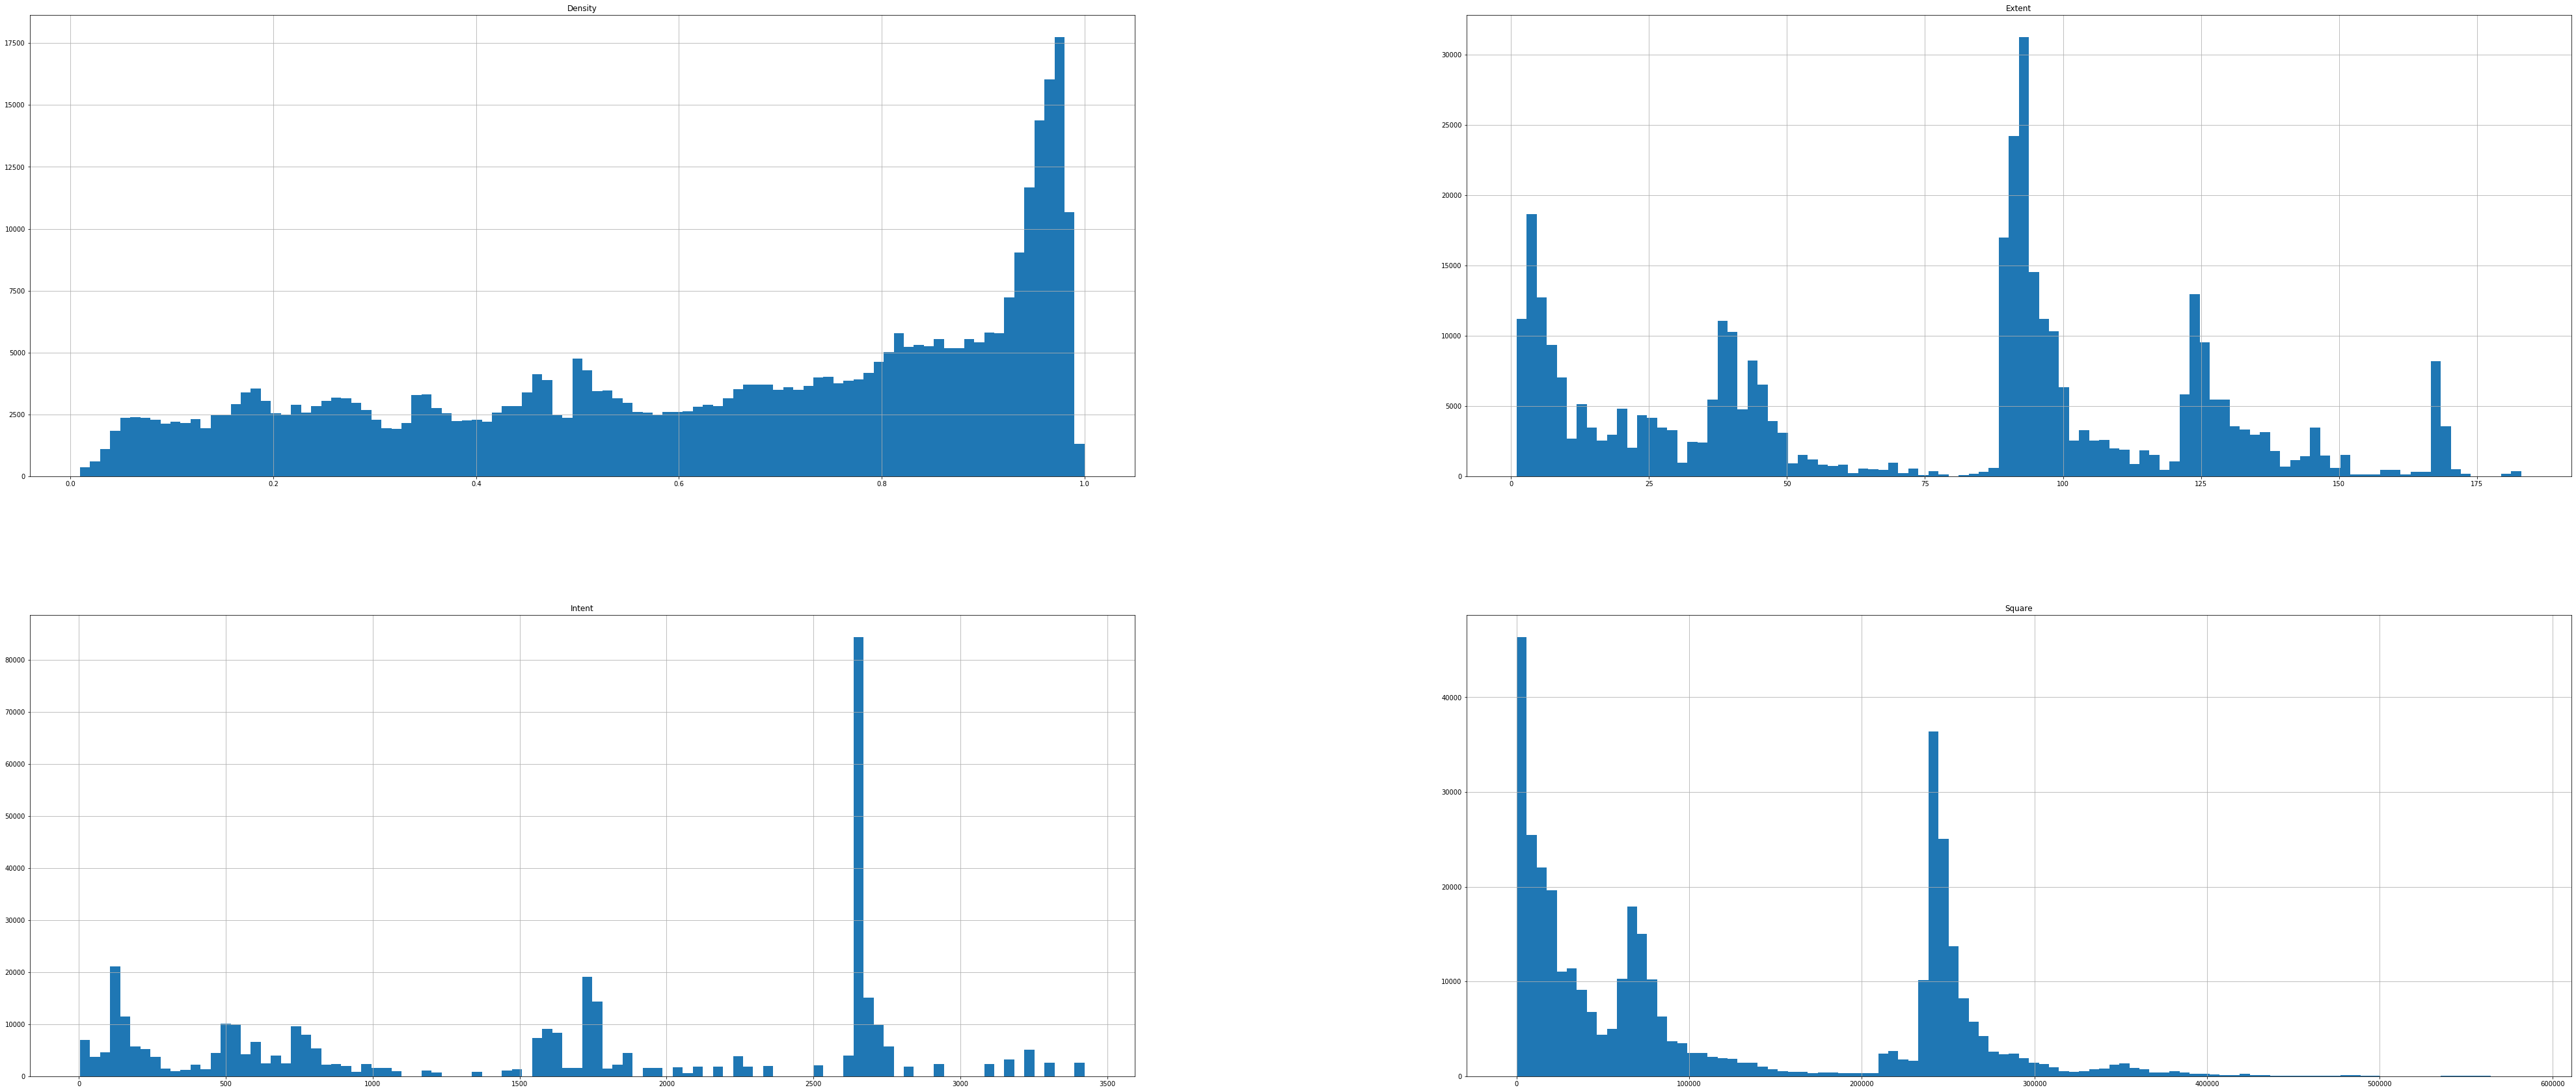

In [434]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (70,30))
ax = fig.gca()

df_Bs.hist(ax = ax, bins=100)

### Selection of dense and large biclusters

In [441]:
Sel=[]
for triple in range(len(Bicl_stat)):
    if Bicl_stat[triple][0]>=0.90 and Bicl_stat[triple][1]>=3 and Bicl_stat[triple][1]<=1500 and Bicl_stat[triple][2]>=3 and Bicl_stat[triple][2]<=80000:
        Sel.append(Bicl_stat[triple])

In [436]:
len(Sel)

98529

In [437]:
df_Sel=pd.DataFrame(Sel, columns =['Density', 'Extent', 'Intent'])

In [438]:
df_Sel['Square']=df_Sel['Extent']*df_Sel['Intent']

In [414]:
Sel

[[0.9835927375215471, 89, 2679],
 [0.9636940140859513, 91, 2679],
 [0.9637391350717218, 91, 2679],
 [0.9731201526274315, 90, 2679],
 [0.9740823690431754, 90, 2679],
 [0.9623116711582557, 91, 2679],
 [0.9432022059266216, 93, 2679],
 [0.9417572758251153, 93, 2679],
 [0.9221076206754287, 95, 2679],
 [0.9622665501724852, 91, 2679],
 [0.9421626589924823, 93, 2679],
 [0.9734478039069304, 90, 2679],
 [0.9740740740740741, 90, 2679],
 [0.9535680088287324, 92, 2679],
 [0.9636160778378023, 91, 2679],
 [0.9635914663910184, 91, 2679],
 [0.9533326841618385, 92, 2679],
 [0.9726722242959644, 90, 2679],
 [0.9517300420338543, 92, 2679],
 [0.9070356303128957, 97, 2679],
 [0.9525415064024538, 92, 2679],
 [0.9728795985234955, 90, 2679],
 [0.9531257607478456, 92, 2679],
 [0.9732528721330513, 90, 2679],
 [0.9641452239436562, 91, 2679],
 [0.9530649009202006, 92, 2679],
 [0.952314296379246, 92, 2679],
 [0.9729418107917548, 90, 2679],
 [0.9728339761934387, 90, 2679],
 [0.9519897106318062, 92, 2679],
 [0.9633904

/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5db5202d0>,
      dtype=object)

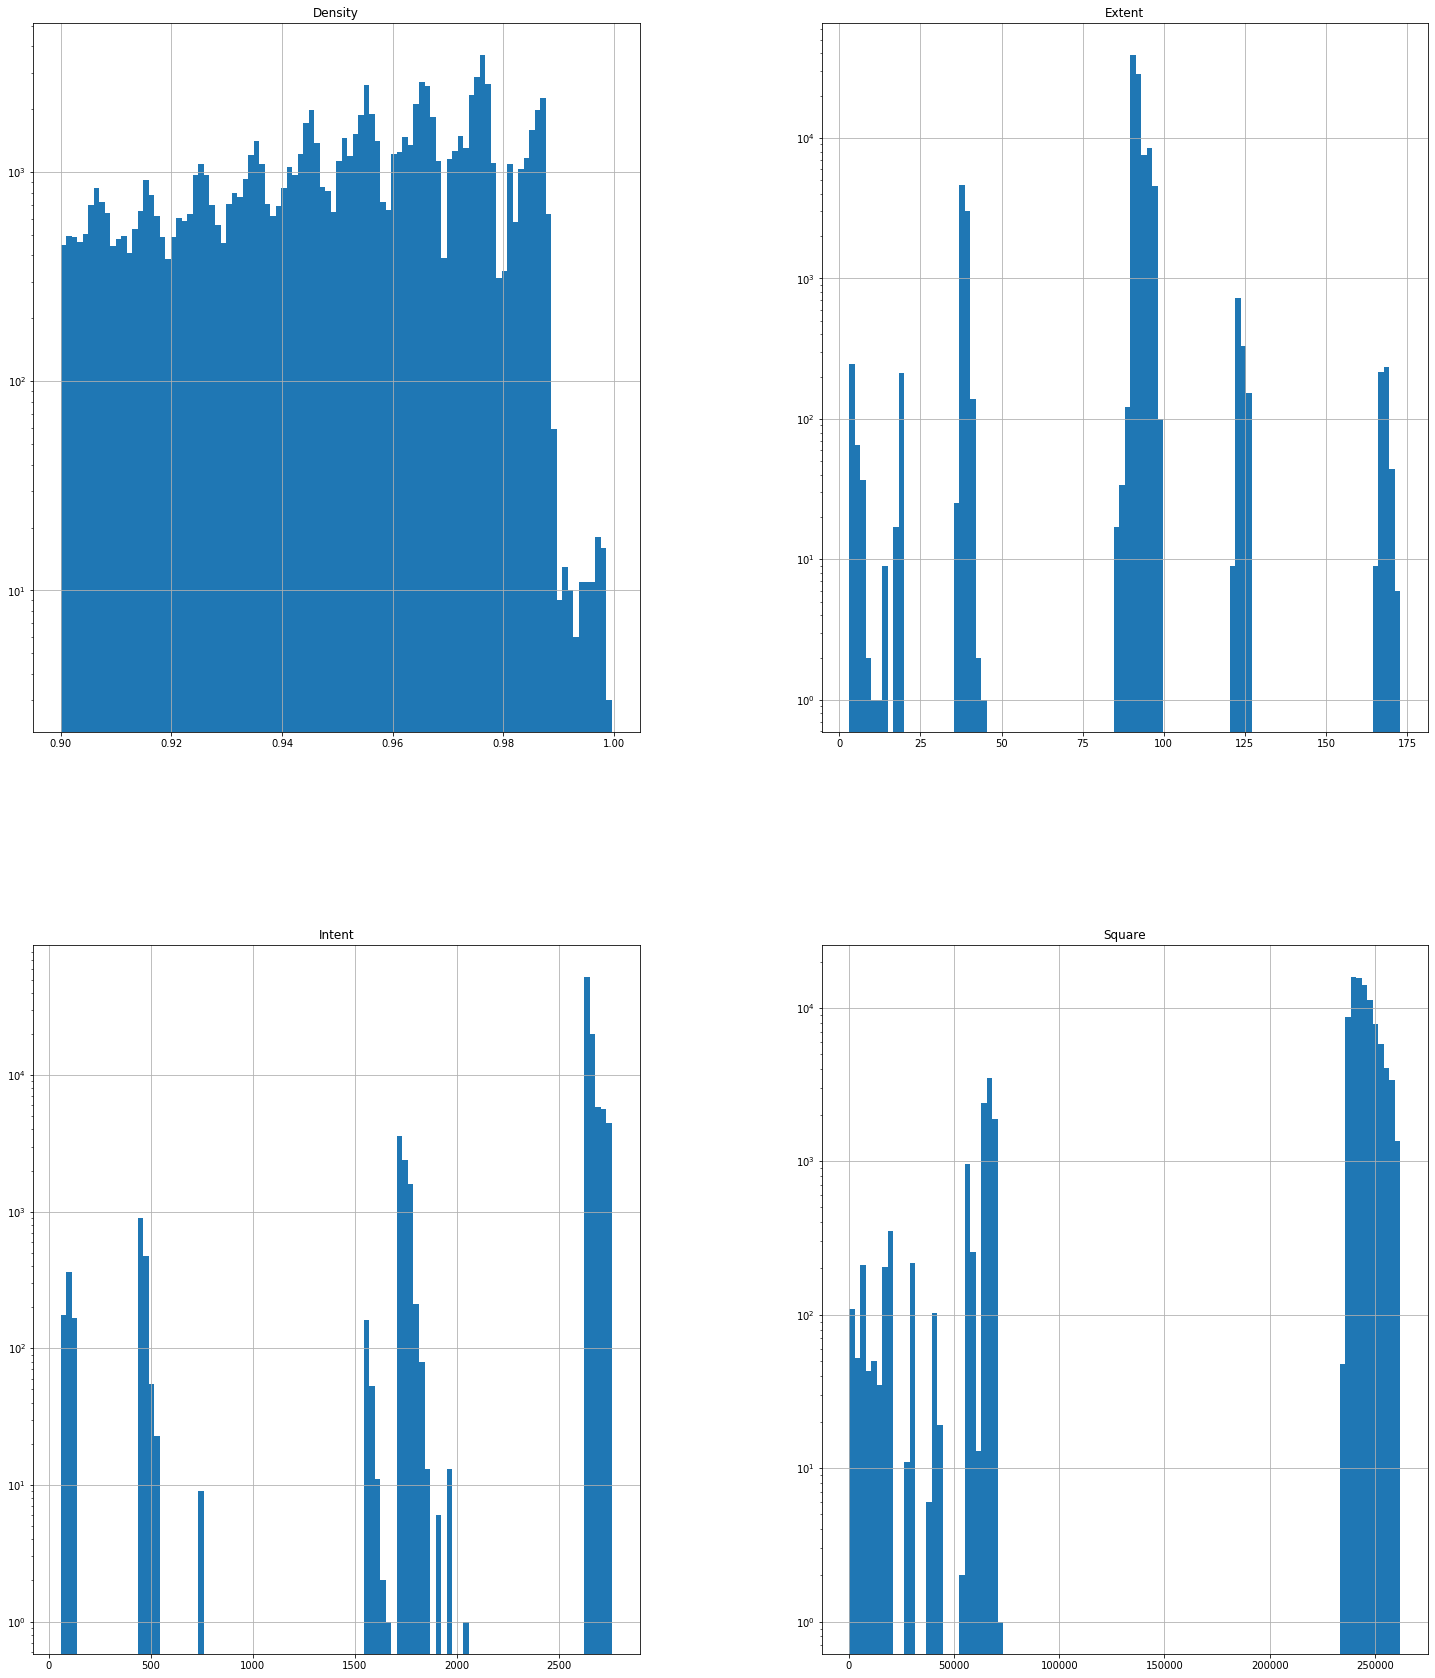

In [439]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (25,30))
ax = fig.gca()

df_Sel.hist(ax = ax, bins=100, log=True)

In [146]:
f = open("B.pkl","rb")
Bp=pickle.load(f)
f.close()

In [90]:
len(Bp)

383733

In [7]:
B=Bp

In [191]:
123

123

In [192]:
91

91

In [193]:
38

38

In [194]:
20

20

In [ ]:
165-170

In [232]:
def Selection(Bicl_stat, density_min, density_max, ext_min, ext_max, int_min, int_max):
    Sel=[]
    for triple in range(len(Bicl_stat)):
        if Bicl_stat[triple][0]>=density_min and Bicl_stat[triple][0]<=density_max and Bicl_stat[triple][1]>=ext_min and Bicl_stat[triple][1]<=ext_max and Bicl_stat[triple][2]>=int_min and Bicl_stat[triple][2]<=int_max:
            Sel.append(Bicl_stat[triple])
    return Sel            

In [300]:
pd.DataFrame(Selection(Bicl_stat,0.9408,1, 122, 122, 3, 80000), columns =['Density', 'Extent', 'Intent']).describe()

Density  Extent  Intent
count  1.000000     1.0     1.0
mean   0.940876   122.0   455.0
std         NaN     NaN     NaN
min    0.940876   122.0   455.0
25%    0.940876   122.0   455.0
50%    0.940876   122.0   455.0
75%    0.940876   122.0   455.0
max    0.940876   122.0   455.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc63765c390>,
      dtype=object)

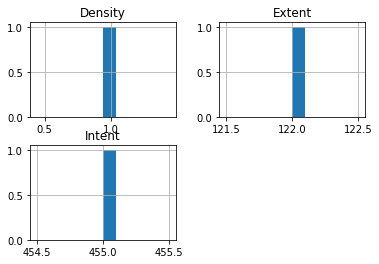

In [293]:
pd.DataFrame(Selection(Bicl_stat,0.9408,1, 122, 122, 3, 80000), columns =['Density', 'Extent', 'Intent']).hist()

In [299]:
pd.DataFrame(Selection(Bicl_stat,0.999,1, 89, 89, 3, 80000), columns =['Density', 'Extent', 'Intent']).describe()

Density  Extent  Intent
count  1.000000     1.0     1.0
mean   0.999637    89.0  2634.0
std         NaN     NaN     NaN
min    0.999637    89.0  2634.0
25%    0.999637    89.0  2634.0
50%    0.999637    89.0  2634.0
75%    0.999637    89.0  2634.0
max    0.999637    89.0  2634.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc591d9df10>,
      dtype=object)

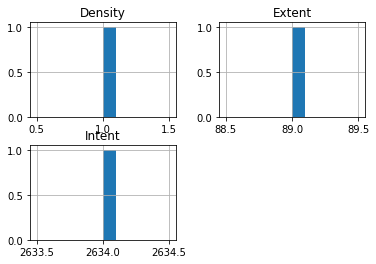

In [298]:
pd.DataFrame(Selection(Bicl_stat,0.999,1, 89, 89, 3, 80000), columns =['Density', 'Extent', 'Intent']).hist()

In [304]:
pd.DataFrame(Selection(Bicl_stat,0.99,1, 36, 40, 3, 80000), columns =['Density', 'Extent', 'Intent']).describe()

Density  Extent  Intent
count   1.0000     1.0     1.0
mean    0.9906    36.0  1714.0
std        NaN     NaN     NaN
min     0.9906    36.0  1714.0
25%     0.9906    36.0  1714.0
50%     0.9906    36.0  1714.0
75%     0.9906    36.0  1714.0
max     0.9906    36.0  1714.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc575798750>,
      dtype=object)

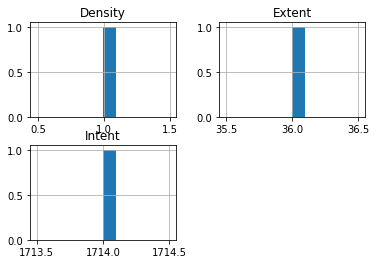

In [303]:
pd.DataFrame(Selection(Bicl_stat,0.99,1, 36, 40, 3, 80000), columns =['Density', 'Extent', 'Intent']).hist()

In [309]:
pd.DataFrame(Selection(Bicl_stat,0.96,1, 18, 18, 3, 80000),columns =['Density', 'Extent', 'Intent']).describe()


Density  Extent  Intent
count  1.000000     1.0     1.0
mean   0.960016    18.0  1552.0
std         NaN     NaN     NaN
min    0.960016    18.0  1552.0
25%    0.960016    18.0  1552.0
50%    0.960016    18.0  1552.0
75%    0.960016    18.0  1552.0
max    0.960016    18.0  1552.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5dcf58b90>,
      dtype=object)

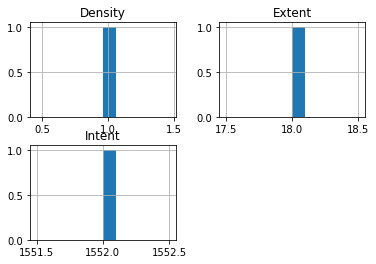

In [307]:
pd.DataFrame(Selection(Bicl_stat,0.96,1, 17, 22, 3, 80000),columns =['Density', 'Extent', 'Intent']).hist()

In [311]:
pd.DataFrame(Selection(Bicl_stat,0.954,1, 160, 175, 3, 80000),columns =['Density', 'Extent', 'Intent']).describe()

Density  Extent  Intent
count  1.000000     1.0     1.0
mean   0.954429   166.0   108.0
std         NaN     NaN     NaN
min    0.954429   166.0   108.0
25%    0.954429   166.0   108.0
50%    0.954429   166.0   108.0
75%    0.954429   166.0   108.0
max    0.954429   166.0   108.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc591ec2510>,
      dtype=object)

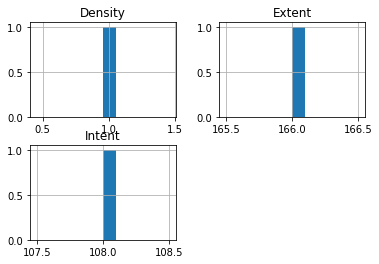

In [312]:
pd.DataFrame(Selection(Bicl_stat,0.954,1, 160, 175, 3, 80000),columns =['Density', 'Extent', 'Intent']).hist()

In [282]:
pd.DataFrame(Selection(Bicl_stat,0.92,1, 3, 1500, 520, 600),columns =['Density', 'Extent', 'Intent']).describe()

Density  Extent  Intent
count  1.000000     1.0     1.0
mean   0.921795     3.0   520.0
std         NaN     NaN     NaN
min    0.921795     3.0   520.0
25%    0.921795     3.0   520.0
50%    0.921795     3.0   520.0
75%    0.921795     3.0   520.0
max    0.921795     3.0   520.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc574c628d0>,
      dtype=object)

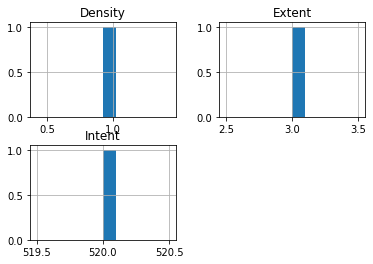

In [281]:
pd.DataFrame(Selection(Bicl_stat,0.92,1, 3, 1500, 520, 600),columns =['Density', 'Extent', 'Intent']).hist()

In [314]:
0.940876*122.0*455.0

52228.02676

In [315]:
122.0*455.0

55510.0

In [318]:
pd.DataFrame(Selection(Bicl_stat,0.90,1, 3, 1500, 2000, 2500),columns =['Density', 'Extent', 'Intent']).describe()

Density  Extent  Intent
count  1.000000     1.0     1.0
mean   0.900422     3.0  2052.0
std         NaN     NaN     NaN
min    0.900422     3.0  2052.0
25%    0.900422     3.0  2052.0
50%    0.900422     3.0  2052.0
75%    0.900422     3.0  2052.0
max    0.900422     3.0  2052.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5dd026850>,
      dtype=object)

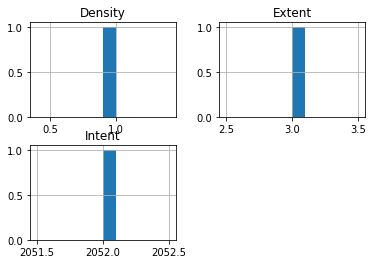

In [319]:
pd.DataFrame(Selection(Bicl_stat,0.9,1, 3, 1500, 2000, 2500),columns =['Density', 'Extent', 'Intent']).hist()

In [325]:
pd.DataFrame(Selection(Bicl_stat,0.9257,1, 14, 14, 3, 1000),columns =['Density', 'Extent', 'Intent']).describe()

Density  Extent  Intent
count  1.000000     1.0     1.0
mean   0.927514    14.0   743.0
std         NaN     NaN     NaN
min    0.927514    14.0   743.0
25%    0.927514    14.0   743.0
50%    0.927514    14.0   743.0
75%    0.927514    14.0   743.0
max    0.927514    14.0   743.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5759d0450>,
      dtype=object)

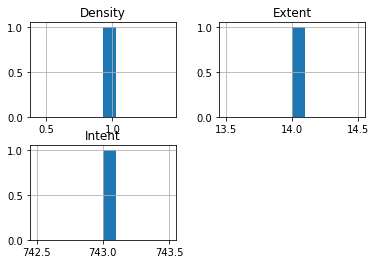

In [327]:
pd.DataFrame(Selection(Bicl_stat,0.9257,1, 14, 14, 3, 90000),columns =['Density', 'Extent', 'Intent']).hist()

In [332]:
pd.DataFrame(Selection(Bicl_stat,0.97,1, 3, 40, 3, 1000),columns =['Density', 'Extent', 'Intent']).describe()

Density  Extent  Intent
count  1.000000     1.0     1.0
mean   0.975309     3.0   108.0
std         NaN     NaN     NaN
min    0.975309     3.0   108.0
25%    0.975309     3.0   108.0
50%    0.975309     3.0   108.0
75%    0.975309     3.0   108.0
max    0.975309     3.0   108.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5507bac50>,
      dtype=object)

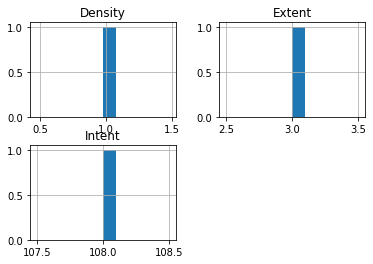

In [334]:
pd.DataFrame(Selection(Bicl_stat,0.97,1, 3, 40, 3, 1000),columns =['Density', 'Extent', 'Intent']).hist()

In [339]:
pd.DataFrame(Selection(Bicl_stat,0.91,1, 3, 40, 758, 758),columns =['Density', 'Extent', 'Intent']).describe()


Density  Extent  Intent
count  2.000000     2.0     2.0
mean   0.910573    14.0   758.0
std    0.000000     0.0     0.0
min    0.910573    14.0   758.0
25%    0.910573    14.0   758.0
50%    0.910573    14.0   758.0
75%    0.910573    14.0   758.0
max    0.910573    14.0   758.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5920c7f90>,
      dtype=object)

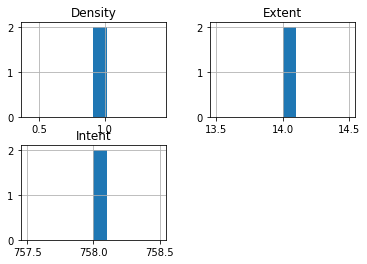

In [337]:
pd.DataFrame(Selection(Bicl_stat,0.9,1, 3, 40, 758, 758),columns =['Density', 'Extent', 'Intent']).hist()

### Incorporating RS

In [340]:
read_dictionary = np.load('snp_dict.npy', allow_pickle='TRUE').item()

In [341]:
read_dictionary

{0: 'rs12086311_0',
 1: 'rs4475691_A',
 2: 'rs9777703_G',
 3: 'rs3934834_A',
 4: 'rs3737728_A',
 5: 'rs6687776_A',
 6: 'rs4970405_G',
 7: 'rs4970362_A',
 8: 'rs9660710_A',
 9: 'rs9729550_C',
 10: 'rs3813199_A',
 11: 'rs715643_A',
 12: 'rs7524470_G',
 13: 'rs2649588_G',
 14: 'rs819980_G',
 15: 'rs6690515_A',
 16: 'rs6603793_A',
 17: 'rs7531583_A',
 18: 'rs742359_A',
 19: 'rs6681938_G',
 20: 'rs7525092_A',
 21: 'rs2803291_A',
 22: 'rs2254669_G',
 23: 'rs884080_A',
 24: 'rs908742_A',
 25: 'rs3107151_A',
 26: 'rs3128291_A',
 27: 'rs6665593_A',
 28: 'rs7512482_G',
 29: 'rs2460000_A',
 30: 'rs260513_A',
 31: 'rs7547453_A',
 32: 'rs11588312_A',
 33: 'rs7553178_G',
 34: 'rs10910047_A',
 35: 'rs2279702_A',
 36: 'rs2843157_A',
 37: 'rs903904_A',
 38: 'rs2843143_A',
 39: 'rs2055204_G',
 40: 'rs2840528_G',
 41: 'rs903914_A',
 42: 'rs7545940_G',
 43: 'rs2843160_C',
 44: 'rs2643901_A',
 45: 'rs4648633_G',
 46: 'rs3001336_G',
 47: 'rs2494428_G',
 48: 'rs6659405_A',
 49: 'rs11581548_A',
 50: 'rs109100

In [346]:
Bdl[0]

{(0, 0): (0.9835927375215471, 89, 2679)}

In [352]:
Bf={}
for idx in range(len(B)):
    #B[list(Bdl[idx].keys())[0]]
    Bf[list(Bdl[idx].keys())[0]]=B[list(Bdl[idx].keys())[0]],Bicl_stat[idx]



In [367]:
def FullSelection(Bdl,Bicl_stat, density_min, density_max, ext_min, ext_max, int_min, int_max):
    Bf={}
    for triple in range(len(Bicl_stat)):
        if Bicl_stat[triple][0]>=density_min and Bicl_stat[triple][0]<=density_max and Bicl_stat[triple][1]>=ext_min and Bicl_stat[triple][1]<=ext_max and Bicl_stat[triple][2]>=int_min and Bicl_stat[triple][2]<=int_max:
            Bf[list(Bdl[triple].keys())[0]]=B[list(Bdl[triple].keys())[0]],Bicl_stat[triple]
    return Bf  

In [369]:
ex=FullSelection(Bdl,Bicl_stat,0.91,1, 3, 40, 758, 758)

In [416]:
def EncodeSelection(Bf, enc_dict):
    B_enc={}
    for key in Bf.keys():
        enc=[]
        for rs_idx in Bf[key][0][1]:
            enc.append(enc_dict[rs_idx])
            B_enc[(key[0],enc_dict[key[1]])]= Bf[key][0][0],enc,Bf[key][1][0],Bf[key][1][1],Bf[key][1][2],Bf[key][1][1]*Bf[key][1][2]
    return B_enc       

In [417]:
ex1=EncodeSelection(ex, read_dictionary)

In [418]:
print(ex1)

{(1102, 'rs6704827_A'): ([1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114], ['rs10915587_G', 'rs284267_A', 'rs6656310_G', 'rs3124627_G', 'rs1055412_G', 'rs12119764_G', 'rs925826_A', 'rs11589265_A', 'rs6682357_A', 'rs1890020_G', 'rs696625_G', 'rs634378_C', 'rs4660531_A', 'rs10493096_A', 'rs1165284_A', 'rs2793673_A', 'rs10493294_A', 'rs12116810_C', 'rs6587971_G', 'rs834485_A', 'rs2807912_A', 'rs12028841_A', 'rs12127333_A', 'rs4593805_A', 'rs165277_C', 'rs17513917_A', 'rs2785597_C', 'rs17411335_C', 'rs1826316_G', 'rs1938344_A', 'rs12028453_A', 'rs10857934_C', 'rs577935_A', 'rs3936952_A', 'rs3007708_C', 'rs11581556_A', 'rs6681981_G', 'rs11810084_G', 'rs1412784_G', 'rs1327144_C', 'rs10798069_A', 'rs284113_A', 'rs339557_G', 'rs11579497_A', 'rs10922187_G', 'rs12119142_A', 'rs10920260_C', 'rs7366689_A', 'rs4844614_A', 'rs1875431_A', 'rs320471_G', 'rs10492958_G', 'rs10495060_G', 'rs6656145_C', 'rs1136448_G', 'rs10799322_A', 'rs9428368_C', 'rs12123434_A', 'rs10

In [392]:
f = open("B_full.pkl","wb")
pickle.dump(Bf,f)
f.close()

In [394]:
len(Bf)

383733

In [395]:
f = open("B_full.pkl","rb")
test=pickle.load(f)
f.close()

In [396]:
len(test)

383733

In [398]:
test[(0,0)]

([[0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88],
  [0,
   1,
   2,
   15,
   18,
   22,
   48,
   49,
   53,
   55,
   56,
   57,
   58,
   75,
   108,
   111,
   122,
   140,
   235,
   257,
   278,
   337,
   339,
   344,
   368,
   382,
   383,
   384,
   447,
   450,
   456,
   527,
   553,
   558,
   667,
   685,
   687,
   700,
   701,
   711,
   839,
   909,
   915,
   944,
   945,
   976,
   1022,
   1057,
   1079,
   1085,

In [1]:
#Online OA-biclustering

In [3]:
D=np.load("X.npy") #IMG Data1

In [10]:
from scipy.sparse import csr_matrix, find

In [5]:
S = csr_matrix(D)

In [27]:
Ind=find(S)

In [28]:
Ind

(array([   0,    1,    2, ..., 1319, 1320, 1321], dtype=int32),
 array([    0,     0,     0, ..., 85141, 85141, 85141], dtype=int32),
 array([-1, -1, -1, ...,  2,  1,  1]))

In [22]:
D_zo=np.array(D)
for i in range(len(Ind[2])):
    if Ind[2][i]!=-1:
        D_zo[Ind[0][i]][Ind[1][i]]=0
    else: D_zo[Ind[0][i]][Ind[1][i]]=1

In [23]:
S_zo=csr_matrix(D_zo)

In [29]:
Ind_zo=find(S_zo)

In [30]:
Ind_zo

(array([  0,   1,   2, ...,  87,  88, 324], dtype=int32),
 array([    0,     0,     0, ..., 85141, 85141, 85141], dtype=int32),
 array([1, 1, 1, ..., 1, 1, 1]))

In [32]:
len(Ind_zo[2])

553430

In [33]:
len(Ind[2])

49345350

In [34]:
len(Ind_zo[2])/len(Ind[2])

0.011215443805748668

In [44]:
from collections import defaultdict

In [92]:
start=timer()

ObjP=defaultdict(list)
AttrP=defaultdict(list)
BiclS=[]


for i in range(len(Ind_zo[2])):
    AttrP[Ind_zo[1][i]].append(Ind_zo[0][i])
    ObjP[Ind_zo[0][i]].append(Ind_zo[1][i])
    BiclS.append((Ind_zo[0][i],Ind_zo[1][i],AttrP[Ind_zo[1][i]],ObjP[Ind_zo[0][i]]))
end=timer() 

print("Elapsed time", end-start)

Elapsed time 1.5024474740002915


In [54]:
BiclS[1]

(1,
 0,
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88],
 [0,
  1,
  2,
  15,
  18,
  22,
  48,
  49,
  53,
  55,
  56,
  57,
  58,
  75,
  108,
  111,
  122,
  140,
  235,
  257,
  278,
  337,
  339,
  344,
  368,
  382,
  383,
  384,
  447,
  450,
  456,
  527,
  553,
  558,
  667,
  685,
  687,
  700,
  701,
  711,
  839,
  909,
  915,
  944,
  945,
  976,
  1022,
  1057,
  1079,
  1085,
  1088,
  1125,
  1128,
  1150,
  1192,
  1193,
  1203,
  1204,
  1227,
  1228,
  1229,
  1230,
  1231,
  1237,
  1239,
  1245,
  

In [82]:
def Density2(S_zo,b):
    num=0
    num=S_zo[b[0],:][:,b[1]].nnz

    return num/(len(b[0])*len(b[1]))

In [83]:
Density2(S_zo,BiclS[0][2:]) #0.9835927375215471

0.9835927375215471

In [84]:
BiclS[0][2:]

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88],
 [0,
  1,
  2,
  15,
  18,
  22,
  48,
  49,
  53,
  55,
  56,
  57,
  58,
  75,
  108,
  111,
  122,
  140,
  235,
  257,
  278,
  337,
  339,
  344,
  368,
  382,
  383,
  384,
  447,
  450,
  456,
  527,
  553,
  558,
  667,
  685,
  687,
  700,
  701,
  711,
  839,
  909,
  915,
  944,
  945,
  976,
  1022,
  1057,
  1079,
  1085,
  1088,
  1128,
  1150,
  1192,
  1193,
  1203,
  1204,
  1227,
  1228,
  1229,
  1230,
  1231,
  1237,
  1239,
  1245,
  1253,
  1265,
  

In [85]:
len(BiclS[0][2])

89

In [86]:
len(BiclS[0][3])

2679

In [87]:
B_dens=[]
start=timer()
for i in range(len(BiclS)):
    B_dens.append(Density2(S_zo,BiclS[i][2:]))
    if i%1000==0: 
        print(i)
        end=timer()
        print("Time elapsed",end-start)
end=timer()
print("Time elapsed",end-start)


0
Time elapsed 0.0059652979998645606
1000
Time elapsed 2.5521870920001675
2000
Time elapsed 4.638188853999964
3000
Time elapsed 6.368933083000229
4000
Time elapsed 8.099834892999752
5000
Time elapsed 9.611053249999713
6000
Time elapsed 11.383806556000309
7000
Time elapsed 12.970278810000309
8000
Time elapsed 14.605351320999944
9000
Time elapsed 16.756592928999453
10000
Time elapsed 18.679344981000213
11000
Time elapsed 20.410046836999754
12000
Time elapsed 21.69216449400028
13000
Time elapsed 23.230490463000024
14000
Time elapsed 24.331617714999993
15000
Time elapsed 25.519139648999953
16000
Time elapsed 26.849206471999423
17000
Time elapsed 28.30722535299992
18000
Time elapsed 29.5414075460003
19000
Time elapsed 30.63717092099978
20000
Time elapsed 31.80507225099973
21000
Time elapsed 33.22144593400026
22000
Time elapsed 35.50616551700023
23000
Time elapsed 37.77183712999977
24000
Time elapsed 39.185848166999676
25000
Time elapsed 41.25702538799942
26000
Time elapsed 42.36464711899953

217000
Time elapsed 353.4172073569998
218000
Time elapsed 354.8592911380001
219000
Time elapsed 356.3684180579994
220000
Time elapsed 358.1698165099997
221000
Time elapsed 359.5899785800002
222000
Time elapsed 360.8978178540001
223000
Time elapsed 362.5677486610002
224000
Time elapsed 363.809103738
225000
Time elapsed 365.44325595899954
226000
Time elapsed 366.82314030499947
227000
Time elapsed 367.82074062799984
228000
Time elapsed 369.694624279
229000
Time elapsed 372.22502653099946
230000
Time elapsed 374.0765406549999
231000
Time elapsed 376.18497866300004
232000
Time elapsed 378.0332933489999
233000
Time elapsed 380.48670352499994
234000
Time elapsed 381.66090663399973
235000
Time elapsed 383.6181068019996
236000
Time elapsed 385.6165129809997
237000
Time elapsed 387.156246517
238000
Time elapsed 388.40939130900006
239000
Time elapsed 390.345822235
240000
Time elapsed 392.30625958899964
241000
Time elapsed 394.1083175249996
242000
Time elapsed 395.77806327799954
243000
Time elapse

434000
Time elapsed 701.0997655169995
435000
Time elapsed 702.1724400470002
436000
Time elapsed 704.3506676010002
437000
Time elapsed 706.4165757700002
438000
Time elapsed 708.9393467999998
439000
Time elapsed 711.6566973769995
440000
Time elapsed 713.7981835169994
441000
Time elapsed 716.0089381649996
442000
Time elapsed 718.4422890360001
443000
Time elapsed 720.3055228530002
444000
Time elapsed 721.8510572619998
445000
Time elapsed 723.9844490349997
446000
Time elapsed 725.749796397
447000
Time elapsed 726.9468124320001
448000
Time elapsed 728.4528562750002
449000
Time elapsed 730.5978208739998
450000
Time elapsed 732.4498462629999
451000
Time elapsed 734.6618767649998
452000
Time elapsed 736.3263231149995
453000
Time elapsed 738.4268862930003
454000
Time elapsed 740.6768518640001
455000
Time elapsed 742.7490297980003
456000
Time elapsed 744.415541849
457000
Time elapsed 746.2924197269995
458000
Time elapsed 748.0620323269995
459000
Time elapsed 749.8117565719995
460000
Time elapsed 

In [75]:
D_zo[[0,1,2,3,4,5,6],:][:,[0,1,2,3,4,5]]

array([[1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0]])

array([[1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [97]:
def biclDenLen(S_zo,Bk,key):
    den={}
    den[key]=(Density2(S_zo,Bk), len(Bk[0]),len(Bk[1]))
    #if key[0]%10==0: print(key)
    return den
           
idx=range(len(BiclS))

import os
from joblib import dump, load

folder = './joblib_memmap2'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

data_filename_memmap = os.path.join(folder, 'data_memmap')
bicl_filename_memmap = os.path.join(folder, 'bicl_memmap')

#dump(S_zo, data_filename_memmap)
#dump(BiclS, bicl_filename_memmap)
#D_ = load(data_filename_memmap, mmap_mode='r')
#B_ = load(bicl_filename_memmap, mmap_mode='r')
                
start = timer()
    
#Bdl = Parallel(n_jobs=num_cores, backend="threading", verbose=100, pre_dispatch="100*n_jobs", batch_size=100)(delayed(biclDenLen)(D,B[key],key) for key in keys)
#Bdl = Parallel(n_jobs=num_cores, verbose=100, pre_dispatch="100*n_jobs", batch_size=100)(delayed(biclDenLen)(D_,B_[i][2:],B_[i][0:2]) for i in idx)
#Bdl = Parallel(n_jobs=num_cores, verbose=100)(delayed(biclDenLen)(D_,B_[i][2:],B_[i][0:2]) for i in idx)
Bdl = Parallel(n_jobs=num_cores, verbose=100)(delayed(biclDenLen)(S_zo,BiclS[i][2:],BiclS[i][0:2]) for i in idx)





end = timer()
print("Density calculation phase", end - start) 

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done   3 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done   6 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done   7 tasks      | elapsed:    1.1s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=12)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=12)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done  11 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done  12 tasks      | elapsed:    1.3s
[Parallel(n_jobs=12)]: Done  13 tasks      | elapsed:    1.3s
[Parallel(n_jobs=12)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=12)]: Done  15 tasks      | elapsed:  

[Parallel(n_jobs=12)]: Done 134 tasks      | elapsed:    7.6s
[Parallel(n_jobs=12)]: Done 135 tasks      | elapsed:    7.7s
[Parallel(n_jobs=12)]: Done 136 tasks      | elapsed:    7.7s
[Parallel(n_jobs=12)]: Done 137 tasks      | elapsed:    7.8s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    7.9s
[Parallel(n_jobs=12)]: Done 139 tasks      | elapsed:    7.9s
[Parallel(n_jobs=12)]: Done 140 tasks      | elapsed:    8.0s
[Parallel(n_jobs=12)]: Done 141 tasks      | elapsed:    8.0s
[Parallel(n_jobs=12)]: Done 142 tasks      | elapsed:    8.1s
[Parallel(n_jobs=12)]: Done 143 tasks      | elapsed:    8.1s
[Parallel(n_jobs=12)]: Done 144 tasks      | elapsed:    8.2s
[Parallel(n_jobs=12)]: Done 145 tasks      | elapsed:    8.2s
[Parallel(n_jobs=12)]: Done 146 tasks      | elapsed:    8.3s
[Parallel(n_jobs=12)]: Done 147 tasks      | elapsed:    8.3s
[Parallel(n_jobs=12)]: Done 148 tasks      | elapsed:    8.4s
[Parallel(n_jobs=12)]: Done 149 tasks      | elapsed:    8.4s
[Paralle

[Parallel(n_jobs=12)]: Done 267 tasks      | elapsed:   15.2s
[Parallel(n_jobs=12)]: Done 268 tasks      | elapsed:   15.3s
[Parallel(n_jobs=12)]: Done 269 tasks      | elapsed:   15.4s
[Parallel(n_jobs=12)]: Done 270 tasks      | elapsed:   15.4s
[Parallel(n_jobs=12)]: Done 271 tasks      | elapsed:   15.4s
[Parallel(n_jobs=12)]: Done 272 tasks      | elapsed:   15.4s
[Parallel(n_jobs=12)]: Done 273 tasks      | elapsed:   15.5s
[Parallel(n_jobs=12)]: Done 274 tasks      | elapsed:   15.5s
[Parallel(n_jobs=12)]: Done 275 tasks      | elapsed:   15.5s
[Parallel(n_jobs=12)]: Done 276 tasks      | elapsed:   15.5s
[Parallel(n_jobs=12)]: Done 277 tasks      | elapsed:   15.5s
[Parallel(n_jobs=12)]: Done 278 tasks      | elapsed:   15.6s
[Parallel(n_jobs=12)]: Done 279 tasks      | elapsed:   15.6s
[Parallel(n_jobs=12)]: Done 280 tasks      | elapsed:   15.6s
[Parallel(n_jobs=12)]: Done 281 tasks      | elapsed:   15.7s
[Parallel(n_jobs=12)]: Done 282 tasks      | elapsed:   15.7s
[Paralle

[Parallel(n_jobs=12)]: Done 402 tasks      | elapsed:   21.9s
[Parallel(n_jobs=12)]: Done 403 tasks      | elapsed:   22.0s
[Parallel(n_jobs=12)]: Done 404 tasks      | elapsed:   22.0s
[Parallel(n_jobs=12)]: Done 405 tasks      | elapsed:   22.1s
[Parallel(n_jobs=12)]: Done 406 tasks      | elapsed:   22.1s
[Parallel(n_jobs=12)]: Done 407 tasks      | elapsed:   22.2s
[Parallel(n_jobs=12)]: Done 408 tasks      | elapsed:   22.2s
[Parallel(n_jobs=12)]: Done 409 tasks      | elapsed:   22.3s
[Parallel(n_jobs=12)]: Done 410 tasks      | elapsed:   22.3s
[Parallel(n_jobs=12)]: Done 411 tasks      | elapsed:   22.4s
[Parallel(n_jobs=12)]: Done 412 tasks      | elapsed:   22.4s
[Parallel(n_jobs=12)]: Done 413 tasks      | elapsed:   22.5s
[Parallel(n_jobs=12)]: Done 414 tasks      | elapsed:   22.5s
[Parallel(n_jobs=12)]: Done 415 tasks      | elapsed:   22.6s
[Parallel(n_jobs=12)]: Done 416 tasks      | elapsed:   22.6s
[Parallel(n_jobs=12)]: Done 417 tasks      | elapsed:   22.6s
[Paralle

[Parallel(n_jobs=12)]: Done 537 tasks      | elapsed:   28.7s
[Parallel(n_jobs=12)]: Done 538 tasks      | elapsed:   28.8s
[Parallel(n_jobs=12)]: Done 539 tasks      | elapsed:   28.8s
[Parallel(n_jobs=12)]: Done 540 tasks      | elapsed:   28.9s
[Parallel(n_jobs=12)]: Done 541 tasks      | elapsed:   28.9s
[Parallel(n_jobs=12)]: Done 542 tasks      | elapsed:   29.0s
[Parallel(n_jobs=12)]: Done 543 tasks      | elapsed:   29.0s
[Parallel(n_jobs=12)]: Done 544 tasks      | elapsed:   29.1s
[Parallel(n_jobs=12)]: Done 545 tasks      | elapsed:   29.1s
[Parallel(n_jobs=12)]: Done 546 tasks      | elapsed:   29.2s
[Parallel(n_jobs=12)]: Done 547 tasks      | elapsed:   29.2s
[Parallel(n_jobs=12)]: Done 548 tasks      | elapsed:   29.3s
[Parallel(n_jobs=12)]: Done 549 tasks      | elapsed:   29.3s
[Parallel(n_jobs=12)]: Done 550 tasks      | elapsed:   29.4s
[Parallel(n_jobs=12)]: Done 551 tasks      | elapsed:   29.4s
[Parallel(n_jobs=12)]: Done 552 tasks      | elapsed:   29.5s
[Paralle

[Parallel(n_jobs=12)]: Done 676 tasks      | elapsed:   33.0s
[Parallel(n_jobs=12)]: Done 677 tasks      | elapsed:   33.0s
[Parallel(n_jobs=12)]: Done 678 tasks      | elapsed:   33.0s
[Parallel(n_jobs=12)]: Done 679 tasks      | elapsed:   33.0s
[Parallel(n_jobs=12)]: Done 680 tasks      | elapsed:   33.1s
[Parallel(n_jobs=12)]: Done 681 tasks      | elapsed:   33.1s
[Parallel(n_jobs=12)]: Done 682 tasks      | elapsed:   33.1s
[Parallel(n_jobs=12)]: Done 683 tasks      | elapsed:   33.1s
[Parallel(n_jobs=12)]: Done 684 tasks      | elapsed:   33.1s
[Parallel(n_jobs=12)]: Done 685 tasks      | elapsed:   33.1s
[Parallel(n_jobs=12)]: Done 686 tasks      | elapsed:   33.1s
[Parallel(n_jobs=12)]: Done 687 tasks      | elapsed:   33.2s
[Parallel(n_jobs=12)]: Done 688 tasks      | elapsed:   33.2s
[Parallel(n_jobs=12)]: Done 689 tasks      | elapsed:   33.2s
[Parallel(n_jobs=12)]: Done 690 tasks      | elapsed:   33.2s
[Parallel(n_jobs=12)]: Done 691 tasks      | elapsed:   33.2s
[Paralle

[Parallel(n_jobs=12)]: Done 811 tasks      | elapsed:   38.1s
[Parallel(n_jobs=12)]: Done 812 tasks      | elapsed:   38.2s
[Parallel(n_jobs=12)]: Done 813 tasks      | elapsed:   38.2s
[Parallel(n_jobs=12)]: Done 814 tasks      | elapsed:   38.3s
[Parallel(n_jobs=12)]: Done 815 tasks      | elapsed:   38.3s
[Parallel(n_jobs=12)]: Done 816 tasks      | elapsed:   38.4s
[Parallel(n_jobs=12)]: Done 817 tasks      | elapsed:   38.4s
[Parallel(n_jobs=12)]: Done 818 tasks      | elapsed:   38.5s
[Parallel(n_jobs=12)]: Done 819 tasks      | elapsed:   38.5s
[Parallel(n_jobs=12)]: Done 820 tasks      | elapsed:   38.6s
[Parallel(n_jobs=12)]: Done 821 tasks      | elapsed:   38.6s
[Parallel(n_jobs=12)]: Done 822 tasks      | elapsed:   38.7s
[Parallel(n_jobs=12)]: Done 823 tasks      | elapsed:   38.8s
[Parallel(n_jobs=12)]: Done 824 tasks      | elapsed:   38.8s
[Parallel(n_jobs=12)]: Done 825 tasks      | elapsed:   38.9s
[Parallel(n_jobs=12)]: Done 826 tasks      | elapsed:   39.0s
[Paralle

[Parallel(n_jobs=12)]: Done 946 tasks      | elapsed:   44.8s
[Parallel(n_jobs=12)]: Done 947 tasks      | elapsed:   44.9s
[Parallel(n_jobs=12)]: Done 948 tasks      | elapsed:   44.9s
[Parallel(n_jobs=12)]: Done 949 tasks      | elapsed:   45.0s
[Parallel(n_jobs=12)]: Done 950 tasks      | elapsed:   45.0s
[Parallel(n_jobs=12)]: Done 951 tasks      | elapsed:   45.1s
[Parallel(n_jobs=12)]: Done 952 tasks      | elapsed:   45.2s
[Parallel(n_jobs=12)]: Done 953 tasks      | elapsed:   45.2s
[Parallel(n_jobs=12)]: Done 954 tasks      | elapsed:   45.3s
[Parallel(n_jobs=12)]: Done 955 tasks      | elapsed:   45.3s
[Parallel(n_jobs=12)]: Done 956 tasks      | elapsed:   45.4s
[Parallel(n_jobs=12)]: Done 957 tasks      | elapsed:   45.4s
[Parallel(n_jobs=12)]: Done 958 tasks      | elapsed:   45.5s
[Parallel(n_jobs=12)]: Done 959 tasks      | elapsed:   45.6s
[Parallel(n_jobs=12)]: Done 960 tasks      | elapsed:   45.6s
[Parallel(n_jobs=12)]: Done 961 tasks      | elapsed:   45.7s
[Paralle

[Parallel(n_jobs=12)]: Done 1079 tasks      | elapsed:   51.7s
[Parallel(n_jobs=12)]: Done 1080 tasks      | elapsed:   51.8s
[Parallel(n_jobs=12)]: Done 1081 tasks      | elapsed:   51.8s
[Parallel(n_jobs=12)]: Done 1082 tasks      | elapsed:   51.9s
[Parallel(n_jobs=12)]: Done 1083 tasks      | elapsed:   51.9s
[Parallel(n_jobs=12)]: Done 1084 tasks      | elapsed:   51.9s
[Parallel(n_jobs=12)]: Done 1085 tasks      | elapsed:   52.0s
[Parallel(n_jobs=12)]: Done 1086 tasks      | elapsed:   52.0s
[Parallel(n_jobs=12)]: Done 1087 tasks      | elapsed:   52.1s
[Parallel(n_jobs=12)]: Done 1088 tasks      | elapsed:   52.1s
[Parallel(n_jobs=12)]: Done 1089 tasks      | elapsed:   52.2s
[Parallel(n_jobs=12)]: Done 1090 tasks      | elapsed:   52.2s
[Parallel(n_jobs=12)]: Done 1091 tasks      | elapsed:   52.3s
[Parallel(n_jobs=12)]: Done 1092 tasks      | elapsed:   52.3s
[Parallel(n_jobs=12)]: Done 1093 tasks      | elapsed:   52.4s
[Parallel(n_jobs=12)]: Done 1094 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 1211 tasks      | elapsed:   58.0s
[Parallel(n_jobs=12)]: Done 1212 tasks      | elapsed:   58.0s
[Parallel(n_jobs=12)]: Done 1213 tasks      | elapsed:   58.1s
[Parallel(n_jobs=12)]: Done 1214 tasks      | elapsed:   58.1s
[Parallel(n_jobs=12)]: Done 1215 tasks      | elapsed:   58.2s
[Parallel(n_jobs=12)]: Done 1216 tasks      | elapsed:   58.3s
[Parallel(n_jobs=12)]: Done 1217 tasks      | elapsed:   58.3s
[Parallel(n_jobs=12)]: Done 1218 tasks      | elapsed:   58.4s
[Parallel(n_jobs=12)]: Done 1219 tasks      | elapsed:   58.4s
[Parallel(n_jobs=12)]: Done 1220 tasks      | elapsed:   58.5s
[Parallel(n_jobs=12)]: Done 1221 tasks      | elapsed:   58.5s
[Parallel(n_jobs=12)]: Done 1222 tasks      | elapsed:   58.6s
[Parallel(n_jobs=12)]: Done 1223 tasks      | elapsed:   58.6s
[Parallel(n_jobs=12)]: Done 1224 tasks      | elapsed:   58.7s
[Parallel(n_jobs=12)]: Done 1225 tasks      | elapsed:   58.7s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 1347 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 1348 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 1349 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 1350 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 1351 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 1352 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 1353 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 1354 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 1355 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 1356 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 1357 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 1358 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 1359 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 1360 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 1361 tasks      | elapsed:  1.1min
[Parallel(n_jobs=12)]: Done 1362 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 1481 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 1482 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 1483 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 1484 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 1485 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 1486 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 1487 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 1488 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 1489 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 1490 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 1491 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 1492 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 1493 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 1494 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 1495 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 1496 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 1615 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 1616 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 1617 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 1618 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 1619 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 1620 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 1621 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 1622 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 1623 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 1624 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 1625 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 1626 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 1627 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 1628 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 1629 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 1630 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 1746 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 1747 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 1748 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 1749 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 1750 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 1751 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 1752 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 1753 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 1754 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 1755 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 1756 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 1757 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 1758 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 1759 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 1760 tasks      | elapsed:  1.4min
[Parallel(n_jobs=12)]: Done 1761 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 1878 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 1879 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 1880 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 1881 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 1882 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 1883 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 1884 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 1885 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 1886 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 1887 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 1888 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 1889 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 1890 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 1891 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 1892 tasks      | elapsed:  1.5min
[Parallel(n_jobs=12)]: Done 1893 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 2013 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2014 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2015 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2016 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2017 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2018 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2019 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2020 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2021 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2022 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2023 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2024 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2025 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2026 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2027 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2028 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 2151 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2152 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2153 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2155 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2156 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2157 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2158 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2159 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2160 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2161 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2162 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2163 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2164 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2165 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 2166 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 2284 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 2285 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 2286 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 2287 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 2288 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 2289 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 2290 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 2291 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 2292 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 2293 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 2294 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 2295 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 2296 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 2297 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 2298 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 2299 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 2415 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2416 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2417 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2418 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2419 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2420 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2421 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2422 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2423 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2424 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2425 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2426 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2427 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2428 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2429 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2430 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 2546 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2547 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2548 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2549 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2550 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2551 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 2552 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2553 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2554 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2555 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2556 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2557 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2558 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2559 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2560 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2561 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 2679 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2680 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2681 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2682 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2683 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2684 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2685 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2686 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2687 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2688 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2689 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2690 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2691 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2692 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2693 tasks      | elapsed:  1.9min
[Parallel(n_jobs=12)]: Done 2694 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 2813 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done 2814 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done 2815 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done 2816 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done 2817 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done 2818 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done 2819 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done 2820 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done 2821 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done 2822 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done 2823 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done 2824 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done 2825 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done 2826 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done 2827 tasks      | elapsed:  2.0min
[Parallel(n_jobs=12)]: Done 2828 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 2951 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done 2952 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done 2953 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done 2954 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done 2955 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done 2956 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done 2957 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done 2958 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done 2959 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done 2960 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done 2961 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done 2962 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done 2963 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done 2964 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done 2965 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done 2966 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 3087 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 3088 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 3089 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 3090 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 3091 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 3092 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 3093 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 3094 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 3095 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 3096 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 3097 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 3098 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 3099 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 3100 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 3101 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 3102 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 3226 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3227 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3228 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3229 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3230 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3231 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3232 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3233 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3234 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3235 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3236 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3237 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3238 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3239 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3240 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3241 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 3396 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3398 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3400 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3402 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3404 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3406 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3408 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3412 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3416 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3420 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3424 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3428 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3432 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3436 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3440 tasks      | elapsed:  2.3min
[Parallel(n_jobs=12)]: Done 3444 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 3642 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3643 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3644 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3645 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3646 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3647 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3648 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3649 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3650 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3651 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3652 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3653 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3654 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3655 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3656 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3657 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 3780 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3782 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3784 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3786 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3788 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3790 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3792 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3794 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3796 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3798 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3800 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3802 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3804 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3806 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3808 tasks      | elapsed:  2.5min
[Parallel(n_jobs=12)]: Done 3810 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 4085 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 4086 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 4087 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 4088 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 4089 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 4090 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 4091 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 4092 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 4093 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 4094 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 4095 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 4096 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 4097 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 4098 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 4099 tasks      | elapsed:  2.7min
[Parallel(n_jobs=12)]: Done 4100 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 4224 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 4225 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 4226 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 4227 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 4228 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 4229 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 4230 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 4231 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 4232 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 4233 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 4234 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 4235 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 4236 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 4237 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 4238 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 4239 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 4472 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 4476 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Batch computation too slow (2.0364s.) Setting batch_size=1.
[Parallel(n_jobs=12)]: Done 4480 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 4484 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 4488 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 4492 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 4496 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 4500 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 4504 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 4508 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 4512 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 4516 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 4520 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 4524 tasks      | elapsed:  2.9min
[Parallel(n_jobs=12)]: Done 4528 ta

[Parallel(n_jobs=12)]: Done 4685 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 4686 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 4687 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 4688 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 4689 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 4690 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 4691 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 4692 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 4693 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 4694 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 4695 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 4696 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 4697 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 4698 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 4699 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 4700 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 4821 tasks      | elapsed:  3.1min
[Parallel(n_jobs=12)]: Done 4822 tasks      | elapsed:  3.1min
[Parallel(n_jobs=12)]: Done 4823 tasks      | elapsed:  3.1min
[Parallel(n_jobs=12)]: Done 4824 tasks      | elapsed:  3.1min
[Parallel(n_jobs=12)]: Done 4825 tasks      | elapsed:  3.1min
[Parallel(n_jobs=12)]: Done 4826 tasks      | elapsed:  3.1min
[Parallel(n_jobs=12)]: Done 4827 tasks      | elapsed:  3.1min
[Parallel(n_jobs=12)]: Done 4828 tasks      | elapsed:  3.1min
[Parallel(n_jobs=12)]: Done 4829 tasks      | elapsed:  3.1min
[Parallel(n_jobs=12)]: Done 4830 tasks      | elapsed:  3.1min
[Parallel(n_jobs=12)]: Done 4831 tasks      | elapsed:  3.1min
[Parallel(n_jobs=12)]: Done 4832 tasks      | elapsed:  3.1min
[Parallel(n_jobs=12)]: Done 4833 tasks      | elapsed:  3.1min
[Parallel(n_jobs=12)]: Done 4834 tasks      | elapsed:  3.1min
[Parallel(n_jobs=12)]: Done 4835 tasks      | elapsed:  3.1min
[Parallel(n_jobs=12)]: Done 4836 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 4956 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 4957 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 4958 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 4959 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 4960 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 4961 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 4962 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 4963 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 4964 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 4965 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 4966 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 4967 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 4968 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 4969 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 4970 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 4971 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 5089 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 5090 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 5091 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 5092 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 5093 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 5094 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 5095 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 5096 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 5097 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 5098 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 5099 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 5100 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 5101 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 5102 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 5103 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 5104 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 5220 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 5221 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 5222 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 5223 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 5224 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 5225 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 5226 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 5227 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 5228 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 5229 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 5230 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 5231 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 5232 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 5233 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 5234 tasks      | elapsed:  3.3min
[Parallel(n_jobs=12)]: Done 5235 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 5354 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 5355 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 5356 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 5357 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 5358 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 5359 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 5360 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 5361 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 5362 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 5363 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 5364 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 5365 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 5366 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 5367 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 5368 tasks      | elapsed:  3.4min
[Parallel(n_jobs=12)]: Done 5369 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 5488 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done 5489 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done 5490 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done 5491 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done 5492 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done 5493 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done 5494 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done 5495 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done 5496 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done 5497 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done 5498 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done 5499 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done 5500 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done 5501 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done 5502 tasks      | elapsed:  3.5min
[Parallel(n_jobs=12)]: Done 5503 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 5619 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done 5620 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done 5621 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done 5622 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done 5623 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done 5624 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done 5625 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done 5626 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done 5627 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done 5628 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done 5629 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done 5630 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done 5631 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done 5632 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done 5633 tasks      | elapsed:  3.6min
[Parallel(n_jobs=12)]: Done 5634 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 5752 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done 5753 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done 5754 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done 5755 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done 5756 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done 5757 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done 5758 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done 5759 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done 5760 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done 5761 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done 5762 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done 5763 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done 5764 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done 5765 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done 5766 tasks      | elapsed:  3.7min
[Parallel(n_jobs=12)]: Done 5767 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 5887 tasks      | elapsed:  3.8min
[Parallel(n_jobs=12)]: Done 5888 tasks      | elapsed:  3.8min
[Parallel(n_jobs=12)]: Done 5889 tasks      | elapsed:  3.8min
[Parallel(n_jobs=12)]: Done 5890 tasks      | elapsed:  3.8min
[Parallel(n_jobs=12)]: Done 5891 tasks      | elapsed:  3.8min
[Parallel(n_jobs=12)]: Done 5892 tasks      | elapsed:  3.8min
[Parallel(n_jobs=12)]: Done 5893 tasks      | elapsed:  3.8min
[Parallel(n_jobs=12)]: Done 5894 tasks      | elapsed:  3.8min
[Parallel(n_jobs=12)]: Done 5895 tasks      | elapsed:  3.8min
[Parallel(n_jobs=12)]: Done 5896 tasks      | elapsed:  3.8min
[Parallel(n_jobs=12)]: Done 5897 tasks      | elapsed:  3.8min
[Parallel(n_jobs=12)]: Done 5898 tasks      | elapsed:  3.8min
[Parallel(n_jobs=12)]: Done 5899 tasks      | elapsed:  3.8min
[Parallel(n_jobs=12)]: Done 5900 tasks      | elapsed:  3.8min
[Parallel(n_jobs=12)]: Done 5901 tasks      | elapsed:  3.8min
[Parallel(n_jobs=12)]: Done 5902 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 6021 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6022 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6023 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6024 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6025 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6026 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6027 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6028 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6029 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6030 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6031 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6032 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6033 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6034 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6035 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6036 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 6152 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6153 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6154 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6155 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6156 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6157 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6158 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6159 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6160 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6161 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6162 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6163 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6164 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6165 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6166 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 6167 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 6284 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6285 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6286 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6287 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6288 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6289 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6290 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6291 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6292 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6293 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6294 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6295 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6296 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6297 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6298 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6299 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 6416 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6417 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6418 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6419 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6420 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6421 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6422 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6423 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6424 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6425 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6426 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6427 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6428 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6429 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6430 tasks      | elapsed:  4.0min
[Parallel(n_jobs=12)]: Done 6431 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 6548 tasks      | elapsed:  4.1min
[Parallel(n_jobs=12)]: Done 6549 tasks      | elapsed:  4.1min
[Parallel(n_jobs=12)]: Done 6550 tasks      | elapsed:  4.1min
[Parallel(n_jobs=12)]: Done 6551 tasks      | elapsed:  4.1min
[Parallel(n_jobs=12)]: Done 6552 tasks      | elapsed:  4.1min
[Parallel(n_jobs=12)]: Done 6553 tasks      | elapsed:  4.1min
[Parallel(n_jobs=12)]: Done 6554 tasks      | elapsed:  4.1min
[Parallel(n_jobs=12)]: Done 6555 tasks      | elapsed:  4.1min
[Parallel(n_jobs=12)]: Done 6556 tasks      | elapsed:  4.1min
[Parallel(n_jobs=12)]: Done 6557 tasks      | elapsed:  4.1min
[Parallel(n_jobs=12)]: Done 6558 tasks      | elapsed:  4.1min
[Parallel(n_jobs=12)]: Done 6559 tasks      | elapsed:  4.1min
[Parallel(n_jobs=12)]: Done 6560 tasks      | elapsed:  4.1min
[Parallel(n_jobs=12)]: Done 6561 tasks      | elapsed:  4.1min
[Parallel(n_jobs=12)]: Done 6562 tasks      | elapsed:  4.1min
[Parallel(n_jobs=12)]: Done 6563 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 6688 tasks      | elapsed:  4.2min
[Parallel(n_jobs=12)]: Done 6689 tasks      | elapsed:  4.2min
[Parallel(n_jobs=12)]: Done 6690 tasks      | elapsed:  4.2min
[Parallel(n_jobs=12)]: Done 6691 tasks      | elapsed:  4.2min
[Parallel(n_jobs=12)]: Done 6692 tasks      | elapsed:  4.2min
[Parallel(n_jobs=12)]: Done 6693 tasks      | elapsed:  4.2min
[Parallel(n_jobs=12)]: Done 6694 tasks      | elapsed:  4.2min
[Parallel(n_jobs=12)]: Done 6695 tasks      | elapsed:  4.2min
[Parallel(n_jobs=12)]: Done 6696 tasks      | elapsed:  4.2min
[Parallel(n_jobs=12)]: Done 6697 tasks      | elapsed:  4.2min
[Parallel(n_jobs=12)]: Done 6698 tasks      | elapsed:  4.2min
[Parallel(n_jobs=12)]: Done 6699 tasks      | elapsed:  4.2min
[Parallel(n_jobs=12)]: Done 6700 tasks      | elapsed:  4.2min
[Parallel(n_jobs=12)]: Done 6701 tasks      | elapsed:  4.2min
[Parallel(n_jobs=12)]: Done 6702 tasks      | elapsed:  4.2min
[Parallel(n_jobs=12)]: Done 6703 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 6821 tasks      | elapsed:  4.3min
[Parallel(n_jobs=12)]: Done 6822 tasks      | elapsed:  4.3min
[Parallel(n_jobs=12)]: Done 6823 tasks      | elapsed:  4.3min
[Parallel(n_jobs=12)]: Done 6824 tasks      | elapsed:  4.3min
[Parallel(n_jobs=12)]: Done 6825 tasks      | elapsed:  4.3min
[Parallel(n_jobs=12)]: Done 6826 tasks      | elapsed:  4.3min
[Parallel(n_jobs=12)]: Done 6827 tasks      | elapsed:  4.3min
[Parallel(n_jobs=12)]: Done 6828 tasks      | elapsed:  4.3min
[Parallel(n_jobs=12)]: Done 6829 tasks      | elapsed:  4.3min
[Parallel(n_jobs=12)]: Done 6830 tasks      | elapsed:  4.3min
[Parallel(n_jobs=12)]: Done 6831 tasks      | elapsed:  4.3min
[Parallel(n_jobs=12)]: Done 6832 tasks      | elapsed:  4.3min
[Parallel(n_jobs=12)]: Done 6833 tasks      | elapsed:  4.3min
[Parallel(n_jobs=12)]: Done 6834 tasks      | elapsed:  4.3min
[Parallel(n_jobs=12)]: Done 6835 tasks      | elapsed:  4.3min
[Parallel(n_jobs=12)]: Done 6836 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 6961 tasks      | elapsed:  4.4min
[Parallel(n_jobs=12)]: Done 6962 tasks      | elapsed:  4.4min
[Parallel(n_jobs=12)]: Done 6963 tasks      | elapsed:  4.4min
[Parallel(n_jobs=12)]: Done 6964 tasks      | elapsed:  4.4min
[Parallel(n_jobs=12)]: Done 6965 tasks      | elapsed:  4.4min
[Parallel(n_jobs=12)]: Done 6966 tasks      | elapsed:  4.4min
[Parallel(n_jobs=12)]: Done 6967 tasks      | elapsed:  4.4min
[Parallel(n_jobs=12)]: Done 6968 tasks      | elapsed:  4.4min
[Parallel(n_jobs=12)]: Done 6969 tasks      | elapsed:  4.4min
[Parallel(n_jobs=12)]: Done 6970 tasks      | elapsed:  4.4min
[Parallel(n_jobs=12)]: Done 6971 tasks      | elapsed:  4.4min
[Parallel(n_jobs=12)]: Done 6972 tasks      | elapsed:  4.4min
[Parallel(n_jobs=12)]: Done 6973 tasks      | elapsed:  4.4min
[Parallel(n_jobs=12)]: Done 6974 tasks      | elapsed:  4.4min
[Parallel(n_jobs=12)]: Done 6975 tasks      | elapsed:  4.4min
[Parallel(n_jobs=12)]: Done 6976 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 7093 tasks      | elapsed:  4.5min
[Parallel(n_jobs=12)]: Done 7094 tasks      | elapsed:  4.5min
[Parallel(n_jobs=12)]: Done 7095 tasks      | elapsed:  4.5min
[Parallel(n_jobs=12)]: Done 7096 tasks      | elapsed:  4.5min
[Parallel(n_jobs=12)]: Done 7097 tasks      | elapsed:  4.5min
[Parallel(n_jobs=12)]: Done 7098 tasks      | elapsed:  4.5min
[Parallel(n_jobs=12)]: Done 7099 tasks      | elapsed:  4.5min
[Parallel(n_jobs=12)]: Done 7100 tasks      | elapsed:  4.5min
[Parallel(n_jobs=12)]: Done 7101 tasks      | elapsed:  4.5min
[Parallel(n_jobs=12)]: Done 7102 tasks      | elapsed:  4.5min
[Parallel(n_jobs=12)]: Done 7103 tasks      | elapsed:  4.5min
[Parallel(n_jobs=12)]: Done 7104 tasks      | elapsed:  4.5min
[Parallel(n_jobs=12)]: Done 7105 tasks      | elapsed:  4.5min
[Parallel(n_jobs=12)]: Done 7106 tasks      | elapsed:  4.5min
[Parallel(n_jobs=12)]: Done 7107 tasks      | elapsed:  4.5min
[Parallel(n_jobs=12)]: Done 7108 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 7389 tasks      | elapsed:  4.6min
[Parallel(n_jobs=12)]: Done 7390 tasks      | elapsed:  4.6min
[Parallel(n_jobs=12)]: Done 7391 tasks      | elapsed:  4.6min
[Parallel(n_jobs=12)]: Done 7392 tasks      | elapsed:  4.6min
[Parallel(n_jobs=12)]: Done 7393 tasks      | elapsed:  4.6min
[Parallel(n_jobs=12)]: Done 7394 tasks      | elapsed:  4.6min
[Parallel(n_jobs=12)]: Done 7395 tasks      | elapsed:  4.6min
[Parallel(n_jobs=12)]: Done 7396 tasks      | elapsed:  4.6min
[Parallel(n_jobs=12)]: Done 7397 tasks      | elapsed:  4.6min
[Parallel(n_jobs=12)]: Done 7398 tasks      | elapsed:  4.6min
[Parallel(n_jobs=12)]: Done 7399 tasks      | elapsed:  4.6min
[Parallel(n_jobs=12)]: Done 7400 tasks      | elapsed:  4.6min
[Parallel(n_jobs=12)]: Done 7401 tasks      | elapsed:  4.6min
[Parallel(n_jobs=12)]: Done 7402 tasks      | elapsed:  4.6min
[Parallel(n_jobs=12)]: Done 7403 tasks      | elapsed:  4.6min
[Parallel(n_jobs=12)]: Done 7404 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 7522 tasks      | elapsed:  4.7min
[Parallel(n_jobs=12)]: Done 7523 tasks      | elapsed:  4.7min
[Parallel(n_jobs=12)]: Done 7524 tasks      | elapsed:  4.7min
[Parallel(n_jobs=12)]: Done 7525 tasks      | elapsed:  4.7min
[Parallel(n_jobs=12)]: Done 7526 tasks      | elapsed:  4.7min
[Parallel(n_jobs=12)]: Done 7527 tasks      | elapsed:  4.7min
[Parallel(n_jobs=12)]: Done 7528 tasks      | elapsed:  4.7min
[Parallel(n_jobs=12)]: Done 7529 tasks      | elapsed:  4.7min
[Parallel(n_jobs=12)]: Done 7530 tasks      | elapsed:  4.7min
[Parallel(n_jobs=12)]: Done 7531 tasks      | elapsed:  4.7min
[Parallel(n_jobs=12)]: Done 7532 tasks      | elapsed:  4.7min
[Parallel(n_jobs=12)]: Done 7533 tasks      | elapsed:  4.7min
[Parallel(n_jobs=12)]: Done 7534 tasks      | elapsed:  4.7min
[Parallel(n_jobs=12)]: Done 7535 tasks      | elapsed:  4.7min
[Parallel(n_jobs=12)]: Done 7536 tasks      | elapsed:  4.7min
[Parallel(n_jobs=12)]: Done 7537 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 7655 tasks      | elapsed:  4.8min
[Parallel(n_jobs=12)]: Done 7656 tasks      | elapsed:  4.8min
[Parallel(n_jobs=12)]: Done 7657 tasks      | elapsed:  4.8min
[Parallel(n_jobs=12)]: Done 7658 tasks      | elapsed:  4.8min
[Parallel(n_jobs=12)]: Done 7659 tasks      | elapsed:  4.8min
[Parallel(n_jobs=12)]: Done 7660 tasks      | elapsed:  4.8min
[Parallel(n_jobs=12)]: Done 7661 tasks      | elapsed:  4.8min
[Parallel(n_jobs=12)]: Done 7662 tasks      | elapsed:  4.8min
[Parallel(n_jobs=12)]: Done 7663 tasks      | elapsed:  4.8min
[Parallel(n_jobs=12)]: Done 7664 tasks      | elapsed:  4.8min
[Parallel(n_jobs=12)]: Done 7665 tasks      | elapsed:  4.8min
[Parallel(n_jobs=12)]: Done 7666 tasks      | elapsed:  4.8min
[Parallel(n_jobs=12)]: Done 7667 tasks      | elapsed:  4.8min
[Parallel(n_jobs=12)]: Done 7668 tasks      | elapsed:  4.8min
[Parallel(n_jobs=12)]: Done 7669 tasks      | elapsed:  4.8min
[Parallel(n_jobs=12)]: Done 7670 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 7794 tasks      | elapsed:  4.9min
[Parallel(n_jobs=12)]: Done 7795 tasks      | elapsed:  4.9min
[Parallel(n_jobs=12)]: Done 7796 tasks      | elapsed:  4.9min
[Parallel(n_jobs=12)]: Done 7797 tasks      | elapsed:  4.9min
[Parallel(n_jobs=12)]: Done 7798 tasks      | elapsed:  4.9min
[Parallel(n_jobs=12)]: Done 7799 tasks      | elapsed:  4.9min
[Parallel(n_jobs=12)]: Done 7800 tasks      | elapsed:  4.9min
[Parallel(n_jobs=12)]: Done 7801 tasks      | elapsed:  4.9min
[Parallel(n_jobs=12)]: Done 7802 tasks      | elapsed:  4.9min
[Parallel(n_jobs=12)]: Done 7803 tasks      | elapsed:  4.9min
[Parallel(n_jobs=12)]: Done 7804 tasks      | elapsed:  4.9min
[Parallel(n_jobs=12)]: Done 7805 tasks      | elapsed:  4.9min
[Parallel(n_jobs=12)]: Done 7806 tasks      | elapsed:  4.9min
[Parallel(n_jobs=12)]: Done 7807 tasks      | elapsed:  4.9min
[Parallel(n_jobs=12)]: Done 7808 tasks      | elapsed:  4.9min
[Parallel(n_jobs=12)]: Done 7809 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 7925 tasks      | elapsed:  5.0min
[Parallel(n_jobs=12)]: Done 7926 tasks      | elapsed:  5.0min
[Parallel(n_jobs=12)]: Done 7927 tasks      | elapsed:  5.0min
[Parallel(n_jobs=12)]: Done 7928 tasks      | elapsed:  5.0min
[Parallel(n_jobs=12)]: Done 7929 tasks      | elapsed:  5.0min
[Parallel(n_jobs=12)]: Done 7930 tasks      | elapsed:  5.0min
[Parallel(n_jobs=12)]: Done 7931 tasks      | elapsed:  5.0min
[Parallel(n_jobs=12)]: Done 7932 tasks      | elapsed:  5.0min
[Parallel(n_jobs=12)]: Done 7933 tasks      | elapsed:  5.0min
[Parallel(n_jobs=12)]: Done 7934 tasks      | elapsed:  5.0min
[Parallel(n_jobs=12)]: Done 7935 tasks      | elapsed:  5.0min
[Parallel(n_jobs=12)]: Done 7936 tasks      | elapsed:  5.0min
[Parallel(n_jobs=12)]: Done 7937 tasks      | elapsed:  5.0min
[Parallel(n_jobs=12)]: Done 7938 tasks      | elapsed:  5.0min
[Parallel(n_jobs=12)]: Done 7939 tasks      | elapsed:  5.0min
[Parallel(n_jobs=12)]: Done 7940 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 8064 tasks      | elapsed:  5.1min
[Parallel(n_jobs=12)]: Done 8065 tasks      | elapsed:  5.1min
[Parallel(n_jobs=12)]: Done 8066 tasks      | elapsed:  5.1min
[Parallel(n_jobs=12)]: Done 8067 tasks      | elapsed:  5.1min
[Parallel(n_jobs=12)]: Done 8068 tasks      | elapsed:  5.1min
[Parallel(n_jobs=12)]: Done 8069 tasks      | elapsed:  5.1min
[Parallel(n_jobs=12)]: Done 8070 tasks      | elapsed:  5.1min
[Parallel(n_jobs=12)]: Done 8071 tasks      | elapsed:  5.1min
[Parallel(n_jobs=12)]: Done 8072 tasks      | elapsed:  5.1min
[Parallel(n_jobs=12)]: Done 8073 tasks      | elapsed:  5.1min
[Parallel(n_jobs=12)]: Done 8074 tasks      | elapsed:  5.1min
[Parallel(n_jobs=12)]: Done 8075 tasks      | elapsed:  5.1min
[Parallel(n_jobs=12)]: Done 8076 tasks      | elapsed:  5.1min
[Parallel(n_jobs=12)]: Done 8077 tasks      | elapsed:  5.1min
[Parallel(n_jobs=12)]: Done 8078 tasks      | elapsed:  5.1min
[Parallel(n_jobs=12)]: Done 8079 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 8196 tasks      | elapsed:  5.2min
[Parallel(n_jobs=12)]: Done 8197 tasks      | elapsed:  5.2min
[Parallel(n_jobs=12)]: Done 8198 tasks      | elapsed:  5.2min
[Parallel(n_jobs=12)]: Done 8199 tasks      | elapsed:  5.2min
[Parallel(n_jobs=12)]: Done 8200 tasks      | elapsed:  5.2min
[Parallel(n_jobs=12)]: Done 8201 tasks      | elapsed:  5.2min
[Parallel(n_jobs=12)]: Done 8202 tasks      | elapsed:  5.2min
[Parallel(n_jobs=12)]: Done 8203 tasks      | elapsed:  5.2min
[Parallel(n_jobs=12)]: Done 8204 tasks      | elapsed:  5.2min
[Parallel(n_jobs=12)]: Done 8205 tasks      | elapsed:  5.2min
[Parallel(n_jobs=12)]: Done 8206 tasks      | elapsed:  5.2min
[Parallel(n_jobs=12)]: Done 8207 tasks      | elapsed:  5.2min
[Parallel(n_jobs=12)]: Done 8208 tasks      | elapsed:  5.2min
[Parallel(n_jobs=12)]: Done 8209 tasks      | elapsed:  5.2min
[Parallel(n_jobs=12)]: Done 8210 tasks      | elapsed:  5.2min
[Parallel(n_jobs=12)]: Done 8211 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 8328 tasks      | elapsed:  5.3min
[Parallel(n_jobs=12)]: Done 8329 tasks      | elapsed:  5.3min
[Parallel(n_jobs=12)]: Done 8330 tasks      | elapsed:  5.3min
[Parallel(n_jobs=12)]: Done 8331 tasks      | elapsed:  5.3min
[Parallel(n_jobs=12)]: Done 8332 tasks      | elapsed:  5.3min
[Parallel(n_jobs=12)]: Done 8333 tasks      | elapsed:  5.3min
[Parallel(n_jobs=12)]: Done 8334 tasks      | elapsed:  5.3min
[Parallel(n_jobs=12)]: Done 8335 tasks      | elapsed:  5.3min
[Parallel(n_jobs=12)]: Done 8336 tasks      | elapsed:  5.3min
[Parallel(n_jobs=12)]: Done 8337 tasks      | elapsed:  5.3min
[Parallel(n_jobs=12)]: Done 8338 tasks      | elapsed:  5.3min
[Parallel(n_jobs=12)]: Done 8339 tasks      | elapsed:  5.3min
[Parallel(n_jobs=12)]: Done 8340 tasks      | elapsed:  5.3min
[Parallel(n_jobs=12)]: Done 8341 tasks      | elapsed:  5.3min
[Parallel(n_jobs=12)]: Done 8342 tasks      | elapsed:  5.3min
[Parallel(n_jobs=12)]: Done 8343 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 8459 tasks      | elapsed:  5.4min
[Parallel(n_jobs=12)]: Done 8460 tasks      | elapsed:  5.4min
[Parallel(n_jobs=12)]: Done 8461 tasks      | elapsed:  5.4min
[Parallel(n_jobs=12)]: Done 8462 tasks      | elapsed:  5.4min
[Parallel(n_jobs=12)]: Done 8463 tasks      | elapsed:  5.4min
[Parallel(n_jobs=12)]: Done 8464 tasks      | elapsed:  5.4min
[Parallel(n_jobs=12)]: Done 8465 tasks      | elapsed:  5.4min
[Parallel(n_jobs=12)]: Done 8466 tasks      | elapsed:  5.4min
[Parallel(n_jobs=12)]: Done 8467 tasks      | elapsed:  5.4min
[Parallel(n_jobs=12)]: Done 8468 tasks      | elapsed:  5.4min
[Parallel(n_jobs=12)]: Done 8469 tasks      | elapsed:  5.4min
[Parallel(n_jobs=12)]: Done 8470 tasks      | elapsed:  5.4min
[Parallel(n_jobs=12)]: Done 8471 tasks      | elapsed:  5.4min
[Parallel(n_jobs=12)]: Done 8472 tasks      | elapsed:  5.4min
[Parallel(n_jobs=12)]: Done 8473 tasks      | elapsed:  5.4min
[Parallel(n_jobs=12)]: Done 8474 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 8668 tasks      | elapsed:  5.5min
[Parallel(n_jobs=12)]: Done 8672 tasks      | elapsed:  5.5min
[Parallel(n_jobs=12)]: Done 8676 tasks      | elapsed:  5.5min
[Parallel(n_jobs=12)]: Done 8680 tasks      | elapsed:  5.5min
[Parallel(n_jobs=12)]: Done 8684 tasks      | elapsed:  5.5min
[Parallel(n_jobs=12)]: Done 8688 tasks      | elapsed:  5.5min
[Parallel(n_jobs=12)]: Done 8692 tasks      | elapsed:  5.5min
[Parallel(n_jobs=12)]: Done 8696 tasks      | elapsed:  5.5min
[Parallel(n_jobs=12)]: Done 8700 tasks      | elapsed:  5.5min
[Parallel(n_jobs=12)]: Done 8704 tasks      | elapsed:  5.5min
[Parallel(n_jobs=12)]: Done 8708 tasks      | elapsed:  5.5min
[Parallel(n_jobs=12)]: Done 8712 tasks      | elapsed:  5.5min
[Parallel(n_jobs=12)]: Done 8716 tasks      | elapsed:  5.5min
[Parallel(n_jobs=12)]: Done 8720 tasks      | elapsed:  5.5min
[Parallel(n_jobs=12)]: Done 8724 tasks      | elapsed:  5.5min
[Parallel(n_jobs=12)]: Done 8728 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 8887 tasks      | elapsed:  5.6min
[Parallel(n_jobs=12)]: Done 8888 tasks      | elapsed:  5.6min
[Parallel(n_jobs=12)]: Done 8889 tasks      | elapsed:  5.6min
[Parallel(n_jobs=12)]: Done 8890 tasks      | elapsed:  5.6min
[Parallel(n_jobs=12)]: Done 8891 tasks      | elapsed:  5.6min
[Parallel(n_jobs=12)]: Done 8892 tasks      | elapsed:  5.6min
[Parallel(n_jobs=12)]: Done 8893 tasks      | elapsed:  5.6min
[Parallel(n_jobs=12)]: Done 8894 tasks      | elapsed:  5.6min
[Parallel(n_jobs=12)]: Done 8895 tasks      | elapsed:  5.6min
[Parallel(n_jobs=12)]: Done 8896 tasks      | elapsed:  5.6min
[Parallel(n_jobs=12)]: Done 8897 tasks      | elapsed:  5.6min
[Parallel(n_jobs=12)]: Done 8898 tasks      | elapsed:  5.6min
[Parallel(n_jobs=12)]: Done 8899 tasks      | elapsed:  5.6min
[Parallel(n_jobs=12)]: Done 8900 tasks      | elapsed:  5.6min
[Parallel(n_jobs=12)]: Done 8901 tasks      | elapsed:  5.6min
[Parallel(n_jobs=12)]: Done 8902 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 9021 tasks      | elapsed:  5.7min
[Parallel(n_jobs=12)]: Done 9022 tasks      | elapsed:  5.7min
[Parallel(n_jobs=12)]: Done 9023 tasks      | elapsed:  5.7min
[Parallel(n_jobs=12)]: Done 9024 tasks      | elapsed:  5.7min
[Parallel(n_jobs=12)]: Done 9025 tasks      | elapsed:  5.7min
[Parallel(n_jobs=12)]: Done 9026 tasks      | elapsed:  5.7min
[Parallel(n_jobs=12)]: Done 9027 tasks      | elapsed:  5.7min
[Parallel(n_jobs=12)]: Done 9028 tasks      | elapsed:  5.7min
[Parallel(n_jobs=12)]: Done 9029 tasks      | elapsed:  5.7min
[Parallel(n_jobs=12)]: Done 9030 tasks      | elapsed:  5.7min
[Parallel(n_jobs=12)]: Done 9031 tasks      | elapsed:  5.7min
[Parallel(n_jobs=12)]: Done 9032 tasks      | elapsed:  5.7min
[Parallel(n_jobs=12)]: Done 9033 tasks      | elapsed:  5.7min
[Parallel(n_jobs=12)]: Done 9034 tasks      | elapsed:  5.7min
[Parallel(n_jobs=12)]: Done 9035 tasks      | elapsed:  5.7min
[Parallel(n_jobs=12)]: Done 9036 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 9155 tasks      | elapsed:  5.8min
[Parallel(n_jobs=12)]: Done 9156 tasks      | elapsed:  5.8min
[Parallel(n_jobs=12)]: Done 9157 tasks      | elapsed:  5.8min
[Parallel(n_jobs=12)]: Done 9158 tasks      | elapsed:  5.8min
[Parallel(n_jobs=12)]: Done 9159 tasks      | elapsed:  5.8min
[Parallel(n_jobs=12)]: Done 9160 tasks      | elapsed:  5.8min
[Parallel(n_jobs=12)]: Done 9161 tasks      | elapsed:  5.8min
[Parallel(n_jobs=12)]: Done 9162 tasks      | elapsed:  5.8min
[Parallel(n_jobs=12)]: Done 9163 tasks      | elapsed:  5.8min
[Parallel(n_jobs=12)]: Done 9164 tasks      | elapsed:  5.8min
[Parallel(n_jobs=12)]: Done 9165 tasks      | elapsed:  5.8min
[Parallel(n_jobs=12)]: Done 9166 tasks      | elapsed:  5.8min
[Parallel(n_jobs=12)]: Done 9167 tasks      | elapsed:  5.8min
[Parallel(n_jobs=12)]: Done 9168 tasks      | elapsed:  5.8min
[Parallel(n_jobs=12)]: Done 9169 tasks      | elapsed:  5.8min
[Parallel(n_jobs=12)]: Done 9170 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 9288 tasks      | elapsed:  6.0min
[Parallel(n_jobs=12)]: Done 9289 tasks      | elapsed:  6.0min
[Parallel(n_jobs=12)]: Done 9290 tasks      | elapsed:  6.0min
[Parallel(n_jobs=12)]: Done 9291 tasks      | elapsed:  6.0min
[Parallel(n_jobs=12)]: Done 9292 tasks      | elapsed:  6.0min
[Parallel(n_jobs=12)]: Done 9293 tasks      | elapsed:  6.0min
[Parallel(n_jobs=12)]: Done 9294 tasks      | elapsed:  6.0min
[Parallel(n_jobs=12)]: Done 9295 tasks      | elapsed:  6.0min
[Parallel(n_jobs=12)]: Done 9296 tasks      | elapsed:  6.0min
[Parallel(n_jobs=12)]: Done 9297 tasks      | elapsed:  6.0min
[Parallel(n_jobs=12)]: Done 9298 tasks      | elapsed:  6.0min
[Parallel(n_jobs=12)]: Done 9299 tasks      | elapsed:  6.0min
[Parallel(n_jobs=12)]: Done 9300 tasks      | elapsed:  6.0min
[Parallel(n_jobs=12)]: Done 9301 tasks      | elapsed:  6.0min
[Parallel(n_jobs=12)]: Done 9302 tasks      | elapsed:  6.0min
[Parallel(n_jobs=12)]: Done 9303 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 9420 tasks      | elapsed:  6.0min
[Parallel(n_jobs=12)]: Done 9421 tasks      | elapsed:  6.0min
[Parallel(n_jobs=12)]: Done 9422 tasks      | elapsed:  6.0min
[Parallel(n_jobs=12)]: Done 9423 tasks      | elapsed:  6.0min
[Parallel(n_jobs=12)]: Done 9424 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9425 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9426 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9427 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9428 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9429 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9430 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9431 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9432 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9433 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9434 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9435 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 9557 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9558 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9559 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9560 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9561 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9562 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9563 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9564 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9565 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9566 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9567 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9568 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9569 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9570 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9571 tasks      | elapsed:  6.1min
[Parallel(n_jobs=12)]: Done 9572 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 9696 tasks      | elapsed:  6.2min
[Parallel(n_jobs=12)]: Done 9697 tasks      | elapsed:  6.2min
[Parallel(n_jobs=12)]: Done 9698 tasks      | elapsed:  6.2min
[Parallel(n_jobs=12)]: Done 9699 tasks      | elapsed:  6.2min
[Parallel(n_jobs=12)]: Done 9700 tasks      | elapsed:  6.2min
[Parallel(n_jobs=12)]: Done 9701 tasks      | elapsed:  6.2min
[Parallel(n_jobs=12)]: Done 9702 tasks      | elapsed:  6.2min
[Parallel(n_jobs=12)]: Done 9703 tasks      | elapsed:  6.2min
[Parallel(n_jobs=12)]: Done 9704 tasks      | elapsed:  6.2min
[Parallel(n_jobs=12)]: Done 9705 tasks      | elapsed:  6.2min
[Parallel(n_jobs=12)]: Done 9706 tasks      | elapsed:  6.2min
[Parallel(n_jobs=12)]: Done 9707 tasks      | elapsed:  6.2min
[Parallel(n_jobs=12)]: Done 9708 tasks      | elapsed:  6.2min
[Parallel(n_jobs=12)]: Done 9709 tasks      | elapsed:  6.2min
[Parallel(n_jobs=12)]: Done 9710 tasks      | elapsed:  6.2min
[Parallel(n_jobs=12)]: Done 9711 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 9829 tasks      | elapsed:  6.3min
[Parallel(n_jobs=12)]: Done 9830 tasks      | elapsed:  6.3min
[Parallel(n_jobs=12)]: Done 9831 tasks      | elapsed:  6.3min
[Parallel(n_jobs=12)]: Done 9832 tasks      | elapsed:  6.3min
[Parallel(n_jobs=12)]: Done 9833 tasks      | elapsed:  6.3min
[Parallel(n_jobs=12)]: Done 9834 tasks      | elapsed:  6.3min
[Parallel(n_jobs=12)]: Done 9835 tasks      | elapsed:  6.3min
[Parallel(n_jobs=12)]: Done 9836 tasks      | elapsed:  6.3min
[Parallel(n_jobs=12)]: Done 9837 tasks      | elapsed:  6.3min
[Parallel(n_jobs=12)]: Done 9838 tasks      | elapsed:  6.3min
[Parallel(n_jobs=12)]: Done 9839 tasks      | elapsed:  6.3min
[Parallel(n_jobs=12)]: Done 9840 tasks      | elapsed:  6.3min
[Parallel(n_jobs=12)]: Done 9841 tasks      | elapsed:  6.3min
[Parallel(n_jobs=12)]: Done 9842 tasks      | elapsed:  6.3min
[Parallel(n_jobs=12)]: Done 9843 tasks      | elapsed:  6.3min
[Parallel(n_jobs=12)]: Done 9844 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 9964 tasks      | elapsed:  6.4min
[Parallel(n_jobs=12)]: Done 9965 tasks      | elapsed:  6.4min
[Parallel(n_jobs=12)]: Done 9966 tasks      | elapsed:  6.4min
[Parallel(n_jobs=12)]: Done 9967 tasks      | elapsed:  6.4min
[Parallel(n_jobs=12)]: Done 9968 tasks      | elapsed:  6.4min
[Parallel(n_jobs=12)]: Done 9969 tasks      | elapsed:  6.4min
[Parallel(n_jobs=12)]: Done 9970 tasks      | elapsed:  6.4min
[Parallel(n_jobs=12)]: Done 9971 tasks      | elapsed:  6.4min
[Parallel(n_jobs=12)]: Done 9972 tasks      | elapsed:  6.4min
[Parallel(n_jobs=12)]: Done 9973 tasks      | elapsed:  6.4min
[Parallel(n_jobs=12)]: Done 9974 tasks      | elapsed:  6.4min
[Parallel(n_jobs=12)]: Done 9975 tasks      | elapsed:  6.4min
[Parallel(n_jobs=12)]: Done 9976 tasks      | elapsed:  6.4min
[Parallel(n_jobs=12)]: Done 9977 tasks      | elapsed:  6.4min
[Parallel(n_jobs=12)]: Done 9978 tasks      | elapsed:  6.4min
[Parallel(n_jobs=12)]: Done 9979 tasks      | elapsed: 

[Parallel(n_jobs=12)]: Done 10096 tasks      | elapsed:  6.5min
[Parallel(n_jobs=12)]: Done 10097 tasks      | elapsed:  6.5min
[Parallel(n_jobs=12)]: Done 10098 tasks      | elapsed:  6.5min
[Parallel(n_jobs=12)]: Done 10099 tasks      | elapsed:  6.5min
[Parallel(n_jobs=12)]: Done 10100 tasks      | elapsed:  6.5min
[Parallel(n_jobs=12)]: Done 10101 tasks      | elapsed:  6.5min
[Parallel(n_jobs=12)]: Done 10102 tasks      | elapsed:  6.5min
[Parallel(n_jobs=12)]: Done 10103 tasks      | elapsed:  6.5min
[Parallel(n_jobs=12)]: Done 10104 tasks      | elapsed:  6.5min
[Parallel(n_jobs=12)]: Done 10105 tasks      | elapsed:  6.5min
[Parallel(n_jobs=12)]: Done 10106 tasks      | elapsed:  6.5min
[Parallel(n_jobs=12)]: Done 10107 tasks      | elapsed:  6.5min
[Parallel(n_jobs=12)]: Done 10108 tasks      | elapsed:  6.5min
[Parallel(n_jobs=12)]: Done 10109 tasks      | elapsed:  6.5min
[Parallel(n_jobs=12)]: Done 10110 tasks      | elapsed:  6.5min
[Parallel(n_jobs=12)]: Done 10111 tasks 

[Parallel(n_jobs=12)]: Done 10227 tasks      | elapsed:  6.6min
[Parallel(n_jobs=12)]: Done 10228 tasks      | elapsed:  6.6min
[Parallel(n_jobs=12)]: Done 10229 tasks      | elapsed:  6.7min
[Parallel(n_jobs=12)]: Done 10230 tasks      | elapsed:  6.7min
[Parallel(n_jobs=12)]: Done 10231 tasks      | elapsed:  6.7min
[Parallel(n_jobs=12)]: Done 10232 tasks      | elapsed:  6.7min
[Parallel(n_jobs=12)]: Done 10233 tasks      | elapsed:  6.7min
[Parallel(n_jobs=12)]: Done 10234 tasks      | elapsed:  6.7min
[Parallel(n_jobs=12)]: Done 10235 tasks      | elapsed:  6.7min
[Parallel(n_jobs=12)]: Done 10236 tasks      | elapsed:  6.7min
[Parallel(n_jobs=12)]: Done 10237 tasks      | elapsed:  6.7min
[Parallel(n_jobs=12)]: Done 10238 tasks      | elapsed:  6.7min
[Parallel(n_jobs=12)]: Done 10239 tasks      | elapsed:  6.7min
[Parallel(n_jobs=12)]: Done 10240 tasks      | elapsed:  6.7min
[Parallel(n_jobs=12)]: Done 10241 tasks      | elapsed:  6.7min
[Parallel(n_jobs=12)]: Done 10242 tasks 

[Parallel(n_jobs=12)]: Done 10356 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10357 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10358 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10359 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10360 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10361 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10362 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10363 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10364 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10365 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10366 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10367 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10368 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10369 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10370 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10371 tasks 

[Parallel(n_jobs=12)]: Done 10489 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10490 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10491 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10492 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10493 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10494 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10495 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10496 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10497 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10498 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10499 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10500 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10501 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10502 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10503 tasks      | elapsed:  6.8min
[Parallel(n_jobs=12)]: Done 10504 tasks 

[Parallel(n_jobs=12)]: Done 10624 tasks      | elapsed:  6.9min
[Parallel(n_jobs=12)]: Done 10625 tasks      | elapsed:  6.9min
[Parallel(n_jobs=12)]: Done 10626 tasks      | elapsed:  6.9min
[Parallel(n_jobs=12)]: Done 10627 tasks      | elapsed:  6.9min
[Parallel(n_jobs=12)]: Done 10628 tasks      | elapsed:  6.9min
[Parallel(n_jobs=12)]: Done 10629 tasks      | elapsed:  6.9min
[Parallel(n_jobs=12)]: Done 10630 tasks      | elapsed:  6.9min
[Parallel(n_jobs=12)]: Done 10631 tasks      | elapsed:  6.9min
[Parallel(n_jobs=12)]: Done 10632 tasks      | elapsed:  6.9min
[Parallel(n_jobs=12)]: Done 10633 tasks      | elapsed:  6.9min
[Parallel(n_jobs=12)]: Done 10634 tasks      | elapsed:  6.9min
[Parallel(n_jobs=12)]: Done 10635 tasks      | elapsed:  6.9min
[Parallel(n_jobs=12)]: Done 10636 tasks      | elapsed:  6.9min
[Parallel(n_jobs=12)]: Done 10637 tasks      | elapsed:  6.9min
[Parallel(n_jobs=12)]: Done 10638 tasks      | elapsed:  6.9min
[Parallel(n_jobs=12)]: Done 10639 tasks 

[Parallel(n_jobs=12)]: Done 10756 tasks      | elapsed:  7.0min
[Parallel(n_jobs=12)]: Done 10757 tasks      | elapsed:  7.0min
[Parallel(n_jobs=12)]: Done 10758 tasks      | elapsed:  7.0min
[Parallel(n_jobs=12)]: Done 10759 tasks      | elapsed:  7.0min
[Parallel(n_jobs=12)]: Done 10760 tasks      | elapsed:  7.0min
[Parallel(n_jobs=12)]: Done 10761 tasks      | elapsed:  7.0min
[Parallel(n_jobs=12)]: Done 10762 tasks      | elapsed:  7.0min
[Parallel(n_jobs=12)]: Done 10763 tasks      | elapsed:  7.0min
[Parallel(n_jobs=12)]: Done 10764 tasks      | elapsed:  7.0min
[Parallel(n_jobs=12)]: Done 10765 tasks      | elapsed:  7.0min
[Parallel(n_jobs=12)]: Done 10766 tasks      | elapsed:  7.0min
[Parallel(n_jobs=12)]: Done 10767 tasks      | elapsed:  7.0min
[Parallel(n_jobs=12)]: Done 10768 tasks      | elapsed:  7.0min
[Parallel(n_jobs=12)]: Done 10769 tasks      | elapsed:  7.0min
[Parallel(n_jobs=12)]: Done 10770 tasks      | elapsed:  7.0min
[Parallel(n_jobs=12)]: Done 10771 tasks 

[Parallel(n_jobs=12)]: Done 10885 tasks      | elapsed:  7.1min
[Parallel(n_jobs=12)]: Done 10886 tasks      | elapsed:  7.1min
[Parallel(n_jobs=12)]: Done 10887 tasks      | elapsed:  7.1min
[Parallel(n_jobs=12)]: Done 10888 tasks      | elapsed:  7.1min
[Parallel(n_jobs=12)]: Done 10889 tasks      | elapsed:  7.1min
[Parallel(n_jobs=12)]: Done 10890 tasks      | elapsed:  7.1min
[Parallel(n_jobs=12)]: Done 10891 tasks      | elapsed:  7.1min
[Parallel(n_jobs=12)]: Done 10892 tasks      | elapsed:  7.1min
[Parallel(n_jobs=12)]: Done 10893 tasks      | elapsed:  7.1min
[Parallel(n_jobs=12)]: Done 10894 tasks      | elapsed:  7.1min
[Parallel(n_jobs=12)]: Done 10895 tasks      | elapsed:  7.1min
[Parallel(n_jobs=12)]: Done 10896 tasks      | elapsed:  7.1min
[Parallel(n_jobs=12)]: Done 10897 tasks      | elapsed:  7.1min
[Parallel(n_jobs=12)]: Done 10898 tasks      | elapsed:  7.1min
[Parallel(n_jobs=12)]: Done 10899 tasks      | elapsed:  7.1min
[Parallel(n_jobs=12)]: Done 10900 tasks 

[Parallel(n_jobs=12)]: Done 11020 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11021 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11022 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11023 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11024 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11025 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11026 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11027 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11028 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11029 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11030 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11031 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11032 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11033 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11034 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11035 tasks 

[Parallel(n_jobs=12)]: Done 11152 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11153 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11154 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11155 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11156 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11157 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11158 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11159 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11160 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11161 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11162 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11163 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11164 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11165 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11166 tasks      | elapsed:  7.2min
[Parallel(n_jobs=12)]: Done 11167 tasks 

[Parallel(n_jobs=12)]: Done 11283 tasks      | elapsed:  7.3min
[Parallel(n_jobs=12)]: Done 11284 tasks      | elapsed:  7.3min
[Parallel(n_jobs=12)]: Done 11285 tasks      | elapsed:  7.3min
[Parallel(n_jobs=12)]: Done 11286 tasks      | elapsed:  7.3min
[Parallel(n_jobs=12)]: Done 11287 tasks      | elapsed:  7.3min
[Parallel(n_jobs=12)]: Done 11288 tasks      | elapsed:  7.3min
[Parallel(n_jobs=12)]: Done 11289 tasks      | elapsed:  7.3min
[Parallel(n_jobs=12)]: Done 11290 tasks      | elapsed:  7.3min
[Parallel(n_jobs=12)]: Done 11291 tasks      | elapsed:  7.3min
[Parallel(n_jobs=12)]: Done 11292 tasks      | elapsed:  7.3min
[Parallel(n_jobs=12)]: Done 11293 tasks      | elapsed:  7.3min
[Parallel(n_jobs=12)]: Done 11294 tasks      | elapsed:  7.3min
[Parallel(n_jobs=12)]: Done 11295 tasks      | elapsed:  7.3min
[Parallel(n_jobs=12)]: Done 11296 tasks      | elapsed:  7.3min
[Parallel(n_jobs=12)]: Done 11297 tasks      | elapsed:  7.3min
[Parallel(n_jobs=12)]: Done 11298 tasks 

[Parallel(n_jobs=12)]: Done 11418 tasks      | elapsed:  7.4min
[Parallel(n_jobs=12)]: Done 11419 tasks      | elapsed:  7.4min
[Parallel(n_jobs=12)]: Done 11420 tasks      | elapsed:  7.4min
[Parallel(n_jobs=12)]: Done 11421 tasks      | elapsed:  7.4min
[Parallel(n_jobs=12)]: Done 11422 tasks      | elapsed:  7.4min
[Parallel(n_jobs=12)]: Done 11423 tasks      | elapsed:  7.4min
[Parallel(n_jobs=12)]: Done 11424 tasks      | elapsed:  7.4min
[Parallel(n_jobs=12)]: Done 11426 tasks      | elapsed:  7.4min
[Parallel(n_jobs=12)]: Done 11428 tasks      | elapsed:  7.4min
[Parallel(n_jobs=12)]: Done 11430 tasks      | elapsed:  7.4min
[Parallel(n_jobs=12)]: Done 11432 tasks      | elapsed:  7.4min
[Parallel(n_jobs=12)]: Done 11434 tasks      | elapsed:  7.4min
[Parallel(n_jobs=12)]: Done 11436 tasks      | elapsed:  7.4min
[Parallel(n_jobs=12)]: Done 11438 tasks      | elapsed:  7.4min
[Parallel(n_jobs=12)]: Done 11440 tasks      | elapsed:  7.4min
[Parallel(n_jobs=12)]: Done 11442 tasks 

[Parallel(n_jobs=12)]: Done 11617 tasks      | elapsed:  7.5min
[Parallel(n_jobs=12)]: Done 11618 tasks      | elapsed:  7.5min
[Parallel(n_jobs=12)]: Done 11619 tasks      | elapsed:  7.5min
[Parallel(n_jobs=12)]: Done 11620 tasks      | elapsed:  7.5min
[Parallel(n_jobs=12)]: Done 11621 tasks      | elapsed:  7.5min
[Parallel(n_jobs=12)]: Done 11622 tasks      | elapsed:  7.5min
[Parallel(n_jobs=12)]: Done 11623 tasks      | elapsed:  7.5min
[Parallel(n_jobs=12)]: Done 11624 tasks      | elapsed:  7.5min
[Parallel(n_jobs=12)]: Done 11625 tasks      | elapsed:  7.5min
[Parallel(n_jobs=12)]: Done 11626 tasks      | elapsed:  7.5min
[Parallel(n_jobs=12)]: Done 11627 tasks      | elapsed:  7.5min
[Parallel(n_jobs=12)]: Done 11628 tasks      | elapsed:  7.5min
[Parallel(n_jobs=12)]: Done 11629 tasks      | elapsed:  7.5min
[Parallel(n_jobs=12)]: Done 11630 tasks      | elapsed:  7.5min
[Parallel(n_jobs=12)]: Done 11631 tasks      | elapsed:  7.5min
[Parallel(n_jobs=12)]: Done 11632 tasks 

[Parallel(n_jobs=12)]: Done 11747 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11748 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11749 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11750 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11751 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11752 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11753 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11754 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11755 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11756 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11757 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11758 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11759 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11760 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11761 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11762 tasks 

[Parallel(n_jobs=12)]: Done 11884 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11885 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11886 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11887 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11888 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11889 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11890 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11891 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11892 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11893 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11894 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11895 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11896 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11897 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11898 tasks      | elapsed:  7.6min
[Parallel(n_jobs=12)]: Done 11899 tasks 

[Parallel(n_jobs=12)]: Done 12016 tasks      | elapsed:  7.7min
[Parallel(n_jobs=12)]: Done 12017 tasks      | elapsed:  7.7min
[Parallel(n_jobs=12)]: Done 12018 tasks      | elapsed:  7.7min
[Parallel(n_jobs=12)]: Done 12019 tasks      | elapsed:  7.7min
[Parallel(n_jobs=12)]: Done 12020 tasks      | elapsed:  7.7min
[Parallel(n_jobs=12)]: Done 12021 tasks      | elapsed:  7.7min
[Parallel(n_jobs=12)]: Done 12022 tasks      | elapsed:  7.7min
[Parallel(n_jobs=12)]: Done 12023 tasks      | elapsed:  7.7min
[Parallel(n_jobs=12)]: Done 12024 tasks      | elapsed:  7.7min
[Parallel(n_jobs=12)]: Done 12025 tasks      | elapsed:  7.7min
[Parallel(n_jobs=12)]: Done 12026 tasks      | elapsed:  7.7min
[Parallel(n_jobs=12)]: Done 12027 tasks      | elapsed:  7.7min
[Parallel(n_jobs=12)]: Done 12028 tasks      | elapsed:  7.7min
[Parallel(n_jobs=12)]: Done 12029 tasks      | elapsed:  7.7min
[Parallel(n_jobs=12)]: Done 12030 tasks      | elapsed:  7.7min
[Parallel(n_jobs=12)]: Done 12031 tasks 

[Parallel(n_jobs=12)]: Done 12149 tasks      | elapsed:  7.8min
[Parallel(n_jobs=12)]: Done 12150 tasks      | elapsed:  7.8min
[Parallel(n_jobs=12)]: Done 12151 tasks      | elapsed:  7.8min
[Parallel(n_jobs=12)]: Done 12152 tasks      | elapsed:  7.8min
[Parallel(n_jobs=12)]: Done 12153 tasks      | elapsed:  7.8min
[Parallel(n_jobs=12)]: Done 12154 tasks      | elapsed:  7.8min
[Parallel(n_jobs=12)]: Done 12155 tasks      | elapsed:  7.8min
[Parallel(n_jobs=12)]: Done 12156 tasks      | elapsed:  7.8min
[Parallel(n_jobs=12)]: Done 12157 tasks      | elapsed:  7.8min
[Parallel(n_jobs=12)]: Done 12158 tasks      | elapsed:  7.8min
[Parallel(n_jobs=12)]: Done 12159 tasks      | elapsed:  7.8min
[Parallel(n_jobs=12)]: Done 12160 tasks      | elapsed:  7.8min
[Parallel(n_jobs=12)]: Done 12161 tasks      | elapsed:  7.8min
[Parallel(n_jobs=12)]: Done 12162 tasks      | elapsed:  7.8min
[Parallel(n_jobs=12)]: Done 12163 tasks      | elapsed:  7.8min
[Parallel(n_jobs=12)]: Done 12164 tasks 

[Parallel(n_jobs=12)]: Done 12305 tasks      | elapsed:  7.9min
[Parallel(n_jobs=12)]: Done 12306 tasks      | elapsed:  7.9min
[Parallel(n_jobs=12)]: Done 12307 tasks      | elapsed:  7.9min
[Parallel(n_jobs=12)]: Done 12308 tasks      | elapsed:  7.9min
[Parallel(n_jobs=12)]: Done 12309 tasks      | elapsed:  7.9min
[Parallel(n_jobs=12)]: Done 12310 tasks      | elapsed:  7.9min
[Parallel(n_jobs=12)]: Done 12311 tasks      | elapsed:  7.9min
[Parallel(n_jobs=12)]: Done 12312 tasks      | elapsed:  7.9min
[Parallel(n_jobs=12)]: Done 12314 tasks      | elapsed:  7.9min
[Parallel(n_jobs=12)]: Batch computation too fast (0.1398s.) Setting batch_size=4.
[Parallel(n_jobs=12)]: Done 12316 tasks      | elapsed:  7.9min
[Parallel(n_jobs=12)]: Done 12318 tasks      | elapsed:  7.9min
[Parallel(n_jobs=12)]: Done 12320 tasks      | elapsed:  7.9min
[Parallel(n_jobs=12)]: Done 12322 tasks      | elapsed:  7.9min
[Parallel(n_jobs=12)]: Done 12324 tasks      | elapsed:  7.9min
[Parallel(n_jobs=12)]

[Parallel(n_jobs=12)]: Done 12673 tasks      | elapsed:  8.0min
[Parallel(n_jobs=12)]: Done 12674 tasks      | elapsed:  8.0min
[Parallel(n_jobs=12)]: Done 12675 tasks      | elapsed:  8.0min
[Parallel(n_jobs=12)]: Done 12676 tasks      | elapsed:  8.0min
[Parallel(n_jobs=12)]: Done 12677 tasks      | elapsed:  8.0min
[Parallel(n_jobs=12)]: Done 12678 tasks      | elapsed:  8.0min
[Parallel(n_jobs=12)]: Done 12679 tasks      | elapsed:  8.0min
[Parallel(n_jobs=12)]: Done 12680 tasks      | elapsed:  8.0min
[Parallel(n_jobs=12)]: Done 12681 tasks      | elapsed:  8.0min
[Parallel(n_jobs=12)]: Done 12682 tasks      | elapsed:  8.0min
[Parallel(n_jobs=12)]: Done 12683 tasks      | elapsed:  8.0min
[Parallel(n_jobs=12)]: Done 12684 tasks      | elapsed:  8.0min
[Parallel(n_jobs=12)]: Done 12685 tasks      | elapsed:  8.0min
[Parallel(n_jobs=12)]: Done 12686 tasks      | elapsed:  8.0min
[Parallel(n_jobs=12)]: Done 12687 tasks      | elapsed:  8.0min
[Parallel(n_jobs=12)]: Done 12688 tasks 

[Parallel(n_jobs=12)]: Done 12805 tasks      | elapsed:  8.1min
[Parallel(n_jobs=12)]: Done 12806 tasks      | elapsed:  8.1min
[Parallel(n_jobs=12)]: Done 12807 tasks      | elapsed:  8.1min
[Parallel(n_jobs=12)]: Done 12808 tasks      | elapsed:  8.1min
[Parallel(n_jobs=12)]: Done 12809 tasks      | elapsed:  8.1min
[Parallel(n_jobs=12)]: Done 12810 tasks      | elapsed:  8.1min
[Parallel(n_jobs=12)]: Done 12811 tasks      | elapsed:  8.1min
[Parallel(n_jobs=12)]: Done 12812 tasks      | elapsed:  8.1min
[Parallel(n_jobs=12)]: Done 12813 tasks      | elapsed:  8.1min
[Parallel(n_jobs=12)]: Done 12814 tasks      | elapsed:  8.1min
[Parallel(n_jobs=12)]: Done 12815 tasks      | elapsed:  8.1min
[Parallel(n_jobs=12)]: Done 12816 tasks      | elapsed:  8.1min
[Parallel(n_jobs=12)]: Done 12817 tasks      | elapsed:  8.1min
[Parallel(n_jobs=12)]: Done 12818 tasks      | elapsed:  8.1min
[Parallel(n_jobs=12)]: Done 12819 tasks      | elapsed:  8.1min
[Parallel(n_jobs=12)]: Done 12820 tasks 

[Parallel(n_jobs=12)]: Done 12938 tasks      | elapsed:  8.2min
[Parallel(n_jobs=12)]: Done 12939 tasks      | elapsed:  8.2min
[Parallel(n_jobs=12)]: Done 12940 tasks      | elapsed:  8.2min
[Parallel(n_jobs=12)]: Done 12941 tasks      | elapsed:  8.2min
[Parallel(n_jobs=12)]: Done 12942 tasks      | elapsed:  8.2min
[Parallel(n_jobs=12)]: Done 12943 tasks      | elapsed:  8.2min
[Parallel(n_jobs=12)]: Done 12944 tasks      | elapsed:  8.2min
[Parallel(n_jobs=12)]: Done 12945 tasks      | elapsed:  8.2min
[Parallel(n_jobs=12)]: Done 12946 tasks      | elapsed:  8.2min
[Parallel(n_jobs=12)]: Done 12947 tasks      | elapsed:  8.2min
[Parallel(n_jobs=12)]: Done 12948 tasks      | elapsed:  8.2min
[Parallel(n_jobs=12)]: Done 12949 tasks      | elapsed:  8.2min
[Parallel(n_jobs=12)]: Done 12950 tasks      | elapsed:  8.2min
[Parallel(n_jobs=12)]: Done 12951 tasks      | elapsed:  8.2min
[Parallel(n_jobs=12)]: Done 12952 tasks      | elapsed:  8.2min
[Parallel(n_jobs=12)]: Done 12953 tasks 

[Parallel(n_jobs=12)]: Done 13068 tasks      | elapsed:  8.3min
[Parallel(n_jobs=12)]: Done 13069 tasks      | elapsed:  8.3min
[Parallel(n_jobs=12)]: Done 13070 tasks      | elapsed:  8.3min
[Parallel(n_jobs=12)]: Done 13071 tasks      | elapsed:  8.3min
[Parallel(n_jobs=12)]: Done 13072 tasks      | elapsed:  8.3min
[Parallel(n_jobs=12)]: Done 13073 tasks      | elapsed:  8.3min
[Parallel(n_jobs=12)]: Done 13074 tasks      | elapsed:  8.3min
[Parallel(n_jobs=12)]: Done 13075 tasks      | elapsed:  8.3min
[Parallel(n_jobs=12)]: Done 13076 tasks      | elapsed:  8.3min
[Parallel(n_jobs=12)]: Done 13077 tasks      | elapsed:  8.3min
[Parallel(n_jobs=12)]: Done 13078 tasks      | elapsed:  8.3min
[Parallel(n_jobs=12)]: Done 13079 tasks      | elapsed:  8.3min
[Parallel(n_jobs=12)]: Done 13080 tasks      | elapsed:  8.3min
[Parallel(n_jobs=12)]: Done 13081 tasks      | elapsed:  8.3min
[Parallel(n_jobs=12)]: Done 13082 tasks      | elapsed:  8.3min
[Parallel(n_jobs=12)]: Done 13083 tasks 

[Parallel(n_jobs=12)]: Done 13200 tasks      | elapsed:  8.4min
[Parallel(n_jobs=12)]: Done 13201 tasks      | elapsed:  8.4min
[Parallel(n_jobs=12)]: Done 13202 tasks      | elapsed:  8.4min
[Parallel(n_jobs=12)]: Done 13203 tasks      | elapsed:  8.4min
[Parallel(n_jobs=12)]: Done 13204 tasks      | elapsed:  8.4min
[Parallel(n_jobs=12)]: Done 13205 tasks      | elapsed:  8.4min
[Parallel(n_jobs=12)]: Done 13206 tasks      | elapsed:  8.4min
[Parallel(n_jobs=12)]: Done 13207 tasks      | elapsed:  8.4min
[Parallel(n_jobs=12)]: Done 13208 tasks      | elapsed:  8.4min
[Parallel(n_jobs=12)]: Done 13209 tasks      | elapsed:  8.4min
[Parallel(n_jobs=12)]: Done 13210 tasks      | elapsed:  8.4min
[Parallel(n_jobs=12)]: Done 13211 tasks      | elapsed:  8.4min
[Parallel(n_jobs=12)]: Done 13212 tasks      | elapsed:  8.4min
[Parallel(n_jobs=12)]: Done 13213 tasks      | elapsed:  8.4min
[Parallel(n_jobs=12)]: Done 13214 tasks      | elapsed:  8.4min
[Parallel(n_jobs=12)]: Done 13215 tasks 

[Parallel(n_jobs=12)]: Done 13329 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13330 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13331 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13332 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13333 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13334 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13335 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13336 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13337 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13338 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13339 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13340 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13341 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13342 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13343 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13344 tasks 

[Parallel(n_jobs=12)]: Done 13458 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13459 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13460 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13461 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13462 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13463 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13464 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13465 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13466 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13467 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13468 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13469 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13470 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13471 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13472 tasks      | elapsed:  8.5min
[Parallel(n_jobs=12)]: Done 13473 tasks 

[Parallel(n_jobs=12)]: Done 13591 tasks      | elapsed:  8.6min
[Parallel(n_jobs=12)]: Done 13592 tasks      | elapsed:  8.6min
[Parallel(n_jobs=12)]: Done 13593 tasks      | elapsed:  8.6min
[Parallel(n_jobs=12)]: Done 13594 tasks      | elapsed:  8.6min
[Parallel(n_jobs=12)]: Done 13595 tasks      | elapsed:  8.6min
[Parallel(n_jobs=12)]: Done 13596 tasks      | elapsed:  8.6min
[Parallel(n_jobs=12)]: Done 13597 tasks      | elapsed:  8.6min
[Parallel(n_jobs=12)]: Done 13598 tasks      | elapsed:  8.6min
[Parallel(n_jobs=12)]: Done 13599 tasks      | elapsed:  8.6min
[Parallel(n_jobs=12)]: Done 13600 tasks      | elapsed:  8.6min
[Parallel(n_jobs=12)]: Done 13601 tasks      | elapsed:  8.6min
[Parallel(n_jobs=12)]: Done 13602 tasks      | elapsed:  8.6min
[Parallel(n_jobs=12)]: Done 13603 tasks      | elapsed:  8.6min
[Parallel(n_jobs=12)]: Done 13604 tasks      | elapsed:  8.6min
[Parallel(n_jobs=12)]: Done 13605 tasks      | elapsed:  8.6min
[Parallel(n_jobs=12)]: Done 13606 tasks 

[Parallel(n_jobs=12)]: Done 13728 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13729 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13730 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13731 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13732 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13733 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13734 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13735 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13736 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13737 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13738 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13739 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13740 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13741 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13742 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13743 tasks 

[Parallel(n_jobs=12)]: Done 13859 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13860 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13861 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13862 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13863 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13864 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13865 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13866 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13867 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13868 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13869 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13870 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13871 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13872 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13873 tasks      | elapsed:  8.7min
[Parallel(n_jobs=12)]: Done 13874 tasks 

[Parallel(n_jobs=12)]: Done 14096 tasks      | elapsed:  8.8min
[Parallel(n_jobs=12)]: Batch computation too slow (2.0654s.) Setting batch_size=1.
[Parallel(n_jobs=12)]: Done 14100 tasks      | elapsed:  8.8min
[Parallel(n_jobs=12)]: Done 14104 tasks      | elapsed:  8.8min
[Parallel(n_jobs=12)]: Done 14108 tasks      | elapsed:  8.8min
[Parallel(n_jobs=12)]: Done 14112 tasks      | elapsed:  8.8min
[Parallel(n_jobs=12)]: Done 14116 tasks      | elapsed:  8.8min
[Parallel(n_jobs=12)]: Done 14120 tasks      | elapsed:  8.8min
[Parallel(n_jobs=12)]: Done 14124 tasks      | elapsed:  8.8min
[Parallel(n_jobs=12)]: Done 14128 tasks      | elapsed:  8.8min
[Parallel(n_jobs=12)]: Done 14132 tasks      | elapsed:  8.8min
[Parallel(n_jobs=12)]: Done 14136 tasks      | elapsed:  8.8min
[Parallel(n_jobs=12)]: Done 14140 tasks      | elapsed:  8.8min
[Parallel(n_jobs=12)]: Done 14144 tasks      | elapsed:  8.8min
[Parallel(n_jobs=12)]: Done 14148 tasks      | elapsed:  8.8min
[Parallel(n_jobs=12)]

[Parallel(n_jobs=12)]: Done 14318 tasks      | elapsed:  8.9min
[Parallel(n_jobs=12)]: Done 14319 tasks      | elapsed:  8.9min
[Parallel(n_jobs=12)]: Done 14320 tasks      | elapsed:  8.9min
[Parallel(n_jobs=12)]: Done 14321 tasks      | elapsed:  8.9min
[Parallel(n_jobs=12)]: Done 14322 tasks      | elapsed:  8.9min
[Parallel(n_jobs=12)]: Done 14323 tasks      | elapsed:  8.9min
[Parallel(n_jobs=12)]: Done 14324 tasks      | elapsed:  8.9min
[Parallel(n_jobs=12)]: Done 14325 tasks      | elapsed:  8.9min
[Parallel(n_jobs=12)]: Done 14326 tasks      | elapsed:  8.9min
[Parallel(n_jobs=12)]: Done 14327 tasks      | elapsed:  8.9min
[Parallel(n_jobs=12)]: Done 14328 tasks      | elapsed:  8.9min
[Parallel(n_jobs=12)]: Done 14329 tasks      | elapsed:  8.9min
[Parallel(n_jobs=12)]: Done 14330 tasks      | elapsed:  8.9min
[Parallel(n_jobs=12)]: Done 14331 tasks      | elapsed:  8.9min
[Parallel(n_jobs=12)]: Done 14332 tasks      | elapsed:  8.9min
[Parallel(n_jobs=12)]: Done 14333 tasks 

[Parallel(n_jobs=12)]: Done 14453 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done 14454 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done 14455 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done 14456 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done 14457 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done 14458 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done 14459 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done 14460 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done 14461 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done 14462 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done 14463 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done 14464 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done 14465 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done 14466 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done 14467 tasks      | elapsed:  9.0min
[Parallel(n_jobs=12)]: Done 14468 tasks 

[Parallel(n_jobs=12)]: Done 14588 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14589 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14590 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14591 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14592 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14593 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14594 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14595 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14596 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14597 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14598 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14599 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14600 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14601 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14602 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14603 tasks 

[Parallel(n_jobs=12)]: Done 14756 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14758 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14760 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14762 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14764 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14766 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14768 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14770 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14772 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14774 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14776 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14778 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14780 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14782 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14784 tasks      | elapsed:  9.1min
[Parallel(n_jobs=12)]: Done 14786 tasks 

[Parallel(n_jobs=12)]: Done 14975 tasks      | elapsed:  9.2min
[Parallel(n_jobs=12)]: Done 14976 tasks      | elapsed:  9.2min
[Parallel(n_jobs=12)]: Done 14977 tasks      | elapsed:  9.2min
[Parallel(n_jobs=12)]: Done 14978 tasks      | elapsed:  9.2min
[Parallel(n_jobs=12)]: Done 14979 tasks      | elapsed:  9.2min
[Parallel(n_jobs=12)]: Done 14980 tasks      | elapsed:  9.2min
[Parallel(n_jobs=12)]: Done 14981 tasks      | elapsed:  9.2min
[Parallel(n_jobs=12)]: Done 14982 tasks      | elapsed:  9.2min
[Parallel(n_jobs=12)]: Done 14983 tasks      | elapsed:  9.2min
[Parallel(n_jobs=12)]: Done 14984 tasks      | elapsed:  9.2min
[Parallel(n_jobs=12)]: Done 14985 tasks      | elapsed:  9.2min
[Parallel(n_jobs=12)]: Done 14986 tasks      | elapsed:  9.3min
[Parallel(n_jobs=12)]: Done 14987 tasks      | elapsed:  9.3min
[Parallel(n_jobs=12)]: Done 14988 tasks      | elapsed:  9.3min
[Parallel(n_jobs=12)]: Done 14989 tasks      | elapsed:  9.3min
[Parallel(n_jobs=12)]: Done 14990 tasks 

[Parallel(n_jobs=12)]: Done 15105 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15106 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15107 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15108 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15109 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15110 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15111 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15112 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15113 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15114 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15115 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15116 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15117 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15118 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15119 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15120 tasks 

[Parallel(n_jobs=12)]: Done 15234 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15235 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15236 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15237 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15238 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15239 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15240 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15241 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15242 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15243 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15244 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15245 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15246 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15247 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15248 tasks      | elapsed:  9.4min
[Parallel(n_jobs=12)]: Done 15249 tasks 

[Parallel(n_jobs=12)]: Done 15363 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15364 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15365 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15366 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15367 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15368 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15369 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15370 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15371 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15372 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15373 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15374 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15375 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15376 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15377 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15378 tasks 

[Parallel(n_jobs=12)]: Done 15494 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15495 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15496 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15497 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15498 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15499 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15500 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15501 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15502 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15503 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15504 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15505 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15506 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15507 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15508 tasks      | elapsed:  9.5min
[Parallel(n_jobs=12)]: Done 15509 tasks 

[Parallel(n_jobs=12)]: Done 15625 tasks      | elapsed:  9.6min
[Parallel(n_jobs=12)]: Done 15626 tasks      | elapsed:  9.6min
[Parallel(n_jobs=12)]: Done 15627 tasks      | elapsed:  9.6min
[Parallel(n_jobs=12)]: Done 15628 tasks      | elapsed:  9.6min
[Parallel(n_jobs=12)]: Done 15629 tasks      | elapsed:  9.6min
[Parallel(n_jobs=12)]: Done 15630 tasks      | elapsed:  9.6min
[Parallel(n_jobs=12)]: Done 15631 tasks      | elapsed:  9.6min
[Parallel(n_jobs=12)]: Done 15632 tasks      | elapsed:  9.6min
[Parallel(n_jobs=12)]: Done 15633 tasks      | elapsed:  9.6min
[Parallel(n_jobs=12)]: Done 15634 tasks      | elapsed:  9.6min
[Parallel(n_jobs=12)]: Done 15635 tasks      | elapsed:  9.6min
[Parallel(n_jobs=12)]: Done 15636 tasks      | elapsed:  9.7min
[Parallel(n_jobs=12)]: Done 15637 tasks      | elapsed:  9.7min
[Parallel(n_jobs=12)]: Done 15638 tasks      | elapsed:  9.7min
[Parallel(n_jobs=12)]: Done 15639 tasks      | elapsed:  9.7min
[Parallel(n_jobs=12)]: Done 15640 tasks 

[Parallel(n_jobs=12)]: Done 15756 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15757 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15758 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15759 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15760 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15761 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15762 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15763 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15764 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15765 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15766 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15767 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15768 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15769 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15770 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15771 tasks 

[Parallel(n_jobs=12)]: Done 15888 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15889 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15890 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15891 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15892 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15893 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15894 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15895 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15896 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15897 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15898 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15899 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15900 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15901 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15902 tasks      | elapsed:  9.8min
[Parallel(n_jobs=12)]: Done 15903 tasks 

[Parallel(n_jobs=12)]: Done 16096 tasks      | elapsed:  9.9min
[Parallel(n_jobs=12)]: Done 16100 tasks      | elapsed:  9.9min
[Parallel(n_jobs=12)]: Batch computation too slow (2.0914s.) Setting batch_size=1.
[Parallel(n_jobs=12)]: Done 16104 tasks      | elapsed:  9.9min
[Parallel(n_jobs=12)]: Done 16108 tasks      | elapsed:  9.9min
[Parallel(n_jobs=12)]: Done 16112 tasks      | elapsed:  9.9min
[Parallel(n_jobs=12)]: Done 16116 tasks      | elapsed:  9.9min
[Parallel(n_jobs=12)]: Done 16120 tasks      | elapsed:  9.9min
[Parallel(n_jobs=12)]: Done 16124 tasks      | elapsed:  9.9min
[Parallel(n_jobs=12)]: Done 16128 tasks      | elapsed:  9.9min
[Parallel(n_jobs=12)]: Done 16132 tasks      | elapsed:  9.9min
[Parallel(n_jobs=12)]: Done 16136 tasks      | elapsed:  9.9min
[Parallel(n_jobs=12)]: Done 16140 tasks      | elapsed:  9.9min
[Parallel(n_jobs=12)]: Done 16144 tasks      | elapsed:  9.9min
[Parallel(n_jobs=12)]: Done 16148 tasks      | elapsed:  9.9min
[Parallel(n_jobs=12)]

[Parallel(n_jobs=12)]: Done 16368 tasks      | elapsed: 10.0min
[Parallel(n_jobs=12)]: Done 16372 tasks      | elapsed: 10.0min
[Parallel(n_jobs=12)]: Batch computation too slow (2.1789s.) Setting batch_size=1.
[Parallel(n_jobs=12)]: Done 16376 tasks      | elapsed: 10.0min
[Parallel(n_jobs=12)]: Done 16380 tasks      | elapsed: 10.0min
[Parallel(n_jobs=12)]: Done 16384 tasks      | elapsed: 10.0min
[Parallel(n_jobs=12)]: Done 16388 tasks      | elapsed: 10.0min
[Parallel(n_jobs=12)]: Done 16392 tasks      | elapsed: 10.0min
[Parallel(n_jobs=12)]: Done 16396 tasks      | elapsed: 10.0min
[Parallel(n_jobs=12)]: Done 16400 tasks      | elapsed: 10.0min
[Parallel(n_jobs=12)]: Done 16404 tasks      | elapsed: 10.0min
[Parallel(n_jobs=12)]: Done 16408 tasks      | elapsed: 10.0min
[Parallel(n_jobs=12)]: Done 16412 tasks      | elapsed: 10.0min
[Parallel(n_jobs=12)]: Done 16416 tasks      | elapsed: 10.0min
[Parallel(n_jobs=12)]: Done 16420 tasks      | elapsed: 10.0min
[Parallel(n_jobs=12)]

[Parallel(n_jobs=12)]: Done 16573 tasks      | elapsed: 10.1min
[Parallel(n_jobs=12)]: Done 16574 tasks      | elapsed: 10.1min
[Parallel(n_jobs=12)]: Done 16575 tasks      | elapsed: 10.1min
[Parallel(n_jobs=12)]: Done 16576 tasks      | elapsed: 10.1min
[Parallel(n_jobs=12)]: Done 16577 tasks      | elapsed: 10.1min
[Parallel(n_jobs=12)]: Done 16578 tasks      | elapsed: 10.1min
[Parallel(n_jobs=12)]: Done 16579 tasks      | elapsed: 10.1min
[Parallel(n_jobs=12)]: Done 16580 tasks      | elapsed: 10.1min
[Parallel(n_jobs=12)]: Done 16581 tasks      | elapsed: 10.1min
[Parallel(n_jobs=12)]: Done 16582 tasks      | elapsed: 10.1min
[Parallel(n_jobs=12)]: Done 16583 tasks      | elapsed: 10.1min
[Parallel(n_jobs=12)]: Done 16584 tasks      | elapsed: 10.1min
[Parallel(n_jobs=12)]: Done 16585 tasks      | elapsed: 10.1min
[Parallel(n_jobs=12)]: Done 16586 tasks      | elapsed: 10.1min
[Parallel(n_jobs=12)]: Done 16587 tasks      | elapsed: 10.1min
[Parallel(n_jobs=12)]: Done 16588 tasks 

[Parallel(n_jobs=12)]: Done 16703 tasks      | elapsed: 10.2min
[Parallel(n_jobs=12)]: Done 16704 tasks      | elapsed: 10.2min
[Parallel(n_jobs=12)]: Done 16705 tasks      | elapsed: 10.2min
[Parallel(n_jobs=12)]: Done 16706 tasks      | elapsed: 10.2min
[Parallel(n_jobs=12)]: Done 16707 tasks      | elapsed: 10.2min
[Parallel(n_jobs=12)]: Done 16708 tasks      | elapsed: 10.2min
[Parallel(n_jobs=12)]: Done 16709 tasks      | elapsed: 10.2min
[Parallel(n_jobs=12)]: Done 16710 tasks      | elapsed: 10.2min
[Parallel(n_jobs=12)]: Done 16711 tasks      | elapsed: 10.2min
[Parallel(n_jobs=12)]: Done 16712 tasks      | elapsed: 10.2min
[Parallel(n_jobs=12)]: Done 16713 tasks      | elapsed: 10.2min
[Parallel(n_jobs=12)]: Done 16714 tasks      | elapsed: 10.2min
[Parallel(n_jobs=12)]: Done 16715 tasks      | elapsed: 10.2min
[Parallel(n_jobs=12)]: Done 16716 tasks      | elapsed: 10.2min
[Parallel(n_jobs=12)]: Done 16717 tasks      | elapsed: 10.2min
[Parallel(n_jobs=12)]: Done 16718 tasks 

[Parallel(n_jobs=12)]: Done 16836 tasks      | elapsed: 10.3min
[Parallel(n_jobs=12)]: Done 16837 tasks      | elapsed: 10.3min
[Parallel(n_jobs=12)]: Done 16838 tasks      | elapsed: 10.3min
[Parallel(n_jobs=12)]: Done 16839 tasks      | elapsed: 10.3min
[Parallel(n_jobs=12)]: Done 16840 tasks      | elapsed: 10.3min
[Parallel(n_jobs=12)]: Done 16841 tasks      | elapsed: 10.3min
[Parallel(n_jobs=12)]: Done 16842 tasks      | elapsed: 10.3min
[Parallel(n_jobs=12)]: Done 16843 tasks      | elapsed: 10.3min
[Parallel(n_jobs=12)]: Done 16844 tasks      | elapsed: 10.3min
[Parallel(n_jobs=12)]: Done 16845 tasks      | elapsed: 10.3min
[Parallel(n_jobs=12)]: Done 16846 tasks      | elapsed: 10.3min
[Parallel(n_jobs=12)]: Done 16847 tasks      | elapsed: 10.3min
[Parallel(n_jobs=12)]: Done 16848 tasks      | elapsed: 10.3min
[Parallel(n_jobs=12)]: Done 16849 tasks      | elapsed: 10.3min
[Parallel(n_jobs=12)]: Done 16850 tasks      | elapsed: 10.3min
[Parallel(n_jobs=12)]: Done 16851 tasks 

[Parallel(n_jobs=12)]: Done 16965 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 16966 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 16967 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 16968 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 16969 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 16970 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 16971 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 16972 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 16973 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 16974 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 16975 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 16976 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 16977 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 16978 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 16979 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 16980 tasks 

[Parallel(n_jobs=12)]: Done 17095 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 17096 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 17097 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 17098 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 17099 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 17100 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 17101 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 17102 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 17103 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 17104 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 17105 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 17106 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 17107 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 17108 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 17109 tasks      | elapsed: 10.4min
[Parallel(n_jobs=12)]: Done 17110 tasks 

[Parallel(n_jobs=12)]: Done 17227 tasks      | elapsed: 10.5min
[Parallel(n_jobs=12)]: Done 17228 tasks      | elapsed: 10.5min
[Parallel(n_jobs=12)]: Done 17229 tasks      | elapsed: 10.5min
[Parallel(n_jobs=12)]: Done 17230 tasks      | elapsed: 10.5min
[Parallel(n_jobs=12)]: Done 17231 tasks      | elapsed: 10.5min
[Parallel(n_jobs=12)]: Done 17232 tasks      | elapsed: 10.5min
[Parallel(n_jobs=12)]: Done 17233 tasks      | elapsed: 10.5min
[Parallel(n_jobs=12)]: Done 17234 tasks      | elapsed: 10.5min
[Parallel(n_jobs=12)]: Done 17235 tasks      | elapsed: 10.5min
[Parallel(n_jobs=12)]: Done 17236 tasks      | elapsed: 10.5min
[Parallel(n_jobs=12)]: Done 17237 tasks      | elapsed: 10.5min
[Parallel(n_jobs=12)]: Done 17238 tasks      | elapsed: 10.5min
[Parallel(n_jobs=12)]: Done 17239 tasks      | elapsed: 10.5min
[Parallel(n_jobs=12)]: Done 17240 tasks      | elapsed: 10.5min
[Parallel(n_jobs=12)]: Done 17241 tasks      | elapsed: 10.5min
[Parallel(n_jobs=12)]: Done 17242 tasks 

[Parallel(n_jobs=12)]: Done 17357 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17358 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17359 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17360 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17361 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17362 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17363 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17364 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17365 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17366 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17367 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17368 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17369 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17370 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17371 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17372 tasks 

[Parallel(n_jobs=12)]: Done 17499 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17500 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17501 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17502 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17503 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17504 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17505 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17506 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17507 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17508 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17509 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17510 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17511 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17512 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17513 tasks      | elapsed: 10.6min
[Parallel(n_jobs=12)]: Done 17514 tasks 

[Parallel(n_jobs=12)]: Done 17796 tasks      | elapsed: 10.7min
[Parallel(n_jobs=12)]: Done 17797 tasks      | elapsed: 10.7min
[Parallel(n_jobs=12)]: Done 17798 tasks      | elapsed: 10.7min
[Parallel(n_jobs=12)]: Done 17799 tasks      | elapsed: 10.7min
[Parallel(n_jobs=12)]: Done 17800 tasks      | elapsed: 10.7min
[Parallel(n_jobs=12)]: Done 17801 tasks      | elapsed: 10.7min
[Parallel(n_jobs=12)]: Done 17802 tasks      | elapsed: 10.7min
[Parallel(n_jobs=12)]: Done 17803 tasks      | elapsed: 10.7min
[Parallel(n_jobs=12)]: Done 17804 tasks      | elapsed: 10.7min
[Parallel(n_jobs=12)]: Done 17805 tasks      | elapsed: 10.7min
[Parallel(n_jobs=12)]: Done 17806 tasks      | elapsed: 10.7min
[Parallel(n_jobs=12)]: Done 17807 tasks      | elapsed: 10.7min
[Parallel(n_jobs=12)]: Done 17808 tasks      | elapsed: 10.7min
[Parallel(n_jobs=12)]: Done 17809 tasks      | elapsed: 10.7min
[Parallel(n_jobs=12)]: Done 17810 tasks      | elapsed: 10.7min
[Parallel(n_jobs=12)]: Done 17811 tasks 

[Parallel(n_jobs=12)]: Done 17928 tasks      | elapsed: 10.8min
[Parallel(n_jobs=12)]: Done 17929 tasks      | elapsed: 10.8min
[Parallel(n_jobs=12)]: Done 17930 tasks      | elapsed: 10.8min
[Parallel(n_jobs=12)]: Done 17931 tasks      | elapsed: 10.8min
[Parallel(n_jobs=12)]: Done 17932 tasks      | elapsed: 10.8min
[Parallel(n_jobs=12)]: Done 17933 tasks      | elapsed: 10.8min
[Parallel(n_jobs=12)]: Done 17934 tasks      | elapsed: 10.8min
[Parallel(n_jobs=12)]: Done 17935 tasks      | elapsed: 10.8min
[Parallel(n_jobs=12)]: Done 17936 tasks      | elapsed: 10.8min
[Parallel(n_jobs=12)]: Done 17937 tasks      | elapsed: 10.8min
[Parallel(n_jobs=12)]: Done 17938 tasks      | elapsed: 10.8min
[Parallel(n_jobs=12)]: Done 17939 tasks      | elapsed: 10.8min
[Parallel(n_jobs=12)]: Done 17940 tasks      | elapsed: 10.8min
[Parallel(n_jobs=12)]: Done 17941 tasks      | elapsed: 10.8min
[Parallel(n_jobs=12)]: Done 17942 tasks      | elapsed: 10.8min
[Parallel(n_jobs=12)]: Done 17943 tasks 

[Parallel(n_jobs=12)]: Done 18059 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18060 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18061 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18062 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18063 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18064 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18065 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18066 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18067 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18068 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18069 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18070 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18071 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18072 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18073 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18074 tasks 

[Parallel(n_jobs=12)]: Done 18214 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18216 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18218 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18220 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18222 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18224 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18226 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18228 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18230 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18232 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18234 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18236 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18238 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18240 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18242 tasks      | elapsed: 10.9min
[Parallel(n_jobs=12)]: Done 18244 tasks 

[Parallel(n_jobs=12)]: Done 18577 tasks      | elapsed: 11.1min
[Parallel(n_jobs=12)]: Done 18578 tasks      | elapsed: 11.1min
[Parallel(n_jobs=12)]: Done 18579 tasks      | elapsed: 11.1min
[Parallel(n_jobs=12)]: Done 18580 tasks      | elapsed: 11.1min
[Parallel(n_jobs=12)]: Done 18581 tasks      | elapsed: 11.1min
[Parallel(n_jobs=12)]: Done 18582 tasks      | elapsed: 11.1min
[Parallel(n_jobs=12)]: Done 18583 tasks      | elapsed: 11.1min
[Parallel(n_jobs=12)]: Done 18584 tasks      | elapsed: 11.1min
[Parallel(n_jobs=12)]: Done 18585 tasks      | elapsed: 11.1min
[Parallel(n_jobs=12)]: Done 18586 tasks      | elapsed: 11.1min
[Parallel(n_jobs=12)]: Done 18587 tasks      | elapsed: 11.1min
[Parallel(n_jobs=12)]: Done 18588 tasks      | elapsed: 11.1min
[Parallel(n_jobs=12)]: Done 18589 tasks      | elapsed: 11.1min
[Parallel(n_jobs=12)]: Done 18590 tasks      | elapsed: 11.1min
[Parallel(n_jobs=12)]: Done 18591 tasks      | elapsed: 11.1min
[Parallel(n_jobs=12)]: Done 18592 tasks 

[Parallel(n_jobs=12)]: Done 18711 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18712 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18713 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18714 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18715 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18716 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18717 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18718 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18719 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18720 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18721 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18722 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18723 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18724 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18725 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18726 tasks 

[Parallel(n_jobs=12)]: Done 18850 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18851 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18852 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18853 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18854 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18855 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18856 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18857 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18858 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18859 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18860 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18861 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18862 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18863 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18864 tasks      | elapsed: 11.2min
[Parallel(n_jobs=12)]: Done 18865 tasks 

[Parallel(n_jobs=12)]: Done 18986 tasks      | elapsed: 11.3min
[Parallel(n_jobs=12)]: Done 18987 tasks      | elapsed: 11.3min
[Parallel(n_jobs=12)]: Done 18988 tasks      | elapsed: 11.3min
[Parallel(n_jobs=12)]: Done 18989 tasks      | elapsed: 11.3min
[Parallel(n_jobs=12)]: Done 18990 tasks      | elapsed: 11.3min
[Parallel(n_jobs=12)]: Done 18991 tasks      | elapsed: 11.3min
[Parallel(n_jobs=12)]: Done 18992 tasks      | elapsed: 11.3min
[Parallel(n_jobs=12)]: Done 18993 tasks      | elapsed: 11.3min
[Parallel(n_jobs=12)]: Done 18994 tasks      | elapsed: 11.3min
[Parallel(n_jobs=12)]: Done 18995 tasks      | elapsed: 11.3min
[Parallel(n_jobs=12)]: Done 18996 tasks      | elapsed: 11.3min
[Parallel(n_jobs=12)]: Done 18997 tasks      | elapsed: 11.3min
[Parallel(n_jobs=12)]: Done 18998 tasks      | elapsed: 11.3min
[Parallel(n_jobs=12)]: Done 18999 tasks      | elapsed: 11.3min
[Parallel(n_jobs=12)]: Done 19000 tasks      | elapsed: 11.3min
[Parallel(n_jobs=12)]: Done 19001 tasks 

[Parallel(n_jobs=12)]: Done 19118 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19119 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19120 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19121 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19122 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19123 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19124 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19125 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19126 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19127 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19128 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19129 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19130 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19131 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19132 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19133 tasks 

[Parallel(n_jobs=12)]: Done 19278 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19280 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19282 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19284 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19286 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19288 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19290 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19292 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19294 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19296 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19300 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19304 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19308 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19312 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19316 tasks      | elapsed: 11.4min
[Parallel(n_jobs=12)]: Done 19320 tasks 

[Parallel(n_jobs=12)]: Done 19602 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19603 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19604 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19605 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19606 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19607 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19608 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19609 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19610 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19611 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19612 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19613 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19614 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19615 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19616 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19617 tasks 

[Parallel(n_jobs=12)]: Done 19772 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19776 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19780 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19784 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19788 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19792 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19796 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19800 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19804 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19808 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19812 tasks      | elapsed: 11.6min
[Parallel(n_jobs=12)]: Done 19816 tasks      | elapsed: 11.7min
[Parallel(n_jobs=12)]: Done 19820 tasks      | elapsed: 11.7min
[Parallel(n_jobs=12)]: Done 19824 tasks      | elapsed: 11.7min
[Parallel(n_jobs=12)]: Batch computation too slow (2.0735s.) Setting batch_size=1.
[Parallel(n_jobs=12)]

[Parallel(n_jobs=12)]: Done 20038 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20039 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20040 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20041 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20042 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20043 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20044 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20045 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20046 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20047 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20048 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20049 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20050 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20051 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20052 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20053 tasks 

[Parallel(n_jobs=12)]: Done 20171 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20172 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20173 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20174 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20175 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20176 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20177 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20178 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20179 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20180 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20181 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20182 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20183 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20184 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20185 tasks      | elapsed: 11.8min
[Parallel(n_jobs=12)]: Done 20186 tasks 

[Parallel(n_jobs=12)]: Done 20306 tasks      | elapsed: 11.9min
[Parallel(n_jobs=12)]: Done 20307 tasks      | elapsed: 11.9min
[Parallel(n_jobs=12)]: Done 20308 tasks      | elapsed: 11.9min
[Parallel(n_jobs=12)]: Done 20309 tasks      | elapsed: 11.9min
[Parallel(n_jobs=12)]: Done 20310 tasks      | elapsed: 11.9min
[Parallel(n_jobs=12)]: Done 20311 tasks      | elapsed: 11.9min
[Parallel(n_jobs=12)]: Done 20312 tasks      | elapsed: 11.9min
[Parallel(n_jobs=12)]: Done 20313 tasks      | elapsed: 11.9min
[Parallel(n_jobs=12)]: Done 20314 tasks      | elapsed: 11.9min
[Parallel(n_jobs=12)]: Done 20315 tasks      | elapsed: 11.9min
[Parallel(n_jobs=12)]: Done 20316 tasks      | elapsed: 11.9min
[Parallel(n_jobs=12)]: Done 20317 tasks      | elapsed: 11.9min
[Parallel(n_jobs=12)]: Done 20318 tasks      | elapsed: 11.9min
[Parallel(n_jobs=12)]: Done 20319 tasks      | elapsed: 11.9min
[Parallel(n_jobs=12)]: Done 20320 tasks      | elapsed: 11.9min
[Parallel(n_jobs=12)]: Done 20321 tasks 

[Parallel(n_jobs=12)]: Done 20441 tasks      | elapsed: 12.0min
[Parallel(n_jobs=12)]: Done 20442 tasks      | elapsed: 12.0min
[Parallel(n_jobs=12)]: Done 20443 tasks      | elapsed: 12.0min
[Parallel(n_jobs=12)]: Done 20444 tasks      | elapsed: 12.0min
[Parallel(n_jobs=12)]: Done 20445 tasks      | elapsed: 12.0min
[Parallel(n_jobs=12)]: Done 20446 tasks      | elapsed: 12.0min
[Parallel(n_jobs=12)]: Done 20447 tasks      | elapsed: 12.0min
[Parallel(n_jobs=12)]: Done 20448 tasks      | elapsed: 12.0min
[Parallel(n_jobs=12)]: Done 20449 tasks      | elapsed: 12.0min
[Parallel(n_jobs=12)]: Done 20450 tasks      | elapsed: 12.0min
[Parallel(n_jobs=12)]: Done 20451 tasks      | elapsed: 12.0min
[Parallel(n_jobs=12)]: Done 20452 tasks      | elapsed: 12.0min
[Parallel(n_jobs=12)]: Done 20453 tasks      | elapsed: 12.0min
[Parallel(n_jobs=12)]: Done 20454 tasks      | elapsed: 12.0min
[Parallel(n_jobs=12)]: Done 20455 tasks      | elapsed: 12.0min
[Parallel(n_jobs=12)]: Done 20456 tasks 

[Parallel(n_jobs=12)]: Done 20571 tasks      | elapsed: 12.0min
[Parallel(n_jobs=12)]: Done 20572 tasks      | elapsed: 12.0min
[Parallel(n_jobs=12)]: Done 20573 tasks      | elapsed: 12.0min
[Parallel(n_jobs=12)]: Done 20574 tasks      | elapsed: 12.0min
[Parallel(n_jobs=12)]: Done 20575 tasks      | elapsed: 12.0min
[Parallel(n_jobs=12)]: Done 20576 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20577 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20578 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20579 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20580 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20581 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20582 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20583 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20584 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20585 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20586 tasks 

[Parallel(n_jobs=12)]: Done 20705 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20706 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20707 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20708 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20709 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20710 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20711 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20712 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20713 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20714 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20715 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20716 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20717 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20718 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20719 tasks      | elapsed: 12.1min
[Parallel(n_jobs=12)]: Done 20720 tasks 

[Parallel(n_jobs=12)]: Done 20840 tasks      | elapsed: 12.2min
[Parallel(n_jobs=12)]: Done 20841 tasks      | elapsed: 12.2min
[Parallel(n_jobs=12)]: Done 20842 tasks      | elapsed: 12.2min
[Parallel(n_jobs=12)]: Done 20843 tasks      | elapsed: 12.2min
[Parallel(n_jobs=12)]: Done 20844 tasks      | elapsed: 12.2min
[Parallel(n_jobs=12)]: Done 20845 tasks      | elapsed: 12.2min
[Parallel(n_jobs=12)]: Done 20846 tasks      | elapsed: 12.2min
[Parallel(n_jobs=12)]: Done 20847 tasks      | elapsed: 12.2min
[Parallel(n_jobs=12)]: Done 20848 tasks      | elapsed: 12.2min
[Parallel(n_jobs=12)]: Done 20849 tasks      | elapsed: 12.2min
[Parallel(n_jobs=12)]: Done 20850 tasks      | elapsed: 12.2min
[Parallel(n_jobs=12)]: Done 20851 tasks      | elapsed: 12.2min
[Parallel(n_jobs=12)]: Done 20852 tasks      | elapsed: 12.2min
[Parallel(n_jobs=12)]: Done 20853 tasks      | elapsed: 12.2min
[Parallel(n_jobs=12)]: Done 20854 tasks      | elapsed: 12.2min
[Parallel(n_jobs=12)]: Done 20855 tasks 

[Parallel(n_jobs=12)]: Done 20970 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 20971 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 20972 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 20973 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 20974 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 20975 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 20976 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 20977 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 20978 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 20979 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 20980 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 20981 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 20982 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 20983 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 20984 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 20985 tasks 

[Parallel(n_jobs=12)]: Done 21102 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 21103 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 21104 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 21105 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 21106 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 21107 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 21108 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 21109 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 21110 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 21111 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 21112 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 21113 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 21114 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 21115 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 21116 tasks      | elapsed: 12.3min
[Parallel(n_jobs=12)]: Done 21117 tasks 

[Parallel(n_jobs=12)]: Done 21232 tasks      | elapsed: 12.4min
[Parallel(n_jobs=12)]: Done 21233 tasks      | elapsed: 12.4min
[Parallel(n_jobs=12)]: Done 21234 tasks      | elapsed: 12.4min
[Parallel(n_jobs=12)]: Done 21235 tasks      | elapsed: 12.4min
[Parallel(n_jobs=12)]: Done 21236 tasks      | elapsed: 12.4min
[Parallel(n_jobs=12)]: Done 21237 tasks      | elapsed: 12.4min
[Parallel(n_jobs=12)]: Done 21238 tasks      | elapsed: 12.4min
[Parallel(n_jobs=12)]: Done 21239 tasks      | elapsed: 12.4min
[Parallel(n_jobs=12)]: Done 21240 tasks      | elapsed: 12.4min
[Parallel(n_jobs=12)]: Done 21241 tasks      | elapsed: 12.4min
[Parallel(n_jobs=12)]: Done 21242 tasks      | elapsed: 12.4min
[Parallel(n_jobs=12)]: Done 21243 tasks      | elapsed: 12.4min
[Parallel(n_jobs=12)]: Done 21244 tasks      | elapsed: 12.4min
[Parallel(n_jobs=12)]: Done 21245 tasks      | elapsed: 12.4min
[Parallel(n_jobs=12)]: Done 21246 tasks      | elapsed: 12.4min
[Parallel(n_jobs=12)]: Done 21247 tasks 

[Parallel(n_jobs=12)]: Done 21366 tasks      | elapsed: 12.5min
[Parallel(n_jobs=12)]: Done 21367 tasks      | elapsed: 12.5min
[Parallel(n_jobs=12)]: Done 21368 tasks      | elapsed: 12.5min
[Parallel(n_jobs=12)]: Done 21369 tasks      | elapsed: 12.5min
[Parallel(n_jobs=12)]: Done 21370 tasks      | elapsed: 12.5min
[Parallel(n_jobs=12)]: Done 21371 tasks      | elapsed: 12.5min
[Parallel(n_jobs=12)]: Done 21372 tasks      | elapsed: 12.5min
[Parallel(n_jobs=12)]: Done 21373 tasks      | elapsed: 12.5min
[Parallel(n_jobs=12)]: Done 21374 tasks      | elapsed: 12.5min
[Parallel(n_jobs=12)]: Done 21375 tasks      | elapsed: 12.5min
[Parallel(n_jobs=12)]: Done 21376 tasks      | elapsed: 12.5min
[Parallel(n_jobs=12)]: Done 21377 tasks      | elapsed: 12.5min
[Parallel(n_jobs=12)]: Done 21378 tasks      | elapsed: 12.5min
[Parallel(n_jobs=12)]: Done 21379 tasks      | elapsed: 12.5min
[Parallel(n_jobs=12)]: Done 21380 tasks      | elapsed: 12.5min
[Parallel(n_jobs=12)]: Done 21381 tasks 

[Parallel(n_jobs=12)]: Done 21499 tasks      | elapsed: 12.6min
[Parallel(n_jobs=12)]: Done 21500 tasks      | elapsed: 12.6min
[Parallel(n_jobs=12)]: Done 21501 tasks      | elapsed: 12.6min
[Parallel(n_jobs=12)]: Done 21502 tasks      | elapsed: 12.6min
[Parallel(n_jobs=12)]: Done 21503 tasks      | elapsed: 12.6min
[Parallel(n_jobs=12)]: Done 21504 tasks      | elapsed: 12.6min
[Parallel(n_jobs=12)]: Done 21505 tasks      | elapsed: 12.6min
[Parallel(n_jobs=12)]: Done 21506 tasks      | elapsed: 12.6min
[Parallel(n_jobs=12)]: Done 21507 tasks      | elapsed: 12.6min
[Parallel(n_jobs=12)]: Done 21508 tasks      | elapsed: 12.6min
[Parallel(n_jobs=12)]: Done 21509 tasks      | elapsed: 12.6min
[Parallel(n_jobs=12)]: Done 21510 tasks      | elapsed: 12.6min
[Parallel(n_jobs=12)]: Done 21511 tasks      | elapsed: 12.6min
[Parallel(n_jobs=12)]: Done 21512 tasks      | elapsed: 12.6min
[Parallel(n_jobs=12)]: Done 21513 tasks      | elapsed: 12.6min
[Parallel(n_jobs=12)]: Done 21514 tasks 

[Parallel(n_jobs=12)]: Done 21632 tasks      | elapsed: 12.7min
[Parallel(n_jobs=12)]: Done 21633 tasks      | elapsed: 12.7min
[Parallel(n_jobs=12)]: Done 21634 tasks      | elapsed: 12.7min
[Parallel(n_jobs=12)]: Done 21635 tasks      | elapsed: 12.7min
[Parallel(n_jobs=12)]: Done 21636 tasks      | elapsed: 12.7min
[Parallel(n_jobs=12)]: Done 21637 tasks      | elapsed: 12.7min
[Parallel(n_jobs=12)]: Done 21638 tasks      | elapsed: 12.7min
[Parallel(n_jobs=12)]: Done 21639 tasks      | elapsed: 12.7min
[Parallel(n_jobs=12)]: Done 21640 tasks      | elapsed: 12.7min
[Parallel(n_jobs=12)]: Done 21641 tasks      | elapsed: 12.7min
[Parallel(n_jobs=12)]: Done 21642 tasks      | elapsed: 12.7min
[Parallel(n_jobs=12)]: Done 21643 tasks      | elapsed: 12.7min
[Parallel(n_jobs=12)]: Done 21644 tasks      | elapsed: 12.7min
[Parallel(n_jobs=12)]: Done 21645 tasks      | elapsed: 12.7min
[Parallel(n_jobs=12)]: Done 21646 tasks      | elapsed: 12.7min
[Parallel(n_jobs=12)]: Done 21647 tasks 

[Parallel(n_jobs=12)]: Done 21761 tasks      | elapsed: 12.8min
[Parallel(n_jobs=12)]: Done 21762 tasks      | elapsed: 12.8min
[Parallel(n_jobs=12)]: Done 21763 tasks      | elapsed: 12.8min
[Parallel(n_jobs=12)]: Done 21764 tasks      | elapsed: 12.8min
[Parallel(n_jobs=12)]: Done 21765 tasks      | elapsed: 12.8min
[Parallel(n_jobs=12)]: Done 21766 tasks      | elapsed: 12.8min
[Parallel(n_jobs=12)]: Done 21767 tasks      | elapsed: 12.8min
[Parallel(n_jobs=12)]: Done 21768 tasks      | elapsed: 12.8min
[Parallel(n_jobs=12)]: Done 21769 tasks      | elapsed: 12.8min
[Parallel(n_jobs=12)]: Done 21770 tasks      | elapsed: 12.8min
[Parallel(n_jobs=12)]: Done 21771 tasks      | elapsed: 12.8min
[Parallel(n_jobs=12)]: Done 21772 tasks      | elapsed: 12.8min
[Parallel(n_jobs=12)]: Done 21773 tasks      | elapsed: 12.8min
[Parallel(n_jobs=12)]: Done 21774 tasks      | elapsed: 12.8min
[Parallel(n_jobs=12)]: Done 21775 tasks      | elapsed: 12.8min
[Parallel(n_jobs=12)]: Done 21776 tasks 

[Parallel(n_jobs=12)]: Done 21894 tasks      | elapsed: 12.9min
[Parallel(n_jobs=12)]: Done 21895 tasks      | elapsed: 12.9min
[Parallel(n_jobs=12)]: Done 21896 tasks      | elapsed: 12.9min
[Parallel(n_jobs=12)]: Done 21897 tasks      | elapsed: 12.9min
[Parallel(n_jobs=12)]: Done 21898 tasks      | elapsed: 12.9min
[Parallel(n_jobs=12)]: Done 21899 tasks      | elapsed: 12.9min
[Parallel(n_jobs=12)]: Done 21900 tasks      | elapsed: 12.9min
[Parallel(n_jobs=12)]: Done 21901 tasks      | elapsed: 12.9min
[Parallel(n_jobs=12)]: Done 21902 tasks      | elapsed: 12.9min
[Parallel(n_jobs=12)]: Done 21903 tasks      | elapsed: 12.9min
[Parallel(n_jobs=12)]: Done 21904 tasks      | elapsed: 12.9min
[Parallel(n_jobs=12)]: Done 21905 tasks      | elapsed: 12.9min
[Parallel(n_jobs=12)]: Done 21906 tasks      | elapsed: 12.9min
[Parallel(n_jobs=12)]: Done 21907 tasks      | elapsed: 12.9min
[Parallel(n_jobs=12)]: Done 21908 tasks      | elapsed: 12.9min
[Parallel(n_jobs=12)]: Done 21909 tasks 

[Parallel(n_jobs=12)]: Done 22026 tasks      | elapsed: 13.0min
[Parallel(n_jobs=12)]: Done 22027 tasks      | elapsed: 13.0min
[Parallel(n_jobs=12)]: Done 22028 tasks      | elapsed: 13.0min
[Parallel(n_jobs=12)]: Done 22029 tasks      | elapsed: 13.0min
[Parallel(n_jobs=12)]: Done 22030 tasks      | elapsed: 13.0min
[Parallel(n_jobs=12)]: Done 22031 tasks      | elapsed: 13.0min
[Parallel(n_jobs=12)]: Done 22032 tasks      | elapsed: 13.0min
[Parallel(n_jobs=12)]: Done 22033 tasks      | elapsed: 13.0min
[Parallel(n_jobs=12)]: Done 22034 tasks      | elapsed: 13.0min
[Parallel(n_jobs=12)]: Done 22035 tasks      | elapsed: 13.0min
[Parallel(n_jobs=12)]: Done 22036 tasks      | elapsed: 13.0min
[Parallel(n_jobs=12)]: Done 22037 tasks      | elapsed: 13.0min
[Parallel(n_jobs=12)]: Done 22038 tasks      | elapsed: 13.0min
[Parallel(n_jobs=12)]: Done 22039 tasks      | elapsed: 13.0min
[Parallel(n_jobs=12)]: Done 22040 tasks      | elapsed: 13.0min
[Parallel(n_jobs=12)]: Done 22041 tasks 

[Parallel(n_jobs=12)]: Done 22159 tasks      | elapsed: 13.1min
[Parallel(n_jobs=12)]: Done 22160 tasks      | elapsed: 13.1min
[Parallel(n_jobs=12)]: Done 22161 tasks      | elapsed: 13.1min
[Parallel(n_jobs=12)]: Done 22162 tasks      | elapsed: 13.1min
[Parallel(n_jobs=12)]: Done 22163 tasks      | elapsed: 13.1min
[Parallel(n_jobs=12)]: Done 22164 tasks      | elapsed: 13.1min
[Parallel(n_jobs=12)]: Done 22165 tasks      | elapsed: 13.1min
[Parallel(n_jobs=12)]: Done 22166 tasks      | elapsed: 13.1min
[Parallel(n_jobs=12)]: Done 22167 tasks      | elapsed: 13.1min
[Parallel(n_jobs=12)]: Done 22168 tasks      | elapsed: 13.1min
[Parallel(n_jobs=12)]: Done 22169 tasks      | elapsed: 13.1min
[Parallel(n_jobs=12)]: Done 22170 tasks      | elapsed: 13.1min
[Parallel(n_jobs=12)]: Done 22171 tasks      | elapsed: 13.1min
[Parallel(n_jobs=12)]: Done 22172 tasks      | elapsed: 13.1min
[Parallel(n_jobs=12)]: Done 22173 tasks      | elapsed: 13.1min
[Parallel(n_jobs=12)]: Done 22174 tasks 

[Parallel(n_jobs=12)]: Done 22291 tasks      | elapsed: 13.2min
[Parallel(n_jobs=12)]: Done 22292 tasks      | elapsed: 13.2min
[Parallel(n_jobs=12)]: Done 22293 tasks      | elapsed: 13.2min
[Parallel(n_jobs=12)]: Done 22294 tasks      | elapsed: 13.2min
[Parallel(n_jobs=12)]: Done 22295 tasks      | elapsed: 13.2min
[Parallel(n_jobs=12)]: Done 22296 tasks      | elapsed: 13.2min
[Parallel(n_jobs=12)]: Done 22297 tasks      | elapsed: 13.2min
[Parallel(n_jobs=12)]: Done 22298 tasks      | elapsed: 13.2min
[Parallel(n_jobs=12)]: Done 22299 tasks      | elapsed: 13.2min
[Parallel(n_jobs=12)]: Done 22300 tasks      | elapsed: 13.2min
[Parallel(n_jobs=12)]: Done 22301 tasks      | elapsed: 13.2min
[Parallel(n_jobs=12)]: Done 22302 tasks      | elapsed: 13.2min
[Parallel(n_jobs=12)]: Done 22303 tasks      | elapsed: 13.2min
[Parallel(n_jobs=12)]: Done 22304 tasks      | elapsed: 13.2min
[Parallel(n_jobs=12)]: Done 22305 tasks      | elapsed: 13.2min
[Parallel(n_jobs=12)]: Done 22306 tasks 

[Parallel(n_jobs=12)]: Done 22422 tasks      | elapsed: 13.3min
[Parallel(n_jobs=12)]: Done 22423 tasks      | elapsed: 13.3min
[Parallel(n_jobs=12)]: Done 22424 tasks      | elapsed: 13.3min
[Parallel(n_jobs=12)]: Done 22425 tasks      | elapsed: 13.3min
[Parallel(n_jobs=12)]: Done 22426 tasks      | elapsed: 13.3min
[Parallel(n_jobs=12)]: Done 22427 tasks      | elapsed: 13.3min
[Parallel(n_jobs=12)]: Done 22428 tasks      | elapsed: 13.3min
[Parallel(n_jobs=12)]: Done 22429 tasks      | elapsed: 13.3min
[Parallel(n_jobs=12)]: Done 22430 tasks      | elapsed: 13.3min
[Parallel(n_jobs=12)]: Done 22431 tasks      | elapsed: 13.3min
[Parallel(n_jobs=12)]: Done 22432 tasks      | elapsed: 13.3min
[Parallel(n_jobs=12)]: Done 22433 tasks      | elapsed: 13.3min
[Parallel(n_jobs=12)]: Done 22434 tasks      | elapsed: 13.3min
[Parallel(n_jobs=12)]: Done 22435 tasks      | elapsed: 13.3min
[Parallel(n_jobs=12)]: Done 22436 tasks      | elapsed: 13.3min
[Parallel(n_jobs=12)]: Done 22437 tasks 

[Parallel(n_jobs=12)]: Done 22551 tasks      | elapsed: 13.4min
[Parallel(n_jobs=12)]: Done 22552 tasks      | elapsed: 13.4min
[Parallel(n_jobs=12)]: Done 22553 tasks      | elapsed: 13.4min
[Parallel(n_jobs=12)]: Done 22554 tasks      | elapsed: 13.4min
[Parallel(n_jobs=12)]: Done 22555 tasks      | elapsed: 13.4min
[Parallel(n_jobs=12)]: Done 22556 tasks      | elapsed: 13.4min
[Parallel(n_jobs=12)]: Done 22557 tasks      | elapsed: 13.4min
[Parallel(n_jobs=12)]: Done 22558 tasks      | elapsed: 13.4min
[Parallel(n_jobs=12)]: Done 22559 tasks      | elapsed: 13.4min
[Parallel(n_jobs=12)]: Done 22560 tasks      | elapsed: 13.4min
[Parallel(n_jobs=12)]: Done 22561 tasks      | elapsed: 13.4min
[Parallel(n_jobs=12)]: Done 22562 tasks      | elapsed: 13.4min
[Parallel(n_jobs=12)]: Done 22563 tasks      | elapsed: 13.4min
[Parallel(n_jobs=12)]: Done 22564 tasks      | elapsed: 13.4min
[Parallel(n_jobs=12)]: Done 22565 tasks      | elapsed: 13.4min
[Parallel(n_jobs=12)]: Done 22566 tasks 

[Parallel(n_jobs=12)]: Done 22684 tasks      | elapsed: 13.5min
[Parallel(n_jobs=12)]: Done 22685 tasks      | elapsed: 13.5min
[Parallel(n_jobs=12)]: Done 22686 tasks      | elapsed: 13.5min
[Parallel(n_jobs=12)]: Done 22687 tasks      | elapsed: 13.5min
[Parallel(n_jobs=12)]: Done 22688 tasks      | elapsed: 13.5min
[Parallel(n_jobs=12)]: Done 22689 tasks      | elapsed: 13.5min
[Parallel(n_jobs=12)]: Done 22690 tasks      | elapsed: 13.5min
[Parallel(n_jobs=12)]: Done 22691 tasks      | elapsed: 13.5min
[Parallel(n_jobs=12)]: Done 22692 tasks      | elapsed: 13.5min
[Parallel(n_jobs=12)]: Done 22693 tasks      | elapsed: 13.5min
[Parallel(n_jobs=12)]: Done 22694 tasks      | elapsed: 13.5min
[Parallel(n_jobs=12)]: Done 22695 tasks      | elapsed: 13.5min
[Parallel(n_jobs=12)]: Done 22696 tasks      | elapsed: 13.5min
[Parallel(n_jobs=12)]: Done 22697 tasks      | elapsed: 13.5min
[Parallel(n_jobs=12)]: Done 22698 tasks      | elapsed: 13.5min
[Parallel(n_jobs=12)]: Done 22699 tasks 

[Parallel(n_jobs=12)]: Done 22816 tasks      | elapsed: 13.6min
[Parallel(n_jobs=12)]: Done 22817 tasks      | elapsed: 13.6min
[Parallel(n_jobs=12)]: Done 22818 tasks      | elapsed: 13.6min
[Parallel(n_jobs=12)]: Done 22819 tasks      | elapsed: 13.6min
[Parallel(n_jobs=12)]: Done 22820 tasks      | elapsed: 13.6min
[Parallel(n_jobs=12)]: Done 22821 tasks      | elapsed: 13.6min
[Parallel(n_jobs=12)]: Done 22822 tasks      | elapsed: 13.6min
[Parallel(n_jobs=12)]: Done 22823 tasks      | elapsed: 13.6min
[Parallel(n_jobs=12)]: Done 22824 tasks      | elapsed: 13.6min
[Parallel(n_jobs=12)]: Done 22825 tasks      | elapsed: 13.6min
[Parallel(n_jobs=12)]: Done 22826 tasks      | elapsed: 13.6min
[Parallel(n_jobs=12)]: Done 22827 tasks      | elapsed: 13.6min
[Parallel(n_jobs=12)]: Done 22828 tasks      | elapsed: 13.6min
[Parallel(n_jobs=12)]: Done 22829 tasks      | elapsed: 13.6min
[Parallel(n_jobs=12)]: Done 22830 tasks      | elapsed: 13.6min
[Parallel(n_jobs=12)]: Done 22831 tasks 

[Parallel(n_jobs=12)]: Done 22952 tasks      | elapsed: 13.7min
[Parallel(n_jobs=12)]: Done 22953 tasks      | elapsed: 13.7min
[Parallel(n_jobs=12)]: Done 22954 tasks      | elapsed: 13.7min
[Parallel(n_jobs=12)]: Done 22955 tasks      | elapsed: 13.7min
[Parallel(n_jobs=12)]: Done 22956 tasks      | elapsed: 13.7min
[Parallel(n_jobs=12)]: Done 22957 tasks      | elapsed: 13.7min
[Parallel(n_jobs=12)]: Done 22958 tasks      | elapsed: 13.7min
[Parallel(n_jobs=12)]: Done 22959 tasks      | elapsed: 13.7min
[Parallel(n_jobs=12)]: Done 22960 tasks      | elapsed: 13.7min
[Parallel(n_jobs=12)]: Done 22961 tasks      | elapsed: 13.7min
[Parallel(n_jobs=12)]: Done 22962 tasks      | elapsed: 13.7min
[Parallel(n_jobs=12)]: Done 22963 tasks      | elapsed: 13.7min
[Parallel(n_jobs=12)]: Done 22964 tasks      | elapsed: 13.7min
[Parallel(n_jobs=12)]: Done 22965 tasks      | elapsed: 13.7min
[Parallel(n_jobs=12)]: Done 22966 tasks      | elapsed: 13.7min
[Parallel(n_jobs=12)]: Done 22967 tasks 

[Parallel(n_jobs=12)]: Done 23085 tasks      | elapsed: 13.8min
[Parallel(n_jobs=12)]: Done 23086 tasks      | elapsed: 13.8min
[Parallel(n_jobs=12)]: Done 23087 tasks      | elapsed: 13.8min
[Parallel(n_jobs=12)]: Done 23088 tasks      | elapsed: 13.8min
[Parallel(n_jobs=12)]: Done 23089 tasks      | elapsed: 13.8min
[Parallel(n_jobs=12)]: Done 23090 tasks      | elapsed: 13.8min
[Parallel(n_jobs=12)]: Done 23091 tasks      | elapsed: 13.8min
[Parallel(n_jobs=12)]: Done 23092 tasks      | elapsed: 13.8min
[Parallel(n_jobs=12)]: Done 23093 tasks      | elapsed: 13.8min
[Parallel(n_jobs=12)]: Done 23094 tasks      | elapsed: 13.8min
[Parallel(n_jobs=12)]: Done 23095 tasks      | elapsed: 13.8min
[Parallel(n_jobs=12)]: Done 23096 tasks      | elapsed: 13.8min
[Parallel(n_jobs=12)]: Done 23097 tasks      | elapsed: 13.8min
[Parallel(n_jobs=12)]: Done 23098 tasks      | elapsed: 13.8min
[Parallel(n_jobs=12)]: Done 23099 tasks      | elapsed: 13.8min
[Parallel(n_jobs=12)]: Done 23100 tasks 

[Parallel(n_jobs=12)]: Done 23235 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23236 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23237 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23238 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23239 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23240 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23241 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23242 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23243 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23244 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23245 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23246 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23247 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23248 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23249 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23250 tasks 

[Parallel(n_jobs=12)]: Done 23468 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23470 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23472 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23474 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23476 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23478 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23480 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23482 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23484 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23486 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23488 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23490 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23492 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23494 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23496 tasks      | elapsed: 13.9min
[Parallel(n_jobs=12)]: Done 23500 tasks 

[Parallel(n_jobs=12)]: Done 23740 tasks      | elapsed: 14.0min
[Parallel(n_jobs=12)]: Done 23742 tasks      | elapsed: 14.0min
[Parallel(n_jobs=12)]: Done 23744 tasks      | elapsed: 14.0min
[Parallel(n_jobs=12)]: Done 23746 tasks      | elapsed: 14.0min
[Parallel(n_jobs=12)]: Done 23748 tasks      | elapsed: 14.0min
[Parallel(n_jobs=12)]: Done 23752 tasks      | elapsed: 14.0min
[Parallel(n_jobs=12)]: Done 23756 tasks      | elapsed: 14.0min
[Parallel(n_jobs=12)]: Done 23760 tasks      | elapsed: 14.0min
[Parallel(n_jobs=12)]: Done 23764 tasks      | elapsed: 14.0min
[Parallel(n_jobs=12)]: Done 23768 tasks      | elapsed: 14.0min
[Parallel(n_jobs=12)]: Done 23772 tasks      | elapsed: 14.0min
[Parallel(n_jobs=12)]: Done 23776 tasks      | elapsed: 14.0min
[Parallel(n_jobs=12)]: Done 23780 tasks      | elapsed: 14.0min
[Parallel(n_jobs=12)]: Done 23784 tasks      | elapsed: 14.0min
[Parallel(n_jobs=12)]: Done 23788 tasks      | elapsed: 14.0min
[Parallel(n_jobs=12)]: Done 23792 tasks 

[Parallel(n_jobs=12)]: Done 24024 tasks      | elapsed: 14.2min
[Parallel(n_jobs=12)]: Done 24025 tasks      | elapsed: 14.2min
[Parallel(n_jobs=12)]: Done 24026 tasks      | elapsed: 14.2min
[Parallel(n_jobs=12)]: Done 24027 tasks      | elapsed: 14.2min
[Parallel(n_jobs=12)]: Done 24028 tasks      | elapsed: 14.2min
[Parallel(n_jobs=12)]: Done 24029 tasks      | elapsed: 14.2min
[Parallel(n_jobs=12)]: Done 24030 tasks      | elapsed: 14.2min
[Parallel(n_jobs=12)]: Done 24031 tasks      | elapsed: 14.2min
[Parallel(n_jobs=12)]: Done 24032 tasks      | elapsed: 14.2min
[Parallel(n_jobs=12)]: Done 24033 tasks      | elapsed: 14.2min
[Parallel(n_jobs=12)]: Done 24034 tasks      | elapsed: 14.2min
[Parallel(n_jobs=12)]: Done 24035 tasks      | elapsed: 14.2min
[Parallel(n_jobs=12)]: Done 24036 tasks      | elapsed: 14.2min
[Parallel(n_jobs=12)]: Done 24037 tasks      | elapsed: 14.2min
[Parallel(n_jobs=12)]: Done 24038 tasks      | elapsed: 14.2min
[Parallel(n_jobs=12)]: Done 24039 tasks 

[Parallel(n_jobs=12)]: Done 24153 tasks      | elapsed: 14.3min
[Parallel(n_jobs=12)]: Done 24154 tasks      | elapsed: 14.3min
[Parallel(n_jobs=12)]: Done 24155 tasks      | elapsed: 14.3min
[Parallel(n_jobs=12)]: Done 24156 tasks      | elapsed: 14.3min
[Parallel(n_jobs=12)]: Done 24157 tasks      | elapsed: 14.3min
[Parallel(n_jobs=12)]: Done 24158 tasks      | elapsed: 14.3min
[Parallel(n_jobs=12)]: Done 24159 tasks      | elapsed: 14.3min
[Parallel(n_jobs=12)]: Done 24160 tasks      | elapsed: 14.3min
[Parallel(n_jobs=12)]: Done 24161 tasks      | elapsed: 14.3min
[Parallel(n_jobs=12)]: Done 24162 tasks      | elapsed: 14.3min
[Parallel(n_jobs=12)]: Done 24163 tasks      | elapsed: 14.3min
[Parallel(n_jobs=12)]: Done 24164 tasks      | elapsed: 14.3min
[Parallel(n_jobs=12)]: Done 24165 tasks      | elapsed: 14.3min
[Parallel(n_jobs=12)]: Done 24166 tasks      | elapsed: 14.3min
[Parallel(n_jobs=12)]: Done 24167 tasks      | elapsed: 14.3min
[Parallel(n_jobs=12)]: Done 24168 tasks 

[Parallel(n_jobs=12)]: Done 24282 tasks      | elapsed: 14.4min
[Parallel(n_jobs=12)]: Done 24283 tasks      | elapsed: 14.4min
[Parallel(n_jobs=12)]: Done 24284 tasks      | elapsed: 14.4min
[Parallel(n_jobs=12)]: Done 24285 tasks      | elapsed: 14.4min
[Parallel(n_jobs=12)]: Done 24286 tasks      | elapsed: 14.4min
[Parallel(n_jobs=12)]: Done 24287 tasks      | elapsed: 14.4min
[Parallel(n_jobs=12)]: Done 24288 tasks      | elapsed: 14.4min
[Parallel(n_jobs=12)]: Done 24289 tasks      | elapsed: 14.4min
[Parallel(n_jobs=12)]: Done 24290 tasks      | elapsed: 14.4min
[Parallel(n_jobs=12)]: Done 24291 tasks      | elapsed: 14.4min
[Parallel(n_jobs=12)]: Done 24292 tasks      | elapsed: 14.4min
[Parallel(n_jobs=12)]: Done 24293 tasks      | elapsed: 14.4min
[Parallel(n_jobs=12)]: Done 24294 tasks      | elapsed: 14.4min
[Parallel(n_jobs=12)]: Done 24295 tasks      | elapsed: 14.4min
[Parallel(n_jobs=12)]: Done 24296 tasks      | elapsed: 14.4min
[Parallel(n_jobs=12)]: Done 24297 tasks 

[Parallel(n_jobs=12)]: Done 24411 tasks      | elapsed: 14.5min
[Parallel(n_jobs=12)]: Done 24412 tasks      | elapsed: 14.5min
[Parallel(n_jobs=12)]: Done 24413 tasks      | elapsed: 14.5min
[Parallel(n_jobs=12)]: Done 24414 tasks      | elapsed: 14.5min
[Parallel(n_jobs=12)]: Done 24415 tasks      | elapsed: 14.5min
[Parallel(n_jobs=12)]: Done 24416 tasks      | elapsed: 14.5min
[Parallel(n_jobs=12)]: Done 24417 tasks      | elapsed: 14.5min
[Parallel(n_jobs=12)]: Done 24418 tasks      | elapsed: 14.5min
[Parallel(n_jobs=12)]: Done 24419 tasks      | elapsed: 14.5min
[Parallel(n_jobs=12)]: Done 24420 tasks      | elapsed: 14.5min
[Parallel(n_jobs=12)]: Done 24421 tasks      | elapsed: 14.5min
[Parallel(n_jobs=12)]: Done 24422 tasks      | elapsed: 14.5min
[Parallel(n_jobs=12)]: Done 24423 tasks      | elapsed: 14.5min
[Parallel(n_jobs=12)]: Done 24424 tasks      | elapsed: 14.5min
[Parallel(n_jobs=12)]: Done 24425 tasks      | elapsed: 14.5min
[Parallel(n_jobs=12)]: Done 24426 tasks 

[Parallel(n_jobs=12)]: Done 24543 tasks      | elapsed: 14.6min
[Parallel(n_jobs=12)]: Done 24544 tasks      | elapsed: 14.6min
[Parallel(n_jobs=12)]: Done 24545 tasks      | elapsed: 14.6min
[Parallel(n_jobs=12)]: Done 24546 tasks      | elapsed: 14.6min
[Parallel(n_jobs=12)]: Done 24547 tasks      | elapsed: 14.6min
[Parallel(n_jobs=12)]: Done 24548 tasks      | elapsed: 14.6min
[Parallel(n_jobs=12)]: Done 24549 tasks      | elapsed: 14.6min
[Parallel(n_jobs=12)]: Done 24550 tasks      | elapsed: 14.6min
[Parallel(n_jobs=12)]: Done 24551 tasks      | elapsed: 14.6min
[Parallel(n_jobs=12)]: Done 24552 tasks      | elapsed: 14.6min
[Parallel(n_jobs=12)]: Done 24553 tasks      | elapsed: 14.6min
[Parallel(n_jobs=12)]: Done 24554 tasks      | elapsed: 14.6min
[Parallel(n_jobs=12)]: Done 24555 tasks      | elapsed: 14.6min
[Parallel(n_jobs=12)]: Done 24556 tasks      | elapsed: 14.6min
[Parallel(n_jobs=12)]: Done 24557 tasks      | elapsed: 14.6min
[Parallel(n_jobs=12)]: Done 24558 tasks 

[Parallel(n_jobs=12)]: Done 24677 tasks      | elapsed: 14.7min
[Parallel(n_jobs=12)]: Done 24678 tasks      | elapsed: 14.7min
[Parallel(n_jobs=12)]: Done 24679 tasks      | elapsed: 14.7min
[Parallel(n_jobs=12)]: Done 24680 tasks      | elapsed: 14.7min
[Parallel(n_jobs=12)]: Done 24681 tasks      | elapsed: 14.7min
[Parallel(n_jobs=12)]: Done 24682 tasks      | elapsed: 14.7min
[Parallel(n_jobs=12)]: Done 24683 tasks      | elapsed: 14.7min
[Parallel(n_jobs=12)]: Done 24684 tasks      | elapsed: 14.7min
[Parallel(n_jobs=12)]: Done 24685 tasks      | elapsed: 14.7min
[Parallel(n_jobs=12)]: Done 24686 tasks      | elapsed: 14.7min
[Parallel(n_jobs=12)]: Done 24687 tasks      | elapsed: 14.7min
[Parallel(n_jobs=12)]: Done 24688 tasks      | elapsed: 14.7min
[Parallel(n_jobs=12)]: Done 24689 tasks      | elapsed: 14.7min
[Parallel(n_jobs=12)]: Done 24690 tasks      | elapsed: 14.7min
[Parallel(n_jobs=12)]: Done 24691 tasks      | elapsed: 14.7min
[Parallel(n_jobs=12)]: Done 24692 tasks 

[Parallel(n_jobs=12)]: Done 24811 tasks      | elapsed: 14.8min
[Parallel(n_jobs=12)]: Done 24812 tasks      | elapsed: 14.8min
[Parallel(n_jobs=12)]: Done 24813 tasks      | elapsed: 14.8min
[Parallel(n_jobs=12)]: Done 24814 tasks      | elapsed: 14.8min
[Parallel(n_jobs=12)]: Done 24815 tasks      | elapsed: 14.8min
[Parallel(n_jobs=12)]: Done 24816 tasks      | elapsed: 14.8min
[Parallel(n_jobs=12)]: Done 24817 tasks      | elapsed: 14.8min
[Parallel(n_jobs=12)]: Done 24818 tasks      | elapsed: 14.8min
[Parallel(n_jobs=12)]: Done 24819 tasks      | elapsed: 14.8min
[Parallel(n_jobs=12)]: Done 24820 tasks      | elapsed: 14.8min
[Parallel(n_jobs=12)]: Done 24821 tasks      | elapsed: 14.8min
[Parallel(n_jobs=12)]: Done 24822 tasks      | elapsed: 14.8min
[Parallel(n_jobs=12)]: Done 24823 tasks      | elapsed: 14.8min
[Parallel(n_jobs=12)]: Done 24824 tasks      | elapsed: 14.8min
[Parallel(n_jobs=12)]: Done 24825 tasks      | elapsed: 14.8min
[Parallel(n_jobs=12)]: Done 24826 tasks 

[Parallel(n_jobs=12)]: Done 24940 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 24941 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 24942 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 24943 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 24944 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 24945 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 24946 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 24947 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 24948 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 24949 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 24950 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 24951 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 24952 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 24953 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 24954 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 24955 tasks 

[Parallel(n_jobs=12)]: Done 25075 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 25076 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 25077 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 25078 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 25079 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 25080 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 25081 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 25082 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 25083 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 25084 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 25085 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 25086 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 25087 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 25088 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 25089 tasks      | elapsed: 14.9min
[Parallel(n_jobs=12)]: Done 25090 tasks 

[Parallel(n_jobs=12)]: Done 25232 tasks      | elapsed: 15.0min
[Parallel(n_jobs=12)]: Done 25233 tasks      | elapsed: 15.0min
[Parallel(n_jobs=12)]: Done 25234 tasks      | elapsed: 15.0min
[Parallel(n_jobs=12)]: Done 25235 tasks      | elapsed: 15.0min
[Parallel(n_jobs=12)]: Done 25236 tasks      | elapsed: 15.0min
[Parallel(n_jobs=12)]: Done 25237 tasks      | elapsed: 15.0min
[Parallel(n_jobs=12)]: Done 25238 tasks      | elapsed: 15.0min
[Parallel(n_jobs=12)]: Done 25239 tasks      | elapsed: 15.0min
[Parallel(n_jobs=12)]: Done 25240 tasks      | elapsed: 15.0min
[Parallel(n_jobs=12)]: Done 25241 tasks      | elapsed: 15.0min
[Parallel(n_jobs=12)]: Done 25242 tasks      | elapsed: 15.0min
[Parallel(n_jobs=12)]: Done 25243 tasks      | elapsed: 15.0min
[Parallel(n_jobs=12)]: Done 25244 tasks      | elapsed: 15.0min
[Parallel(n_jobs=12)]: Done 25245 tasks      | elapsed: 15.0min
[Parallel(n_jobs=12)]: Done 25246 tasks      | elapsed: 15.0min
[Parallel(n_jobs=12)]: Done 25247 tasks 

[Parallel(n_jobs=12)]: Done 25562 tasks      | elapsed: 15.1min
[Parallel(n_jobs=12)]: Done 25563 tasks      | elapsed: 15.1min
[Parallel(n_jobs=12)]: Done 25564 tasks      | elapsed: 15.1min
[Parallel(n_jobs=12)]: Done 25565 tasks      | elapsed: 15.1min
[Parallel(n_jobs=12)]: Done 25566 tasks      | elapsed: 15.1min
[Parallel(n_jobs=12)]: Done 25567 tasks      | elapsed: 15.1min
[Parallel(n_jobs=12)]: Done 25568 tasks      | elapsed: 15.1min
[Parallel(n_jobs=12)]: Done 25569 tasks      | elapsed: 15.1min
[Parallel(n_jobs=12)]: Done 25570 tasks      | elapsed: 15.1min
[Parallel(n_jobs=12)]: Done 25571 tasks      | elapsed: 15.1min
[Parallel(n_jobs=12)]: Done 25572 tasks      | elapsed: 15.1min
[Parallel(n_jobs=12)]: Done 25573 tasks      | elapsed: 15.1min
[Parallel(n_jobs=12)]: Done 25574 tasks      | elapsed: 15.1min
[Parallel(n_jobs=12)]: Done 25575 tasks      | elapsed: 15.1min
[Parallel(n_jobs=12)]: Done 25576 tasks      | elapsed: 15.1min
[Parallel(n_jobs=12)]: Done 25577 tasks 

[Parallel(n_jobs=12)]: Done 25695 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25696 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25697 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25698 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25699 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25700 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25701 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25702 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25703 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25704 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25705 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25706 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25707 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25708 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25709 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25710 tasks 

[Parallel(n_jobs=12)]: Done 25826 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25827 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25828 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25829 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25830 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25831 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25832 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25833 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25834 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25835 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25836 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25837 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25838 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25839 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25840 tasks      | elapsed: 15.2min
[Parallel(n_jobs=12)]: Done 25841 tasks 

[Parallel(n_jobs=12)]: Done 25965 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 25966 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 25967 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 25968 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 25969 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 25970 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 25971 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 25972 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 25973 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 25974 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 25975 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 25976 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 25977 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 25978 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 25979 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 25980 tasks 

[Parallel(n_jobs=12)]: Done 26094 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 26095 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 26096 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 26097 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 26098 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 26099 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 26100 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 26101 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 26102 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 26103 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 26104 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 26105 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 26106 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 26107 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 26108 tasks      | elapsed: 15.3min
[Parallel(n_jobs=12)]: Done 26109 tasks 

[Parallel(n_jobs=12)]: Done 26223 tasks      | elapsed: 15.4min
[Parallel(n_jobs=12)]: Done 26224 tasks      | elapsed: 15.4min
[Parallel(n_jobs=12)]: Done 26225 tasks      | elapsed: 15.4min
[Parallel(n_jobs=12)]: Done 26226 tasks      | elapsed: 15.4min
[Parallel(n_jobs=12)]: Done 26227 tasks      | elapsed: 15.4min
[Parallel(n_jobs=12)]: Done 26228 tasks      | elapsed: 15.4min
[Parallel(n_jobs=12)]: Done 26229 tasks      | elapsed: 15.4min
[Parallel(n_jobs=12)]: Done 26230 tasks      | elapsed: 15.4min
[Parallel(n_jobs=12)]: Done 26231 tasks      | elapsed: 15.4min
[Parallel(n_jobs=12)]: Done 26232 tasks      | elapsed: 15.4min
[Parallel(n_jobs=12)]: Done 26233 tasks      | elapsed: 15.4min
[Parallel(n_jobs=12)]: Done 26234 tasks      | elapsed: 15.4min
[Parallel(n_jobs=12)]: Done 26235 tasks      | elapsed: 15.4min
[Parallel(n_jobs=12)]: Done 26236 tasks      | elapsed: 15.4min
[Parallel(n_jobs=12)]: Done 26237 tasks      | elapsed: 15.4min
[Parallel(n_jobs=12)]: Done 26238 tasks 

[Parallel(n_jobs=12)]: Done 26365 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26366 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26367 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26368 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26369 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26370 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26371 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26372 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26373 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26374 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26375 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26376 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26377 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26378 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26379 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26380 tasks 

[Parallel(n_jobs=12)]: Done 26496 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26497 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26498 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26499 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26500 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26501 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26502 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26503 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26504 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26505 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26506 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26507 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26508 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26509 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26510 tasks      | elapsed: 15.5min
[Parallel(n_jobs=12)]: Done 26511 tasks 

[Parallel(n_jobs=12)]: Done 26626 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26627 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26628 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26629 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26630 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26631 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26632 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26633 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26634 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26635 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26636 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26637 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26638 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26639 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26640 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26641 tasks 

[Parallel(n_jobs=12)]: Done 26771 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26772 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26773 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26774 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26775 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26776 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26777 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26778 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26779 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26780 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26781 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26782 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26783 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26784 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26785 tasks      | elapsed: 15.6min
[Parallel(n_jobs=12)]: Done 26786 tasks 

[Parallel(n_jobs=12)]: Done 26903 tasks      | elapsed: 15.7min
[Parallel(n_jobs=12)]: Done 26904 tasks      | elapsed: 15.7min
[Parallel(n_jobs=12)]: Done 26905 tasks      | elapsed: 15.7min
[Parallel(n_jobs=12)]: Done 26906 tasks      | elapsed: 15.7min
[Parallel(n_jobs=12)]: Done 26907 tasks      | elapsed: 15.7min
[Parallel(n_jobs=12)]: Done 26908 tasks      | elapsed: 15.7min
[Parallel(n_jobs=12)]: Done 26909 tasks      | elapsed: 15.7min
[Parallel(n_jobs=12)]: Done 26910 tasks      | elapsed: 15.7min
[Parallel(n_jobs=12)]: Done 26911 tasks      | elapsed: 15.7min
[Parallel(n_jobs=12)]: Done 26912 tasks      | elapsed: 15.7min
[Parallel(n_jobs=12)]: Done 26913 tasks      | elapsed: 15.7min
[Parallel(n_jobs=12)]: Done 26914 tasks      | elapsed: 15.7min
[Parallel(n_jobs=12)]: Done 26915 tasks      | elapsed: 15.7min
[Parallel(n_jobs=12)]: Done 26916 tasks      | elapsed: 15.7min
[Parallel(n_jobs=12)]: Done 26917 tasks      | elapsed: 15.7min
[Parallel(n_jobs=12)]: Done 26918 tasks 

[Parallel(n_jobs=12)]: Done 27042 tasks      | elapsed: 15.7min
[Parallel(n_jobs=12)]: Done 27043 tasks      | elapsed: 15.7min
[Parallel(n_jobs=12)]: Done 27044 tasks      | elapsed: 15.7min
[Parallel(n_jobs=12)]: Done 27045 tasks      | elapsed: 15.7min
[Parallel(n_jobs=12)]: Done 27046 tasks      | elapsed: 15.7min
[Parallel(n_jobs=12)]: Done 27047 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27048 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27049 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27050 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27051 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27052 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27053 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27054 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27055 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27056 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27057 tasks 

[Parallel(n_jobs=12)]: Done 27175 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27176 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27177 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27178 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27179 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27180 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27181 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27182 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27183 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27184 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27185 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27186 tasks      | elapsed: 15.8min
[Parallel(n_jobs=12)]: Done 27187 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27188 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27189 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27190 tasks 

[Parallel(n_jobs=12)]: Done 27352 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27354 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27356 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27358 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27360 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27362 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27364 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27366 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27368 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27370 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27372 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27374 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27376 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27378 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27380 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27382 tasks 

[Parallel(n_jobs=12)]: Done 27612 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27614 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27616 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27618 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27620 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27622 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27624 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27626 tasks      | elapsed: 15.9min
[Parallel(n_jobs=12)]: Done 27628 tasks      | elapsed: 16.0min
[Parallel(n_jobs=12)]: Done 27630 tasks      | elapsed: 16.0min
[Parallel(n_jobs=12)]: Done 27632 tasks      | elapsed: 16.0min
[Parallel(n_jobs=12)]: Done 27634 tasks      | elapsed: 16.0min
[Parallel(n_jobs=12)]: Done 27636 tasks      | elapsed: 16.0min
[Parallel(n_jobs=12)]: Done 27638 tasks      | elapsed: 16.0min
[Parallel(n_jobs=12)]: Done 27640 tasks      | elapsed: 16.0min
[Parallel(n_jobs=12)]: Done 27642 tasks 

[Parallel(n_jobs=12)]: Done 27790 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27791 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27792 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27793 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27794 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27795 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27796 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27797 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27798 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27799 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27800 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27801 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27802 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27803 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27804 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27805 tasks 

[Parallel(n_jobs=12)]: Done 27922 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27923 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27924 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27925 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27926 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27927 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27928 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27929 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27930 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27931 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27932 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27933 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27934 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27935 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27936 tasks      | elapsed: 16.1min
[Parallel(n_jobs=12)]: Done 27937 tasks 

[Parallel(n_jobs=12)]: Done 28054 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28055 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28056 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28057 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28058 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28059 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28060 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28061 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28062 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28063 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28064 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28065 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28066 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28067 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28068 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28069 tasks 

[Parallel(n_jobs=12)]: Done 28187 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28188 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28189 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28190 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28191 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28192 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28193 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28194 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28195 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28196 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28197 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28198 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28199 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28200 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28201 tasks      | elapsed: 16.2min
[Parallel(n_jobs=12)]: Done 28202 tasks 

[Parallel(n_jobs=12)]: Done 28317 tasks      | elapsed: 16.3min
[Parallel(n_jobs=12)]: Done 28318 tasks      | elapsed: 16.3min
[Parallel(n_jobs=12)]: Done 28319 tasks      | elapsed: 16.3min
[Parallel(n_jobs=12)]: Done 28320 tasks      | elapsed: 16.3min
[Parallel(n_jobs=12)]: Done 28321 tasks      | elapsed: 16.3min
[Parallel(n_jobs=12)]: Done 28322 tasks      | elapsed: 16.3min
[Parallel(n_jobs=12)]: Done 28323 tasks      | elapsed: 16.3min
[Parallel(n_jobs=12)]: Done 28324 tasks      | elapsed: 16.3min
[Parallel(n_jobs=12)]: Done 28325 tasks      | elapsed: 16.3min
[Parallel(n_jobs=12)]: Done 28326 tasks      | elapsed: 16.3min
[Parallel(n_jobs=12)]: Done 28327 tasks      | elapsed: 16.3min
[Parallel(n_jobs=12)]: Done 28328 tasks      | elapsed: 16.3min
[Parallel(n_jobs=12)]: Done 28329 tasks      | elapsed: 16.3min
[Parallel(n_jobs=12)]: Done 28330 tasks      | elapsed: 16.3min
[Parallel(n_jobs=12)]: Done 28331 tasks      | elapsed: 16.3min
[Parallel(n_jobs=12)]: Done 28332 tasks 

[Parallel(n_jobs=12)]: Done 28448 tasks      | elapsed: 16.4min
[Parallel(n_jobs=12)]: Done 28449 tasks      | elapsed: 16.4min
[Parallel(n_jobs=12)]: Done 28450 tasks      | elapsed: 16.4min
[Parallel(n_jobs=12)]: Done 28451 tasks      | elapsed: 16.4min
[Parallel(n_jobs=12)]: Done 28452 tasks      | elapsed: 16.4min
[Parallel(n_jobs=12)]: Done 28453 tasks      | elapsed: 16.4min
[Parallel(n_jobs=12)]: Done 28454 tasks      | elapsed: 16.4min
[Parallel(n_jobs=12)]: Done 28455 tasks      | elapsed: 16.4min
[Parallel(n_jobs=12)]: Done 28456 tasks      | elapsed: 16.4min
[Parallel(n_jobs=12)]: Done 28457 tasks      | elapsed: 16.4min
[Parallel(n_jobs=12)]: Done 28458 tasks      | elapsed: 16.5min
[Parallel(n_jobs=12)]: Done 28459 tasks      | elapsed: 16.5min
[Parallel(n_jobs=12)]: Done 28460 tasks      | elapsed: 16.5min
[Parallel(n_jobs=12)]: Done 28461 tasks      | elapsed: 16.5min
[Parallel(n_jobs=12)]: Done 28462 tasks      | elapsed: 16.5min
[Parallel(n_jobs=12)]: Done 28463 tasks 

[Parallel(n_jobs=12)]: Done 28582 tasks      | elapsed: 16.5min
[Parallel(n_jobs=12)]: Done 28583 tasks      | elapsed: 16.5min
[Parallel(n_jobs=12)]: Done 28584 tasks      | elapsed: 16.5min
[Parallel(n_jobs=12)]: Done 28585 tasks      | elapsed: 16.5min
[Parallel(n_jobs=12)]: Done 28586 tasks      | elapsed: 16.5min
[Parallel(n_jobs=12)]: Done 28587 tasks      | elapsed: 16.5min
[Parallel(n_jobs=12)]: Done 28588 tasks      | elapsed: 16.5min
[Parallel(n_jobs=12)]: Done 28589 tasks      | elapsed: 16.5min
[Parallel(n_jobs=12)]: Done 28590 tasks      | elapsed: 16.5min
[Parallel(n_jobs=12)]: Done 28591 tasks      | elapsed: 16.5min
[Parallel(n_jobs=12)]: Done 28592 tasks      | elapsed: 16.5min
[Parallel(n_jobs=12)]: Done 28593 tasks      | elapsed: 16.5min
[Parallel(n_jobs=12)]: Done 28594 tasks      | elapsed: 16.5min
[Parallel(n_jobs=12)]: Done 28595 tasks      | elapsed: 16.5min
[Parallel(n_jobs=12)]: Done 28596 tasks      | elapsed: 16.5min
[Parallel(n_jobs=12)]: Done 28597 tasks 

[Parallel(n_jobs=12)]: Done 28783 tasks      | elapsed: 16.7min
[Parallel(n_jobs=12)]: Done 28784 tasks      | elapsed: 16.7min
[Parallel(n_jobs=12)]: Done 28785 tasks      | elapsed: 16.7min
[Parallel(n_jobs=12)]: Done 28786 tasks      | elapsed: 16.7min
[Parallel(n_jobs=12)]: Done 28787 tasks      | elapsed: 16.7min
[Parallel(n_jobs=12)]: Done 28788 tasks      | elapsed: 16.7min
[Parallel(n_jobs=12)]: Done 28789 tasks      | elapsed: 16.7min
[Parallel(n_jobs=12)]: Done 28790 tasks      | elapsed: 16.7min
[Parallel(n_jobs=12)]: Done 28791 tasks      | elapsed: 16.7min
[Parallel(n_jobs=12)]: Done 28792 tasks      | elapsed: 16.7min
[Parallel(n_jobs=12)]: Done 28793 tasks      | elapsed: 16.7min
[Parallel(n_jobs=12)]: Done 28794 tasks      | elapsed: 16.7min
[Parallel(n_jobs=12)]: Done 28795 tasks      | elapsed: 16.7min
[Parallel(n_jobs=12)]: Done 28796 tasks      | elapsed: 16.7min
[Parallel(n_jobs=12)]: Done 28797 tasks      | elapsed: 16.7min
[Parallel(n_jobs=12)]: Done 28798 tasks 

[Parallel(n_jobs=12)]: Done 28915 tasks      | elapsed: 16.8min
[Parallel(n_jobs=12)]: Done 28916 tasks      | elapsed: 16.8min
[Parallel(n_jobs=12)]: Done 28917 tasks      | elapsed: 16.8min
[Parallel(n_jobs=12)]: Done 28918 tasks      | elapsed: 16.8min
[Parallel(n_jobs=12)]: Done 28919 tasks      | elapsed: 16.8min
[Parallel(n_jobs=12)]: Done 28920 tasks      | elapsed: 16.8min
[Parallel(n_jobs=12)]: Done 28921 tasks      | elapsed: 16.8min
[Parallel(n_jobs=12)]: Done 28922 tasks      | elapsed: 16.8min
[Parallel(n_jobs=12)]: Done 28923 tasks      | elapsed: 16.8min
[Parallel(n_jobs=12)]: Done 28924 tasks      | elapsed: 16.8min
[Parallel(n_jobs=12)]: Done 28925 tasks      | elapsed: 16.8min
[Parallel(n_jobs=12)]: Done 28926 tasks      | elapsed: 16.8min
[Parallel(n_jobs=12)]: Done 28927 tasks      | elapsed: 16.8min
[Parallel(n_jobs=12)]: Done 28928 tasks      | elapsed: 16.8min
[Parallel(n_jobs=12)]: Done 28929 tasks      | elapsed: 16.8min
[Parallel(n_jobs=12)]: Done 28930 tasks 

[Parallel(n_jobs=12)]: Done 29048 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29049 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29050 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29051 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29052 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29053 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29054 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29055 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29056 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29057 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29058 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29059 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29060 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29061 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29062 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29063 tasks 

[Parallel(n_jobs=12)]: Done 29220 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29224 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29228 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29232 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29236 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29240 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29244 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29248 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29252 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29256 tasks      | elapsed: 16.9min
[Parallel(n_jobs=12)]: Done 29260 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 29264 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 29268 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 29272 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 29276 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 29280 tasks 

[Parallel(n_jobs=12)]: Done 29415 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 29416 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 29417 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 29418 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 29419 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 29420 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 29421 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 29422 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 29423 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 29424 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 29425 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 29426 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 29427 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 29428 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 29429 tasks      | elapsed: 17.0min
[Parallel(n_jobs=12)]: Done 29430 tasks 

[Parallel(n_jobs=12)]: Done 29550 tasks      | elapsed: 17.1min
[Parallel(n_jobs=12)]: Done 29551 tasks      | elapsed: 17.1min
[Parallel(n_jobs=12)]: Done 29552 tasks      | elapsed: 17.1min
[Parallel(n_jobs=12)]: Done 29553 tasks      | elapsed: 17.1min
[Parallel(n_jobs=12)]: Done 29554 tasks      | elapsed: 17.1min
[Parallel(n_jobs=12)]: Done 29555 tasks      | elapsed: 17.1min
[Parallel(n_jobs=12)]: Done 29556 tasks      | elapsed: 17.1min
[Parallel(n_jobs=12)]: Done 29557 tasks      | elapsed: 17.1min
[Parallel(n_jobs=12)]: Done 29558 tasks      | elapsed: 17.1min
[Parallel(n_jobs=12)]: Done 29559 tasks      | elapsed: 17.1min
[Parallel(n_jobs=12)]: Done 29560 tasks      | elapsed: 17.1min
[Parallel(n_jobs=12)]: Done 29561 tasks      | elapsed: 17.1min
[Parallel(n_jobs=12)]: Done 29562 tasks      | elapsed: 17.1min
[Parallel(n_jobs=12)]: Done 29563 tasks      | elapsed: 17.1min
[Parallel(n_jobs=12)]: Done 29564 tasks      | elapsed: 17.1min
[Parallel(n_jobs=12)]: Done 29565 tasks 

[Parallel(n_jobs=12)]: Done 29679 tasks      | elapsed: 17.2min
[Parallel(n_jobs=12)]: Done 29680 tasks      | elapsed: 17.2min
[Parallel(n_jobs=12)]: Done 29681 tasks      | elapsed: 17.2min
[Parallel(n_jobs=12)]: Done 29682 tasks      | elapsed: 17.2min
[Parallel(n_jobs=12)]: Done 29683 tasks      | elapsed: 17.2min
[Parallel(n_jobs=12)]: Done 29684 tasks      | elapsed: 17.2min
[Parallel(n_jobs=12)]: Done 29685 tasks      | elapsed: 17.2min
[Parallel(n_jobs=12)]: Done 29686 tasks      | elapsed: 17.2min
[Parallel(n_jobs=12)]: Done 29687 tasks      | elapsed: 17.2min
[Parallel(n_jobs=12)]: Done 29688 tasks      | elapsed: 17.2min
[Parallel(n_jobs=12)]: Done 29689 tasks      | elapsed: 17.2min
[Parallel(n_jobs=12)]: Done 29690 tasks      | elapsed: 17.2min
[Parallel(n_jobs=12)]: Done 29691 tasks      | elapsed: 17.2min
[Parallel(n_jobs=12)]: Done 29692 tasks      | elapsed: 17.2min
[Parallel(n_jobs=12)]: Done 29693 tasks      | elapsed: 17.2min
[Parallel(n_jobs=12)]: Done 29694 tasks 

[Parallel(n_jobs=12)]: Done 29810 tasks      | elapsed: 17.2min
[Parallel(n_jobs=12)]: Done 29811 tasks      | elapsed: 17.2min
[Parallel(n_jobs=12)]: Done 29812 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29813 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29814 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29815 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29816 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29817 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29818 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29819 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29820 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29821 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29822 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29823 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29824 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29825 tasks 

[Parallel(n_jobs=12)]: Done 29945 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29946 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29947 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29948 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29949 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29950 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29951 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29952 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29953 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29954 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29955 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29956 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29957 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29958 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29959 tasks      | elapsed: 17.3min
[Parallel(n_jobs=12)]: Done 29960 tasks 

[Parallel(n_jobs=12)]: Done 30085 tasks      | elapsed: 17.4min
[Parallel(n_jobs=12)]: Done 30086 tasks      | elapsed: 17.4min
[Parallel(n_jobs=12)]: Done 30087 tasks      | elapsed: 17.4min
[Parallel(n_jobs=12)]: Done 30088 tasks      | elapsed: 17.4min
[Parallel(n_jobs=12)]: Done 30089 tasks      | elapsed: 17.4min
[Parallel(n_jobs=12)]: Done 30090 tasks      | elapsed: 17.4min
[Parallel(n_jobs=12)]: Done 30091 tasks      | elapsed: 17.4min
[Parallel(n_jobs=12)]: Done 30092 tasks      | elapsed: 17.4min
[Parallel(n_jobs=12)]: Done 30093 tasks      | elapsed: 17.4min
[Parallel(n_jobs=12)]: Done 30094 tasks      | elapsed: 17.4min
[Parallel(n_jobs=12)]: Done 30095 tasks      | elapsed: 17.4min
[Parallel(n_jobs=12)]: Done 30096 tasks      | elapsed: 17.4min
[Parallel(n_jobs=12)]: Done 30097 tasks      | elapsed: 17.4min
[Parallel(n_jobs=12)]: Done 30098 tasks      | elapsed: 17.4min
[Parallel(n_jobs=12)]: Done 30099 tasks      | elapsed: 17.4min
[Parallel(n_jobs=12)]: Done 30100 tasks 

[Parallel(n_jobs=12)]: Done 30220 tasks      | elapsed: 17.5min
[Parallel(n_jobs=12)]: Done 30221 tasks      | elapsed: 17.5min
[Parallel(n_jobs=12)]: Done 30222 tasks      | elapsed: 17.5min
[Parallel(n_jobs=12)]: Done 30223 tasks      | elapsed: 17.5min
[Parallel(n_jobs=12)]: Done 30224 tasks      | elapsed: 17.5min
[Parallel(n_jobs=12)]: Done 30225 tasks      | elapsed: 17.5min
[Parallel(n_jobs=12)]: Done 30226 tasks      | elapsed: 17.5min
[Parallel(n_jobs=12)]: Done 30227 tasks      | elapsed: 17.5min
[Parallel(n_jobs=12)]: Done 30228 tasks      | elapsed: 17.5min
[Parallel(n_jobs=12)]: Done 30229 tasks      | elapsed: 17.5min
[Parallel(n_jobs=12)]: Done 30230 tasks      | elapsed: 17.5min
[Parallel(n_jobs=12)]: Done 30231 tasks      | elapsed: 17.5min
[Parallel(n_jobs=12)]: Done 30232 tasks      | elapsed: 17.5min
[Parallel(n_jobs=12)]: Done 30233 tasks      | elapsed: 17.5min
[Parallel(n_jobs=12)]: Done 30234 tasks      | elapsed: 17.5min
[Parallel(n_jobs=12)]: Done 30235 tasks 

[Parallel(n_jobs=12)]: Done 30440 tasks      | elapsed: 17.6min
[Parallel(n_jobs=12)]: Done 30444 tasks      | elapsed: 17.6min
[Parallel(n_jobs=12)]: Done 30448 tasks      | elapsed: 17.6min
[Parallel(n_jobs=12)]: Done 30452 tasks      | elapsed: 17.6min
[Parallel(n_jobs=12)]: Done 30456 tasks      | elapsed: 17.6min
[Parallel(n_jobs=12)]: Done 30460 tasks      | elapsed: 17.6min
[Parallel(n_jobs=12)]: Done 30464 tasks      | elapsed: 17.6min
[Parallel(n_jobs=12)]: Done 30468 tasks      | elapsed: 17.6min
[Parallel(n_jobs=12)]: Done 30472 tasks      | elapsed: 17.6min
[Parallel(n_jobs=12)]: Done 30476 tasks      | elapsed: 17.6min
[Parallel(n_jobs=12)]: Done 30480 tasks      | elapsed: 17.6min
[Parallel(n_jobs=12)]: Done 30484 tasks      | elapsed: 17.6min
[Parallel(n_jobs=12)]: Done 30488 tasks      | elapsed: 17.6min
[Parallel(n_jobs=12)]: Done 30492 tasks      | elapsed: 17.6min
[Parallel(n_jobs=12)]: Done 30493 tasks      | elapsed: 17.6min
[Parallel(n_jobs=12)]: Done 30494 tasks 

[Parallel(n_jobs=12)]: Done 30608 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30609 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30610 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30611 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30612 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30613 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30614 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30615 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30616 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30617 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30618 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30619 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30620 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30621 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30622 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30623 tasks 

[Parallel(n_jobs=12)]: Done 30737 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30738 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30739 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30740 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30741 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30742 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30743 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30744 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30745 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30746 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30747 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30748 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30749 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30750 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30751 tasks      | elapsed: 17.7min
[Parallel(n_jobs=12)]: Done 30752 tasks 

[Parallel(n_jobs=12)]: Done 30920 tasks      | elapsed: 17.8min
[Parallel(n_jobs=12)]: Done 30924 tasks      | elapsed: 17.8min
[Parallel(n_jobs=12)]: Done 30928 tasks      | elapsed: 17.8min
[Parallel(n_jobs=12)]: Done 30932 tasks      | elapsed: 17.8min
[Parallel(n_jobs=12)]: Done 30936 tasks      | elapsed: 17.8min
[Parallel(n_jobs=12)]: Done 30940 tasks      | elapsed: 17.8min
[Parallel(n_jobs=12)]: Batch computation too slow (2.1344s.) Setting batch_size=1.
[Parallel(n_jobs=12)]: Done 30944 tasks      | elapsed: 17.8min
[Parallel(n_jobs=12)]: Done 30948 tasks      | elapsed: 17.8min
[Parallel(n_jobs=12)]: Done 30952 tasks      | elapsed: 17.8min
[Parallel(n_jobs=12)]: Done 30956 tasks      | elapsed: 17.8min
[Parallel(n_jobs=12)]: Done 30960 tasks      | elapsed: 17.8min
[Parallel(n_jobs=12)]: Done 30964 tasks      | elapsed: 17.8min
[Parallel(n_jobs=12)]: Done 30968 tasks      | elapsed: 17.8min
[Parallel(n_jobs=12)]: Done 30972 tasks      | elapsed: 17.8min
[Parallel(n_jobs=12)]

[Parallel(n_jobs=12)]: Done 31166 tasks      | elapsed: 17.9min
[Parallel(n_jobs=12)]: Done 31167 tasks      | elapsed: 17.9min
[Parallel(n_jobs=12)]: Done 31168 tasks      | elapsed: 17.9min
[Parallel(n_jobs=12)]: Done 31169 tasks      | elapsed: 17.9min
[Parallel(n_jobs=12)]: Done 31170 tasks      | elapsed: 17.9min
[Parallel(n_jobs=12)]: Done 31171 tasks      | elapsed: 17.9min
[Parallel(n_jobs=12)]: Done 31172 tasks      | elapsed: 17.9min
[Parallel(n_jobs=12)]: Done 31173 tasks      | elapsed: 17.9min
[Parallel(n_jobs=12)]: Done 31174 tasks      | elapsed: 17.9min
[Parallel(n_jobs=12)]: Done 31175 tasks      | elapsed: 17.9min
[Parallel(n_jobs=12)]: Done 31176 tasks      | elapsed: 17.9min
[Parallel(n_jobs=12)]: Done 31177 tasks      | elapsed: 17.9min
[Parallel(n_jobs=12)]: Done 31178 tasks      | elapsed: 17.9min
[Parallel(n_jobs=12)]: Done 31179 tasks      | elapsed: 17.9min
[Parallel(n_jobs=12)]: Done 31180 tasks      | elapsed: 17.9min
[Parallel(n_jobs=12)]: Done 31181 tasks 

[Parallel(n_jobs=12)]: Done 31299 tasks      | elapsed: 18.0min
[Parallel(n_jobs=12)]: Done 31300 tasks      | elapsed: 18.0min
[Parallel(n_jobs=12)]: Done 31301 tasks      | elapsed: 18.0min
[Parallel(n_jobs=12)]: Done 31302 tasks      | elapsed: 18.0min
[Parallel(n_jobs=12)]: Done 31303 tasks      | elapsed: 18.0min
[Parallel(n_jobs=12)]: Done 31304 tasks      | elapsed: 18.0min
[Parallel(n_jobs=12)]: Done 31305 tasks      | elapsed: 18.0min
[Parallel(n_jobs=12)]: Done 31306 tasks      | elapsed: 18.0min
[Parallel(n_jobs=12)]: Done 31307 tasks      | elapsed: 18.0min
[Parallel(n_jobs=12)]: Done 31308 tasks      | elapsed: 18.0min
[Parallel(n_jobs=12)]: Done 31309 tasks      | elapsed: 18.0min
[Parallel(n_jobs=12)]: Done 31310 tasks      | elapsed: 18.0min
[Parallel(n_jobs=12)]: Done 31311 tasks      | elapsed: 18.0min
[Parallel(n_jobs=12)]: Done 31312 tasks      | elapsed: 18.0min
[Parallel(n_jobs=12)]: Done 31313 tasks      | elapsed: 18.0min
[Parallel(n_jobs=12)]: Done 31314 tasks 

[Parallel(n_jobs=12)]: Done 31454 tasks      | elapsed: 18.1min
[Parallel(n_jobs=12)]: Done 31455 tasks      | elapsed: 18.1min
[Parallel(n_jobs=12)]: Done 31456 tasks      | elapsed: 18.1min
[Parallel(n_jobs=12)]: Done 31457 tasks      | elapsed: 18.1min
[Parallel(n_jobs=12)]: Done 31458 tasks      | elapsed: 18.1min
[Parallel(n_jobs=12)]: Done 31459 tasks      | elapsed: 18.1min
[Parallel(n_jobs=12)]: Done 31460 tasks      | elapsed: 18.1min
[Parallel(n_jobs=12)]: Batch computation too fast (0.1970s.) Setting batch_size=2.
[Parallel(n_jobs=12)]: Done 31461 tasks      | elapsed: 18.1min
[Parallel(n_jobs=12)]: Done 31462 tasks      | elapsed: 18.1min
[Parallel(n_jobs=12)]: Done 31463 tasks      | elapsed: 18.1min
[Parallel(n_jobs=12)]: Done 31464 tasks      | elapsed: 18.1min
[Parallel(n_jobs=12)]: Done 31465 tasks      | elapsed: 18.1min
[Parallel(n_jobs=12)]: Done 31466 tasks      | elapsed: 18.1min
[Parallel(n_jobs=12)]: Done 31467 tasks      | elapsed: 18.1min
[Parallel(n_jobs=12)]

[Parallel(n_jobs=12)]: Done 31640 tasks      | elapsed: 18.2min
[Parallel(n_jobs=12)]: Done 31641 tasks      | elapsed: 18.2min
[Parallel(n_jobs=12)]: Done 31642 tasks      | elapsed: 18.2min
[Parallel(n_jobs=12)]: Done 31643 tasks      | elapsed: 18.2min
[Parallel(n_jobs=12)]: Done 31644 tasks      | elapsed: 18.2min
[Parallel(n_jobs=12)]: Done 31645 tasks      | elapsed: 18.2min
[Parallel(n_jobs=12)]: Done 31646 tasks      | elapsed: 18.2min
[Parallel(n_jobs=12)]: Done 31647 tasks      | elapsed: 18.2min
[Parallel(n_jobs=12)]: Done 31648 tasks      | elapsed: 18.2min
[Parallel(n_jobs=12)]: Done 31649 tasks      | elapsed: 18.2min
[Parallel(n_jobs=12)]: Done 31650 tasks      | elapsed: 18.2min
[Parallel(n_jobs=12)]: Done 31651 tasks      | elapsed: 18.2min
[Parallel(n_jobs=12)]: Done 31652 tasks      | elapsed: 18.2min
[Parallel(n_jobs=12)]: Done 31653 tasks      | elapsed: 18.2min
[Parallel(n_jobs=12)]: Done 31654 tasks      | elapsed: 18.2min
[Parallel(n_jobs=12)]: Done 31655 tasks 

[Parallel(n_jobs=12)]: Done 31774 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31775 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31776 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31777 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31778 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31779 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31780 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31781 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31782 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31783 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31784 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31785 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31786 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31787 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31788 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31789 tasks 

[Parallel(n_jobs=12)]: Done 31905 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31906 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31907 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31908 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31909 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31910 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31911 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31912 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31913 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31914 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31915 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31916 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31917 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31918 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31919 tasks      | elapsed: 18.3min
[Parallel(n_jobs=12)]: Done 31920 tasks 

[Parallel(n_jobs=12)]: Done 32048 tasks      | elapsed: 18.4min
[Parallel(n_jobs=12)]: Done 32049 tasks      | elapsed: 18.4min
[Parallel(n_jobs=12)]: Done 32050 tasks      | elapsed: 18.4min
[Parallel(n_jobs=12)]: Done 32051 tasks      | elapsed: 18.4min
[Parallel(n_jobs=12)]: Done 32052 tasks      | elapsed: 18.4min
[Parallel(n_jobs=12)]: Done 32053 tasks      | elapsed: 18.4min
[Parallel(n_jobs=12)]: Done 32054 tasks      | elapsed: 18.4min
[Parallel(n_jobs=12)]: Done 32055 tasks      | elapsed: 18.4min
[Parallel(n_jobs=12)]: Done 32056 tasks      | elapsed: 18.4min
[Parallel(n_jobs=12)]: Done 32057 tasks      | elapsed: 18.4min
[Parallel(n_jobs=12)]: Done 32058 tasks      | elapsed: 18.4min
[Parallel(n_jobs=12)]: Done 32059 tasks      | elapsed: 18.4min
[Parallel(n_jobs=12)]: Done 32060 tasks      | elapsed: 18.4min
[Parallel(n_jobs=12)]: Done 32061 tasks      | elapsed: 18.4min
[Parallel(n_jobs=12)]: Done 32062 tasks      | elapsed: 18.4min
[Parallel(n_jobs=12)]: Done 32063 tasks 

[Parallel(n_jobs=12)]: Done 32181 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32182 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32183 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32184 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32185 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32186 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32187 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32188 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32189 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32190 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32191 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32192 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32193 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32194 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32195 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32196 tasks 

[Parallel(n_jobs=12)]: Done 32315 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32316 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32317 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32318 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32319 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32320 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32321 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32322 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32323 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32324 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32325 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32326 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32327 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32328 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32329 tasks      | elapsed: 18.5min
[Parallel(n_jobs=12)]: Done 32330 tasks 

[Parallel(n_jobs=12)]: Done 32451 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32452 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32453 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32454 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32455 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32456 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32457 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32458 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32459 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32460 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32461 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32462 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32463 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32464 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32465 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32466 tasks 

[Parallel(n_jobs=12)]: Done 32604 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32608 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32612 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32616 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32620 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32624 tasks      | elapsed: 18.6min
[Parallel(n_jobs=12)]: Done 32628 tasks      | elapsed: 18.7min
[Parallel(n_jobs=12)]: Done 32632 tasks      | elapsed: 18.7min
[Parallel(n_jobs=12)]: Done 32636 tasks      | elapsed: 18.7min
[Parallel(n_jobs=12)]: Done 32640 tasks      | elapsed: 18.7min
[Parallel(n_jobs=12)]: Done 32644 tasks      | elapsed: 18.7min
[Parallel(n_jobs=12)]: Done 32648 tasks      | elapsed: 18.7min
[Parallel(n_jobs=12)]: Done 32652 tasks      | elapsed: 18.7min
[Parallel(n_jobs=12)]: Done 32656 tasks      | elapsed: 18.7min
[Parallel(n_jobs=12)]: Done 32660 tasks      | elapsed: 18.7min
[Parallel(n_jobs=12)]: Done 32664 tasks 

[Parallel(n_jobs=12)]: Done 32916 tasks      | elapsed: 18.8min
[Parallel(n_jobs=12)]: Done 32920 tasks      | elapsed: 18.8min
[Parallel(n_jobs=12)]: Done 32924 tasks      | elapsed: 18.8min
[Parallel(n_jobs=12)]: Done 32928 tasks      | elapsed: 18.8min
[Parallel(n_jobs=12)]: Done 32932 tasks      | elapsed: 18.8min
[Parallel(n_jobs=12)]: Done 32936 tasks      | elapsed: 18.8min
[Parallel(n_jobs=12)]: Done 32940 tasks      | elapsed: 18.8min
[Parallel(n_jobs=12)]: Done 32944 tasks      | elapsed: 18.8min
[Parallel(n_jobs=12)]: Done 32948 tasks      | elapsed: 18.8min
[Parallel(n_jobs=12)]: Done 32952 tasks      | elapsed: 18.8min
[Parallel(n_jobs=12)]: Done 32956 tasks      | elapsed: 18.8min
[Parallel(n_jobs=12)]: Done 32960 tasks      | elapsed: 18.8min
[Parallel(n_jobs=12)]: Done 32964 tasks      | elapsed: 18.8min
[Parallel(n_jobs=12)]: Done 32968 tasks      | elapsed: 18.8min
[Parallel(n_jobs=12)]: Done 32972 tasks      | elapsed: 18.8min
[Parallel(n_jobs=12)]: Done 32976 tasks 

[Parallel(n_jobs=12)]: Done 33288 tasks      | elapsed: 18.9min
[Parallel(n_jobs=12)]: Done 33289 tasks      | elapsed: 18.9min
[Parallel(n_jobs=12)]: Done 33290 tasks      | elapsed: 18.9min
[Parallel(n_jobs=12)]: Done 33291 tasks      | elapsed: 18.9min
[Parallel(n_jobs=12)]: Done 33292 tasks      | elapsed: 18.9min
[Parallel(n_jobs=12)]: Done 33293 tasks      | elapsed: 18.9min
[Parallel(n_jobs=12)]: Done 33294 tasks      | elapsed: 18.9min
[Parallel(n_jobs=12)]: Done 33295 tasks      | elapsed: 18.9min
[Parallel(n_jobs=12)]: Done 33296 tasks      | elapsed: 18.9min
[Parallel(n_jobs=12)]: Done 33297 tasks      | elapsed: 18.9min
[Parallel(n_jobs=12)]: Done 33298 tasks      | elapsed: 18.9min
[Parallel(n_jobs=12)]: Done 33299 tasks      | elapsed: 18.9min
[Parallel(n_jobs=12)]: Done 33300 tasks      | elapsed: 18.9min
[Parallel(n_jobs=12)]: Done 33301 tasks      | elapsed: 18.9min
[Parallel(n_jobs=12)]: Done 33302 tasks      | elapsed: 18.9min
[Parallel(n_jobs=12)]: Done 33303 tasks 

[Parallel(n_jobs=12)]: Done 33478 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33480 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33482 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33484 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33486 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33488 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33490 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33492 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33494 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33496 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33498 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33500 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33502 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33504 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33506 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33508 tasks 

[Parallel(n_jobs=12)]: Done 33746 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33748 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33750 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33752 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33754 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33756 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33758 tasks      | elapsed: 19.0min
[Parallel(n_jobs=12)]: Done 33760 tasks      | elapsed: 19.1min
[Parallel(n_jobs=12)]: Done 33762 tasks      | elapsed: 19.1min
[Parallel(n_jobs=12)]: Done 33764 tasks      | elapsed: 19.1min
[Parallel(n_jobs=12)]: Done 33766 tasks      | elapsed: 19.1min
[Parallel(n_jobs=12)]: Done 33768 tasks      | elapsed: 19.1min
[Parallel(n_jobs=12)]: Done 33770 tasks      | elapsed: 19.1min
[Parallel(n_jobs=12)]: Done 33772 tasks      | elapsed: 19.1min
[Parallel(n_jobs=12)]: Done 33774 tasks      | elapsed: 19.1min
[Parallel(n_jobs=12)]: Done 33776 tasks 

[Parallel(n_jobs=12)]: Done 34008 tasks      | elapsed: 19.1min
[Parallel(n_jobs=12)]: Done 34010 tasks      | elapsed: 19.1min
[Parallel(n_jobs=12)]: Done 34012 tasks      | elapsed: 19.1min
[Parallel(n_jobs=12)]: Done 34014 tasks      | elapsed: 19.1min
[Parallel(n_jobs=12)]: Done 34016 tasks      | elapsed: 19.1min
[Parallel(n_jobs=12)]: Done 34018 tasks      | elapsed: 19.1min
[Parallel(n_jobs=12)]: Done 34020 tasks      | elapsed: 19.1min
[Parallel(n_jobs=12)]: Done 34022 tasks      | elapsed: 19.2min
[Parallel(n_jobs=12)]: Done 34024 tasks      | elapsed: 19.2min
[Parallel(n_jobs=12)]: Done 34026 tasks      | elapsed: 19.2min
[Parallel(n_jobs=12)]: Done 34028 tasks      | elapsed: 19.2min
[Parallel(n_jobs=12)]: Done 34030 tasks      | elapsed: 19.2min
[Parallel(n_jobs=12)]: Done 34032 tasks      | elapsed: 19.2min
[Parallel(n_jobs=12)]: Done 34034 tasks      | elapsed: 19.2min
[Parallel(n_jobs=12)]: Done 34036 tasks      | elapsed: 19.2min
[Parallel(n_jobs=12)]: Done 34038 tasks 

[Parallel(n_jobs=12)]: Done 34230 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34231 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34232 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34233 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34234 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34235 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34236 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34237 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34238 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34239 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34240 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34241 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34242 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34243 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34244 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34245 tasks 

[Parallel(n_jobs=12)]: Done 34369 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34370 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34371 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34372 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34373 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34374 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34375 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34376 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34377 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34378 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34379 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34380 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34381 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34382 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34383 tasks      | elapsed: 19.3min
[Parallel(n_jobs=12)]: Done 34384 tasks 

[Parallel(n_jobs=12)]: Done 34501 tasks      | elapsed: 19.4min
[Parallel(n_jobs=12)]: Done 34502 tasks      | elapsed: 19.4min
[Parallel(n_jobs=12)]: Done 34503 tasks      | elapsed: 19.4min
[Parallel(n_jobs=12)]: Done 34504 tasks      | elapsed: 19.4min
[Parallel(n_jobs=12)]: Done 34505 tasks      | elapsed: 19.4min
[Parallel(n_jobs=12)]: Done 34506 tasks      | elapsed: 19.4min
[Parallel(n_jobs=12)]: Done 34507 tasks      | elapsed: 19.4min
[Parallel(n_jobs=12)]: Done 34508 tasks      | elapsed: 19.4min
[Parallel(n_jobs=12)]: Done 34509 tasks      | elapsed: 19.4min
[Parallel(n_jobs=12)]: Done 34510 tasks      | elapsed: 19.4min
[Parallel(n_jobs=12)]: Done 34511 tasks      | elapsed: 19.4min
[Parallel(n_jobs=12)]: Done 34512 tasks      | elapsed: 19.4min
[Parallel(n_jobs=12)]: Done 34513 tasks      | elapsed: 19.4min
[Parallel(n_jobs=12)]: Done 34514 tasks      | elapsed: 19.4min
[Parallel(n_jobs=12)]: Done 34515 tasks      | elapsed: 19.4min
[Parallel(n_jobs=12)]: Done 34516 tasks 

[Parallel(n_jobs=12)]: Done 34635 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34636 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34637 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34638 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34639 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34640 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34641 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34642 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34643 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34644 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34645 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34646 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34647 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34648 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34649 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34650 tasks 

[Parallel(n_jobs=12)]: Done 34778 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34780 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34782 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34784 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34786 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34788 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34790 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34792 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34794 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34796 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34798 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34800 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34802 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34804 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34806 tasks      | elapsed: 19.5min
[Parallel(n_jobs=12)]: Done 34808 tasks 

[Parallel(n_jobs=12)]: Done 35034 tasks      | elapsed: 19.6min
[Parallel(n_jobs=12)]: Done 35036 tasks      | elapsed: 19.6min
[Parallel(n_jobs=12)]: Done 35038 tasks      | elapsed: 19.6min
[Parallel(n_jobs=12)]: Done 35040 tasks      | elapsed: 19.6min
[Parallel(n_jobs=12)]: Done 35042 tasks      | elapsed: 19.6min
[Parallel(n_jobs=12)]: Done 35044 tasks      | elapsed: 19.6min
[Parallel(n_jobs=12)]: Done 35046 tasks      | elapsed: 19.6min
[Parallel(n_jobs=12)]: Done 35048 tasks      | elapsed: 19.6min
[Parallel(n_jobs=12)]: Done 35050 tasks      | elapsed: 19.6min
[Parallel(n_jobs=12)]: Done 35052 tasks      | elapsed: 19.6min
[Parallel(n_jobs=12)]: Done 35053 tasks      | elapsed: 19.6min
[Parallel(n_jobs=12)]: Done 35054 tasks      | elapsed: 19.6min
[Parallel(n_jobs=12)]: Done 35055 tasks      | elapsed: 19.6min
[Parallel(n_jobs=12)]: Done 35056 tasks      | elapsed: 19.6min
[Parallel(n_jobs=12)]: Done 35057 tasks      | elapsed: 19.6min
[Parallel(n_jobs=12)]: Done 35058 tasks 

[Parallel(n_jobs=12)]: Done 35182 tasks      | elapsed: 19.7min
[Parallel(n_jobs=12)]: Done 35183 tasks      | elapsed: 19.7min
[Parallel(n_jobs=12)]: Done 35184 tasks      | elapsed: 19.7min
[Parallel(n_jobs=12)]: Done 35185 tasks      | elapsed: 19.7min
[Parallel(n_jobs=12)]: Done 35186 tasks      | elapsed: 19.7min
[Parallel(n_jobs=12)]: Done 35187 tasks      | elapsed: 19.7min
[Parallel(n_jobs=12)]: Done 35188 tasks      | elapsed: 19.7min
[Parallel(n_jobs=12)]: Done 35189 tasks      | elapsed: 19.7min
[Parallel(n_jobs=12)]: Done 35190 tasks      | elapsed: 19.7min
[Parallel(n_jobs=12)]: Done 35191 tasks      | elapsed: 19.7min
[Parallel(n_jobs=12)]: Done 35192 tasks      | elapsed: 19.7min
[Parallel(n_jobs=12)]: Done 35193 tasks      | elapsed: 19.7min
[Parallel(n_jobs=12)]: Done 35194 tasks      | elapsed: 19.7min
[Parallel(n_jobs=12)]: Done 35195 tasks      | elapsed: 19.7min
[Parallel(n_jobs=12)]: Done 35196 tasks      | elapsed: 19.7min
[Parallel(n_jobs=12)]: Done 35197 tasks 

[Parallel(n_jobs=12)]: Done 35334 tasks      | elapsed: 19.8min
[Parallel(n_jobs=12)]: Done 35335 tasks      | elapsed: 19.8min
[Parallel(n_jobs=12)]: Done 35336 tasks      | elapsed: 19.8min
[Parallel(n_jobs=12)]: Done 35337 tasks      | elapsed: 19.8min
[Parallel(n_jobs=12)]: Done 35338 tasks      | elapsed: 19.8min
[Parallel(n_jobs=12)]: Done 35339 tasks      | elapsed: 19.8min
[Parallel(n_jobs=12)]: Done 35340 tasks      | elapsed: 19.8min
[Parallel(n_jobs=12)]: Done 35342 tasks      | elapsed: 19.8min
[Parallel(n_jobs=12)]: Done 35344 tasks      | elapsed: 19.8min
[Parallel(n_jobs=12)]: Done 35346 tasks      | elapsed: 19.8min
[Parallel(n_jobs=12)]: Done 35348 tasks      | elapsed: 19.8min
[Parallel(n_jobs=12)]: Done 35350 tasks      | elapsed: 19.8min
[Parallel(n_jobs=12)]: Done 35352 tasks      | elapsed: 19.8min
[Parallel(n_jobs=12)]: Done 35354 tasks      | elapsed: 19.8min
[Parallel(n_jobs=12)]: Done 35356 tasks      | elapsed: 19.8min
[Parallel(n_jobs=12)]: Done 35358 tasks 

[Parallel(n_jobs=12)]: Done 35628 tasks      | elapsed: 19.9min
[Parallel(n_jobs=12)]: Done 35632 tasks      | elapsed: 19.9min
[Parallel(n_jobs=12)]: Done 35636 tasks      | elapsed: 19.9min
[Parallel(n_jobs=12)]: Done 35640 tasks      | elapsed: 19.9min
[Parallel(n_jobs=12)]: Done 35644 tasks      | elapsed: 19.9min
[Parallel(n_jobs=12)]: Done 35648 tasks      | elapsed: 19.9min
[Parallel(n_jobs=12)]: Done 35652 tasks      | elapsed: 19.9min
[Parallel(n_jobs=12)]: Done 35656 tasks      | elapsed: 19.9min
[Parallel(n_jobs=12)]: Done 35660 tasks      | elapsed: 19.9min
[Parallel(n_jobs=12)]: Done 35664 tasks      | elapsed: 19.9min
[Parallel(n_jobs=12)]: Done 35668 tasks      | elapsed: 19.9min
[Parallel(n_jobs=12)]: Done 35672 tasks      | elapsed: 19.9min
[Parallel(n_jobs=12)]: Done 35676 tasks      | elapsed: 19.9min
[Parallel(n_jobs=12)]: Done 35677 tasks      | elapsed: 19.9min
[Parallel(n_jobs=12)]: Done 35678 tasks      | elapsed: 19.9min
[Parallel(n_jobs=12)]: Done 35679 tasks 

[Parallel(n_jobs=12)]: Done 35795 tasks      | elapsed: 20.0min
[Parallel(n_jobs=12)]: Done 35796 tasks      | elapsed: 20.0min
[Parallel(n_jobs=12)]: Done 35797 tasks      | elapsed: 20.0min
[Parallel(n_jobs=12)]: Done 35798 tasks      | elapsed: 20.0min
[Parallel(n_jobs=12)]: Done 35799 tasks      | elapsed: 20.0min
[Parallel(n_jobs=12)]: Done 35800 tasks      | elapsed: 20.0min
[Parallel(n_jobs=12)]: Done 35801 tasks      | elapsed: 20.0min
[Parallel(n_jobs=12)]: Done 35802 tasks      | elapsed: 20.0min
[Parallel(n_jobs=12)]: Done 35803 tasks      | elapsed: 20.0min
[Parallel(n_jobs=12)]: Done 35804 tasks      | elapsed: 20.0min
[Parallel(n_jobs=12)]: Done 35805 tasks      | elapsed: 20.0min
[Parallel(n_jobs=12)]: Done 35806 tasks      | elapsed: 20.0min
[Parallel(n_jobs=12)]: Done 35807 tasks      | elapsed: 20.0min
[Parallel(n_jobs=12)]: Done 35808 tasks      | elapsed: 20.0min
[Parallel(n_jobs=12)]: Done 35809 tasks      | elapsed: 20.0min
[Parallel(n_jobs=12)]: Done 35810 tasks 

[Parallel(n_jobs=12)]: Done 35926 tasks      | elapsed: 20.1min
[Parallel(n_jobs=12)]: Done 35927 tasks      | elapsed: 20.1min
[Parallel(n_jobs=12)]: Done 35928 tasks      | elapsed: 20.1min
[Parallel(n_jobs=12)]: Done 35929 tasks      | elapsed: 20.1min
[Parallel(n_jobs=12)]: Done 35930 tasks      | elapsed: 20.1min
[Parallel(n_jobs=12)]: Done 35931 tasks      | elapsed: 20.1min
[Parallel(n_jobs=12)]: Done 35932 tasks      | elapsed: 20.1min
[Parallel(n_jobs=12)]: Done 35933 tasks      | elapsed: 20.1min
[Parallel(n_jobs=12)]: Done 35934 tasks      | elapsed: 20.1min
[Parallel(n_jobs=12)]: Done 35935 tasks      | elapsed: 20.1min
[Parallel(n_jobs=12)]: Done 35936 tasks      | elapsed: 20.1min
[Parallel(n_jobs=12)]: Done 35937 tasks      | elapsed: 20.1min
[Parallel(n_jobs=12)]: Done 35938 tasks      | elapsed: 20.1min
[Parallel(n_jobs=12)]: Done 35939 tasks      | elapsed: 20.1min
[Parallel(n_jobs=12)]: Done 35940 tasks      | elapsed: 20.1min
[Parallel(n_jobs=12)]: Done 35941 tasks 

[Parallel(n_jobs=12)]: Done 36057 tasks      | elapsed: 20.2min
[Parallel(n_jobs=12)]: Done 36058 tasks      | elapsed: 20.2min
[Parallel(n_jobs=12)]: Done 36059 tasks      | elapsed: 20.2min
[Parallel(n_jobs=12)]: Done 36060 tasks      | elapsed: 20.2min
[Parallel(n_jobs=12)]: Done 36061 tasks      | elapsed: 20.2min
[Parallel(n_jobs=12)]: Done 36062 tasks      | elapsed: 20.2min
[Parallel(n_jobs=12)]: Done 36063 tasks      | elapsed: 20.2min
[Parallel(n_jobs=12)]: Done 36064 tasks      | elapsed: 20.2min
[Parallel(n_jobs=12)]: Done 36065 tasks      | elapsed: 20.2min
[Parallel(n_jobs=12)]: Done 36066 tasks      | elapsed: 20.2min
[Parallel(n_jobs=12)]: Done 36067 tasks      | elapsed: 20.2min
[Parallel(n_jobs=12)]: Done 36068 tasks      | elapsed: 20.2min
[Parallel(n_jobs=12)]: Done 36069 tasks      | elapsed: 20.2min
[Parallel(n_jobs=12)]: Done 36070 tasks      | elapsed: 20.2min
[Parallel(n_jobs=12)]: Done 36071 tasks      | elapsed: 20.2min
[Parallel(n_jobs=12)]: Done 36072 tasks 

[Parallel(n_jobs=12)]: Done 36186 tasks      | elapsed: 20.3min
[Parallel(n_jobs=12)]: Done 36187 tasks      | elapsed: 20.3min
[Parallel(n_jobs=12)]: Done 36188 tasks      | elapsed: 20.3min
[Parallel(n_jobs=12)]: Done 36189 tasks      | elapsed: 20.3min
[Parallel(n_jobs=12)]: Done 36190 tasks      | elapsed: 20.3min
[Parallel(n_jobs=12)]: Done 36191 tasks      | elapsed: 20.3min
[Parallel(n_jobs=12)]: Done 36192 tasks      | elapsed: 20.3min
[Parallel(n_jobs=12)]: Done 36193 tasks      | elapsed: 20.3min
[Parallel(n_jobs=12)]: Done 36194 tasks      | elapsed: 20.3min
[Parallel(n_jobs=12)]: Done 36195 tasks      | elapsed: 20.3min
[Parallel(n_jobs=12)]: Done 36196 tasks      | elapsed: 20.3min
[Parallel(n_jobs=12)]: Done 36197 tasks      | elapsed: 20.3min
[Parallel(n_jobs=12)]: Done 36198 tasks      | elapsed: 20.3min
[Parallel(n_jobs=12)]: Done 36199 tasks      | elapsed: 20.3min
[Parallel(n_jobs=12)]: Done 36200 tasks      | elapsed: 20.3min
[Parallel(n_jobs=12)]: Done 36201 tasks 

[Parallel(n_jobs=12)]: Done 36316 tasks      | elapsed: 20.4min
[Parallel(n_jobs=12)]: Done 36317 tasks      | elapsed: 20.4min
[Parallel(n_jobs=12)]: Done 36318 tasks      | elapsed: 20.4min
[Parallel(n_jobs=12)]: Done 36319 tasks      | elapsed: 20.4min
[Parallel(n_jobs=12)]: Done 36320 tasks      | elapsed: 20.4min
[Parallel(n_jobs=12)]: Done 36321 tasks      | elapsed: 20.4min
[Parallel(n_jobs=12)]: Done 36322 tasks      | elapsed: 20.4min
[Parallel(n_jobs=12)]: Done 36323 tasks      | elapsed: 20.4min
[Parallel(n_jobs=12)]: Done 36324 tasks      | elapsed: 20.4min
[Parallel(n_jobs=12)]: Done 36325 tasks      | elapsed: 20.4min
[Parallel(n_jobs=12)]: Done 36326 tasks      | elapsed: 20.4min
[Parallel(n_jobs=12)]: Done 36327 tasks      | elapsed: 20.4min
[Parallel(n_jobs=12)]: Done 36328 tasks      | elapsed: 20.4min
[Parallel(n_jobs=12)]: Done 36329 tasks      | elapsed: 20.5min
[Parallel(n_jobs=12)]: Done 36330 tasks      | elapsed: 20.5min
[Parallel(n_jobs=12)]: Done 36331 tasks 

[Parallel(n_jobs=12)]: Done 36445 tasks      | elapsed: 20.6min
[Parallel(n_jobs=12)]: Done 36446 tasks      | elapsed: 20.6min
[Parallel(n_jobs=12)]: Done 36447 tasks      | elapsed: 20.6min
[Parallel(n_jobs=12)]: Done 36448 tasks      | elapsed: 20.6min
[Parallel(n_jobs=12)]: Done 36449 tasks      | elapsed: 20.6min
[Parallel(n_jobs=12)]: Done 36450 tasks      | elapsed: 20.6min
[Parallel(n_jobs=12)]: Done 36451 tasks      | elapsed: 20.6min
[Parallel(n_jobs=12)]: Done 36452 tasks      | elapsed: 20.6min
[Parallel(n_jobs=12)]: Done 36453 tasks      | elapsed: 20.6min
[Parallel(n_jobs=12)]: Done 36454 tasks      | elapsed: 20.6min
[Parallel(n_jobs=12)]: Done 36455 tasks      | elapsed: 20.6min
[Parallel(n_jobs=12)]: Done 36456 tasks      | elapsed: 20.6min
[Parallel(n_jobs=12)]: Done 36457 tasks      | elapsed: 20.6min
[Parallel(n_jobs=12)]: Done 36458 tasks      | elapsed: 20.6min
[Parallel(n_jobs=12)]: Done 36459 tasks      | elapsed: 20.6min
[Parallel(n_jobs=12)]: Done 36460 tasks 

[Parallel(n_jobs=12)]: Done 36575 tasks      | elapsed: 20.7min
[Parallel(n_jobs=12)]: Done 36576 tasks      | elapsed: 20.7min
[Parallel(n_jobs=12)]: Done 36577 tasks      | elapsed: 20.7min
[Parallel(n_jobs=12)]: Done 36578 tasks      | elapsed: 20.7min
[Parallel(n_jobs=12)]: Done 36579 tasks      | elapsed: 20.7min
[Parallel(n_jobs=12)]: Done 36580 tasks      | elapsed: 20.7min
[Parallel(n_jobs=12)]: Done 36581 tasks      | elapsed: 20.7min
[Parallel(n_jobs=12)]: Done 36582 tasks      | elapsed: 20.7min
[Parallel(n_jobs=12)]: Done 36583 tasks      | elapsed: 20.7min
[Parallel(n_jobs=12)]: Done 36584 tasks      | elapsed: 20.7min
[Parallel(n_jobs=12)]: Done 36585 tasks      | elapsed: 20.7min
[Parallel(n_jobs=12)]: Done 36586 tasks      | elapsed: 20.7min
[Parallel(n_jobs=12)]: Done 36587 tasks      | elapsed: 20.7min
[Parallel(n_jobs=12)]: Done 36588 tasks      | elapsed: 20.7min
[Parallel(n_jobs=12)]: Done 36589 tasks      | elapsed: 20.7min
[Parallel(n_jobs=12)]: Done 36590 tasks 

[Parallel(n_jobs=12)]: Done 36706 tasks      | elapsed: 20.8min
[Parallel(n_jobs=12)]: Done 36707 tasks      | elapsed: 20.8min
[Parallel(n_jobs=12)]: Done 36708 tasks      | elapsed: 20.8min
[Parallel(n_jobs=12)]: Done 36709 tasks      | elapsed: 20.8min
[Parallel(n_jobs=12)]: Done 36710 tasks      | elapsed: 20.8min
[Parallel(n_jobs=12)]: Done 36711 tasks      | elapsed: 20.8min
[Parallel(n_jobs=12)]: Done 36712 tasks      | elapsed: 20.8min
[Parallel(n_jobs=12)]: Done 36713 tasks      | elapsed: 20.8min
[Parallel(n_jobs=12)]: Done 36714 tasks      | elapsed: 20.8min
[Parallel(n_jobs=12)]: Done 36715 tasks      | elapsed: 20.8min
[Parallel(n_jobs=12)]: Done 36716 tasks      | elapsed: 20.8min
[Parallel(n_jobs=12)]: Done 36717 tasks      | elapsed: 20.8min
[Parallel(n_jobs=12)]: Done 36718 tasks      | elapsed: 20.8min
[Parallel(n_jobs=12)]: Done 36719 tasks      | elapsed: 20.8min
[Parallel(n_jobs=12)]: Done 36720 tasks      | elapsed: 20.8min
[Parallel(n_jobs=12)]: Done 36721 tasks 

[Parallel(n_jobs=12)]: Done 36837 tasks      | elapsed: 20.9min
[Parallel(n_jobs=12)]: Done 36838 tasks      | elapsed: 20.9min
[Parallel(n_jobs=12)]: Done 36839 tasks      | elapsed: 20.9min
[Parallel(n_jobs=12)]: Done 36840 tasks      | elapsed: 20.9min
[Parallel(n_jobs=12)]: Done 36841 tasks      | elapsed: 20.9min
[Parallel(n_jobs=12)]: Done 36842 tasks      | elapsed: 20.9min
[Parallel(n_jobs=12)]: Done 36843 tasks      | elapsed: 20.9min
[Parallel(n_jobs=12)]: Done 36844 tasks      | elapsed: 20.9min
[Parallel(n_jobs=12)]: Done 36845 tasks      | elapsed: 20.9min
[Parallel(n_jobs=12)]: Done 36846 tasks      | elapsed: 20.9min
[Parallel(n_jobs=12)]: Done 36847 tasks      | elapsed: 20.9min
[Parallel(n_jobs=12)]: Done 36848 tasks      | elapsed: 20.9min
[Parallel(n_jobs=12)]: Done 36849 tasks      | elapsed: 20.9min
[Parallel(n_jobs=12)]: Done 36850 tasks      | elapsed: 20.9min
[Parallel(n_jobs=12)]: Done 36851 tasks      | elapsed: 20.9min
[Parallel(n_jobs=12)]: Done 36852 tasks 

[Parallel(n_jobs=12)]: Done 36970 tasks      | elapsed: 21.0min
[Parallel(n_jobs=12)]: Done 36971 tasks      | elapsed: 21.0min
[Parallel(n_jobs=12)]: Done 36972 tasks      | elapsed: 21.0min
[Parallel(n_jobs=12)]: Done 36973 tasks      | elapsed: 21.0min
[Parallel(n_jobs=12)]: Done 36974 tasks      | elapsed: 21.0min
[Parallel(n_jobs=12)]: Done 36975 tasks      | elapsed: 21.0min
[Parallel(n_jobs=12)]: Done 36976 tasks      | elapsed: 21.0min
[Parallel(n_jobs=12)]: Done 36977 tasks      | elapsed: 21.0min
[Parallel(n_jobs=12)]: Done 36978 tasks      | elapsed: 21.0min
[Parallel(n_jobs=12)]: Done 36979 tasks      | elapsed: 21.0min
[Parallel(n_jobs=12)]: Done 36980 tasks      | elapsed: 21.0min
[Parallel(n_jobs=12)]: Done 36981 tasks      | elapsed: 21.0min
[Parallel(n_jobs=12)]: Done 36982 tasks      | elapsed: 21.0min
[Parallel(n_jobs=12)]: Done 36983 tasks      | elapsed: 21.0min
[Parallel(n_jobs=12)]: Done 36984 tasks      | elapsed: 21.0min
[Parallel(n_jobs=12)]: Done 36985 tasks 

[Parallel(n_jobs=12)]: Done 37099 tasks      | elapsed: 21.1min
[Parallel(n_jobs=12)]: Done 37100 tasks      | elapsed: 21.1min
[Parallel(n_jobs=12)]: Done 37101 tasks      | elapsed: 21.1min
[Parallel(n_jobs=12)]: Done 37102 tasks      | elapsed: 21.1min
[Parallel(n_jobs=12)]: Done 37103 tasks      | elapsed: 21.1min
[Parallel(n_jobs=12)]: Done 37104 tasks      | elapsed: 21.1min
[Parallel(n_jobs=12)]: Done 37105 tasks      | elapsed: 21.1min
[Parallel(n_jobs=12)]: Done 37106 tasks      | elapsed: 21.1min
[Parallel(n_jobs=12)]: Done 37107 tasks      | elapsed: 21.1min
[Parallel(n_jobs=12)]: Done 37108 tasks      | elapsed: 21.1min
[Parallel(n_jobs=12)]: Done 37109 tasks      | elapsed: 21.1min
[Parallel(n_jobs=12)]: Done 37110 tasks      | elapsed: 21.1min
[Parallel(n_jobs=12)]: Done 37111 tasks      | elapsed: 21.1min
[Parallel(n_jobs=12)]: Done 37112 tasks      | elapsed: 21.1min
[Parallel(n_jobs=12)]: Done 37113 tasks      | elapsed: 21.1min
[Parallel(n_jobs=12)]: Done 37114 tasks 

[Parallel(n_jobs=12)]: Done 37232 tasks      | elapsed: 21.2min
[Parallel(n_jobs=12)]: Done 37233 tasks      | elapsed: 21.2min
[Parallel(n_jobs=12)]: Done 37234 tasks      | elapsed: 21.2min
[Parallel(n_jobs=12)]: Done 37235 tasks      | elapsed: 21.2min
[Parallel(n_jobs=12)]: Done 37236 tasks      | elapsed: 21.2min
[Parallel(n_jobs=12)]: Done 37237 tasks      | elapsed: 21.2min
[Parallel(n_jobs=12)]: Done 37238 tasks      | elapsed: 21.2min
[Parallel(n_jobs=12)]: Done 37239 tasks      | elapsed: 21.2min
[Parallel(n_jobs=12)]: Done 37240 tasks      | elapsed: 21.2min
[Parallel(n_jobs=12)]: Done 37241 tasks      | elapsed: 21.2min
[Parallel(n_jobs=12)]: Done 37242 tasks      | elapsed: 21.2min
[Parallel(n_jobs=12)]: Done 37243 tasks      | elapsed: 21.2min
[Parallel(n_jobs=12)]: Done 37244 tasks      | elapsed: 21.2min
[Parallel(n_jobs=12)]: Done 37245 tasks      | elapsed: 21.2min
[Parallel(n_jobs=12)]: Done 37246 tasks      | elapsed: 21.2min
[Parallel(n_jobs=12)]: Done 37247 tasks 

[Parallel(n_jobs=12)]: Done 37364 tasks      | elapsed: 21.3min
[Parallel(n_jobs=12)]: Done 37365 tasks      | elapsed: 21.3min
[Parallel(n_jobs=12)]: Done 37366 tasks      | elapsed: 21.3min
[Parallel(n_jobs=12)]: Done 37367 tasks      | elapsed: 21.3min
[Parallel(n_jobs=12)]: Done 37368 tasks      | elapsed: 21.3min
[Parallel(n_jobs=12)]: Done 37369 tasks      | elapsed: 21.3min
[Parallel(n_jobs=12)]: Done 37370 tasks      | elapsed: 21.3min
[Parallel(n_jobs=12)]: Done 37371 tasks      | elapsed: 21.3min
[Parallel(n_jobs=12)]: Done 37372 tasks      | elapsed: 21.3min
[Parallel(n_jobs=12)]: Done 37373 tasks      | elapsed: 21.3min
[Parallel(n_jobs=12)]: Done 37374 tasks      | elapsed: 21.3min
[Parallel(n_jobs=12)]: Done 37375 tasks      | elapsed: 21.3min
[Parallel(n_jobs=12)]: Done 37376 tasks      | elapsed: 21.3min
[Parallel(n_jobs=12)]: Done 37377 tasks      | elapsed: 21.3min
[Parallel(n_jobs=12)]: Done 37378 tasks      | elapsed: 21.3min
[Parallel(n_jobs=12)]: Done 37379 tasks 

[Parallel(n_jobs=12)]: Done 37495 tasks      | elapsed: 21.4min
[Parallel(n_jobs=12)]: Done 37496 tasks      | elapsed: 21.5min
[Parallel(n_jobs=12)]: Done 37497 tasks      | elapsed: 21.5min
[Parallel(n_jobs=12)]: Done 37498 tasks      | elapsed: 21.5min
[Parallel(n_jobs=12)]: Done 37499 tasks      | elapsed: 21.5min
[Parallel(n_jobs=12)]: Done 37500 tasks      | elapsed: 21.5min
[Parallel(n_jobs=12)]: Done 37501 tasks      | elapsed: 21.5min
[Parallel(n_jobs=12)]: Done 37502 tasks      | elapsed: 21.5min
[Parallel(n_jobs=12)]: Done 37503 tasks      | elapsed: 21.5min
[Parallel(n_jobs=12)]: Done 37504 tasks      | elapsed: 21.5min
[Parallel(n_jobs=12)]: Done 37505 tasks      | elapsed: 21.5min
[Parallel(n_jobs=12)]: Done 37506 tasks      | elapsed: 21.5min
[Parallel(n_jobs=12)]: Done 37507 tasks      | elapsed: 21.5min
[Parallel(n_jobs=12)]: Done 37508 tasks      | elapsed: 21.5min
[Parallel(n_jobs=12)]: Done 37509 tasks      | elapsed: 21.5min
[Parallel(n_jobs=12)]: Done 37510 tasks 

[Parallel(n_jobs=12)]: Done 37627 tasks      | elapsed: 21.6min
[Parallel(n_jobs=12)]: Done 37628 tasks      | elapsed: 21.6min
[Parallel(n_jobs=12)]: Done 37629 tasks      | elapsed: 21.6min
[Parallel(n_jobs=12)]: Done 37630 tasks      | elapsed: 21.6min
[Parallel(n_jobs=12)]: Done 37631 tasks      | elapsed: 21.6min
[Parallel(n_jobs=12)]: Done 37632 tasks      | elapsed: 21.6min
[Parallel(n_jobs=12)]: Done 37633 tasks      | elapsed: 21.6min
[Parallel(n_jobs=12)]: Done 37634 tasks      | elapsed: 21.6min
[Parallel(n_jobs=12)]: Done 37635 tasks      | elapsed: 21.6min
[Parallel(n_jobs=12)]: Done 37636 tasks      | elapsed: 21.6min
[Parallel(n_jobs=12)]: Done 37637 tasks      | elapsed: 21.6min
[Parallel(n_jobs=12)]: Done 37638 tasks      | elapsed: 21.6min
[Parallel(n_jobs=12)]: Done 37639 tasks      | elapsed: 21.6min
[Parallel(n_jobs=12)]: Done 37640 tasks      | elapsed: 21.6min
[Parallel(n_jobs=12)]: Done 37641 tasks      | elapsed: 21.6min
[Parallel(n_jobs=12)]: Done 37642 tasks 

[Parallel(n_jobs=12)]: Done 37759 tasks      | elapsed: 21.7min
[Parallel(n_jobs=12)]: Done 37760 tasks      | elapsed: 21.7min
[Parallel(n_jobs=12)]: Done 37761 tasks      | elapsed: 21.7min
[Parallel(n_jobs=12)]: Done 37762 tasks      | elapsed: 21.7min
[Parallel(n_jobs=12)]: Done 37763 tasks      | elapsed: 21.7min
[Parallel(n_jobs=12)]: Done 37764 tasks      | elapsed: 21.7min
[Parallel(n_jobs=12)]: Done 37765 tasks      | elapsed: 21.7min
[Parallel(n_jobs=12)]: Done 37766 tasks      | elapsed: 21.7min
[Parallel(n_jobs=12)]: Done 37767 tasks      | elapsed: 21.7min
[Parallel(n_jobs=12)]: Done 37768 tasks      | elapsed: 21.7min
[Parallel(n_jobs=12)]: Done 37769 tasks      | elapsed: 21.7min
[Parallel(n_jobs=12)]: Done 37770 tasks      | elapsed: 21.7min
[Parallel(n_jobs=12)]: Done 37771 tasks      | elapsed: 21.7min
[Parallel(n_jobs=12)]: Done 37772 tasks      | elapsed: 21.7min
[Parallel(n_jobs=12)]: Done 37773 tasks      | elapsed: 21.7min
[Parallel(n_jobs=12)]: Done 37774 tasks 

KeyboardInterrupt: 

In [137]:
idx=range(len(BiclS))

idxs=np.array_split(idx, 12)

def biclDenLenArr(S_zo,Bicl,ids):
    den={}
    for i in ids:
        den[Bicl[i][:2]]=(Density2(S_zo,Bicl[i][2:]), len(Bicl[i][2]),len(Bicl[i][3]))
    #if key[0]%10==0: print(key)
    return den
           


import os
from joblib import dump, load

folder = './joblib_memmap2'
try:
    os.mkdir(folder)
except FileExistsError:
    pass

data_filename_memmap = os.path.join(folder, 'data_memmap')
bicl_filename_memmap = os.path.join(folder, 'bicl_memmap')

dump(S_zo, data_filename_memmap)
dump(BiclS, bicl_filename_memmap)
D_ = load(data_filename_memmap, mmap_mode='r')
B_ = load(bicl_filename_memmap, mmap_mode='r')
                
start = timer()
    
#Bdl = Parallel(n_jobs=num_cores, backend="threading", verbose=100, pre_dispatch="100*n_jobs", batch_size=100)(delayed(biclDenLen)(D,B[key],key) for key in keys)
#Bdl = Parallel(n_jobs=num_cores, verbose=100, pre_dispatch="100*n_jobs", batch_size=100)(delayed(biclDenLen)(D_,B_[i][2:],B_[i][0:2]) for i in idx)
#Bdl = Parallel(n_jobs=num_cores, verbose=100)(delayed(biclDenLen)(D_,B_[i][2:],B_[i][0:2]) for i in idx)
Bdl = Parallel(n_jobs=num_cores, verbose=100)(delayed(biclDenLenArr)(D_,B_,ids) for ids in idxs)





end = timer()
print("Density calculation phase", end - start) 

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:  2.8min remaining: 14.1min
[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:  3.6min remaining: 10.9min
[Parallel(n_jobs=12)]: Done   4 out of  12 | elapsed:  4.4min remaining:  8.8min
[Parallel(n_jobs=12)]: Done   5 out of  12 | elapsed:  5.3min remaining:  7.4min
[Parallel(n_jobs=12)]: Done   6 out of  12 | elapsed:  6.3min remaining:  6.3min
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:  6.9min remaining:  4.9min
[Parallel(n_jobs=12)]: Done   8 out of  12 | elapsed:  7.8min remaining:  3.9min
[Parallel(n_jobs=12)]: Done   9 out of  12 | elapsed:  8.5min remaining:  2.8min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:  9.4min remaining:  1.9min
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed: 10.8min remaining:    0.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapse

In [124]:
ids=idxs[0]

def biclDenLenArr(S_zo,Bicl,ids):
    den={}
    for i in ids:
        den[Bicl[i][:2]]=(Density2(S_zo,Bicl[i][2:]), len(Bicl[i][2]),len(Bicl[i][3]))
    #if key[0]%10==0: print(key)
    return den

In [125]:
biclDenLenArr(S_zo,BiclS,idxs[0])

{(0, 0): (0.9835927375215471, 89, 2679),
 (1, 0): (0.9806517439356368, 89, 2687),
 (2, 0): (0.9888399635590647, 89, 2664),
 (3, 0): (0.9880644318382966, 89, 2666),
 (4, 0): (0.9938859444562221, 89, 2650),
 (5, 0): (0.9948935194814567, 89, 2647),
 (6, 0): (0.9923964674902416, 89, 2654),
 (7, 0): (0.9590316649642492, 89, 2750),
 (8, 0): (0.9920057555174676, 89, 2655),
 (9, 0): (0.9849837236165074, 89, 2675),
 (10, 0): (0.9860391576397767, 89, 2672),
 (11, 0): (0.9832634579909442, 89, 2680),
 (12, 0): (0.9867356815216934, 89, 2670),
 (13, 0): (0.9867525144131634, 89, 2670),
 (14, 0): (0.9852764448328893, 89, 2674),
 (15, 0): (0.9885448067963826, 89, 2665),
 (16, 0): (0.9713222326182176, 89, 2714),
 (17, 0): (0.9731274445149544, 89, 2709),
 (18, 0): (0.9789054543633237, 89, 2692),
 (19, 0): (0.9769742047792372, 89, 2698),
 (20, 0): (0.9956118179308001, 89, 2645),
 (21, 0): (0.991929579550985, 89, 2655),
 (22, 0): (0.9640737012920322, 89, 2735),
 (23, 0): (0.9823249461662854, 89, 2682),
 (2

SyntaxError: invalid syntax (<ipython-input-105-4fc2619d7c9b>, line 1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179


4979
4980
4981
4982
4983
4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178


6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178


9978
9979
9980
9981
9982
9983
9984
9985
9986
9987
9988
9989
9990
9991
9992
9993
9994
9995
9996
9997
9998
9999
10000
10001
10002
10003
10004
10005
10006
10007
10008
10009
10010
10011
10012
10013
10014
10015
10016
10017
10018
10019
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10

11832
11833
11834
11835
11836
11837
11838
11839
11840
11841
11842
11843
11844
11845
11846
11847
11848
11849
11850
11851
11852
11853
11854
11855
11856
11857
11858
11859
11860
11861
11862
11863
11864
11865
11866
11867
11868
11869
11870
11871
11872
11873
11874
11875
11876
11877
11878
11879
11880
11881
11882
11883
11884
11885
11886
11887
11888
11889
11890
11891
11892
11893
11894
11895
11896
11897
11898
11899
11900
11901
11902
11903
11904
11905
11906
11907
11908
11909
11910
11911
11912
11913
11914
11915
11916
11917
11918
11919
11920
11921
11922
11923
11924
11925
11926
11927
11928
11929
11930
11931
11932
11933
11934
11935
11936
11937
11938
11939
11940
11941
11942
11943
11944
11945
11946
11947
11948
11949
11950
11951
11952
11953
11954
11955
11956
11957
11958
11959
11960
11961
11962
11963
11964
11965
11966
11967
11968
11969
11970
11971
11972
11973
11974
11975
11976
11977
11978
11979
11980
11981
11982
11983
11984
11985
11986
11987
11988
11989
11990
11991
11992
11993
11994
11995
11996
11997
1199

13477
13478
13479
13480
13481
13482
13483
13484
13485
13486
13487
13488
13489
13490
13491
13492
13493
13494
13495
13496
13497
13498
13499
13500
13501
13502
13503
13504
13505
13506
13507
13508
13509
13510
13511
13512
13513
13514
13515
13516
13517
13518
13519
13520
13521
13522
13523
13524
13525
13526
13527
13528
13529
13530
13531
13532
13533
13534
13535
13536
13537
13538
13539
13540
13541
13542
13543
13544
13545
13546
13547
13548
13549
13550
13551
13552
13553
13554
13555
13556
13557
13558
13559
13560
13561
13562
13563
13564
13565
13566
13567
13568
13569
13570
13571
13572
13573
13574
13575
13576
13577
13578
13579
13580
13581
13582
13583
13584
13585
13586
13587
13588
13589
13590
13591
13592
13593
13594
13595
13596
13597
13598
13599
13600
13601
13602
13603
13604
13605
13606
13607
13608
13609
13610
13611
13612
13613
13614
13615
13616
13617
13618
13619
13620
13621
13622
13623
13624
13625
13626
13627
13628
13629
13630
13631
13632
13633
13634
13635
13636
13637
13638
13639
13640
13641
13642
1364

15297
15298
15299
15300
15301
15302
15303
15304
15305
15306
15307
15308
15309
15310
15311
15312
15313
15314
15315
15316
15317
15318
15319
15320
15321
15322
15323
15324
15325
15326
15327
15328
15329
15330
15331
15332
15333
15334
15335
15336
15337
15338
15339
15340
15341
15342
15343
15344
15345
15346
15347
15348
15349
15350
15351
15352
15353
15354
15355
15356
15357
15358
15359
15360
15361
15362
15363
15364
15365
15366
15367
15368
15369
15370
15371
15372
15373
15374
15375
15376
15377
15378
15379
15380
15381
15382
15383
15384
15385
15386
15387
15388
15389
15390
15391
15392
15393
15394
15395
15396
15397
15398
15399
15400
15401
15402
15403
15404
15405
15406
15407
15408
15409
15410
15411
15412
15413
15414
15415
15416
15417
15418
15419
15420
15421
15422
15423
15424
15425
15426
15427
15428
15429
15430
15431
15432
15433
15434
15435
15436
15437
15438
15439
15440
15441
15442
15443
15444
15445
15446
15447
15448
15449
15450
15451
15452
15453
15454
15455
15456
15457
15458
15459
15460
15461
15462
1546

18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
18470
18471
18472
18473
18474
18475
18476
18477
18478
18479
18480
18481
18482
18483
18484
18485
18486
18487
18488
18489
18490
18491
18492
18493
18494
18495
18496
18497
18498
18499
18500
18501
18502
18503
18504
18505
18506
18507
18508
18509
18510
18511
18512
18513
18514
18515
18516
18517
18518
18519
18520
18521
1852

21474
21475
21476
21477
21478
21479
21480
21481
21482
21483
21484
21485
21486
21487
21488
21489
21490
21491
21492
21493
21494
21495
21496
21497
21498
21499
21500
21501
21502
21503
21504
21505
21506
21507
21508
21509
21510
21511
21512
21513
21514
21515
21516
21517
21518
21519
21520
21521
21522
21523
21524
21525
21526
21527
21528
21529
21530
21531
21532
21533
21534
21535
21536
21537
21538
21539
21540
21541
21542
21543
21544
21545
21546
21547
21548
21549
21550
21551
21552
21553
21554
21555
21556
21557
21558
21559
21560
21561
21562
21563
21564
21565
21566
21567
21568
21569
21570
21571
21572
21573
21574
21575
21576
21577
21578
21579
21580
21581
21582
21583
21584
21585
21586
21587
21588
21589
21590
21591
21592
21593
21594
21595
21596
21597
21598
21599
21600
21601
21602
21603
21604
21605
21606
21607
21608
21609
21610
21611
21612
21613
21614
21615
21616
21617
21618
21619
21620
21621
21622
21623
21624
21625
21626
21627
21628
21629
21630
21631
21632
21633
21634
21635
21636
21637
21638
21639
2164

22974
22975
22976
22977
22978
22979
22980
22981
22982
22983
22984
22985
22986
22987
22988
22989
22990
22991
22992
22993
22994
22995
22996
22997
22998
22999
23000
23001
23002
23003
23004
23005
23006
23007
23008
23009
23010
23011
23012
23013
23014
23015
23016
23017
23018
23019
23020
23021
23022
23023
23024
23025
23026
23027
23028
23029
23030
23031
23032
23033
23034
23035
23036
23037
23038
23039
23040
23041
23042
23043
23044
23045
23046
23047
23048
23049
23050
23051
23052
23053
23054
23055
23056
23057
23058
23059
23060
23061
23062
23063
23064
23065
23066
23067
23068
23069
23070
23071
23072
23073
23074
23075
23076
23077
23078
23079
23080
23081
23082
23083
23084
23085
23086
23087
23088
23089
23090
23091
23092
23093
23094
23095
23096
23097
23098
23099
23100
23101
23102
23103
23104
23105
23106
23107
23108
23109
23110
23111
23112
23113
23114
23115
23116
23117
23118
23119
23120
23121
23122
23123
23124
23125
23126
23127
23128
23129
23130
23131
23132
23133
23134
23135
23136
23137
23138
23139
2314

24473
24474
24475
24476
24477
24478
24479
24480
24481
24482
24483
24484
24485
24486
24487
24488
24489
24490
24491
24492
24493
24494
24495
24496
24497
24498
24499
24500
24501
24502
24503
24504
24505
24506
24507
24508
24509
24510
24511
24512
24513
24514
24515
24516
24517
24518
24519
24520
24521
24522
24523
24524
24525
24526
24527
24528
24529
24530
24531
24532
24533
24534
24535
24536
24537
24538
24539
24540
24541
24542
24543
24544
24545
24546
24547
24548
24549
24550
24551
24552
24553
24554
24555
24556
24557
24558
24559
24560
24561
24562
24563
24564
24565
24566
24567
24568
24569
24570
24571
24572
24573
24574
24575
24576
24577
24578
24579
24580
24581
24582
24583
24584
24585
24586
24587
24588
24589
24590
24591
24592
24593
24594
24595
24596
24597
24598
24599
24600
24601
24602
24603
24604
24605
24606
24607
24608
24609
24610
24611
24612
24613
24614
24615
24616
24617
24618
24619
24620
24621
24622
24623
24624
24625
24626
24627
24628
24629
24630
24631
24632
24633
24634
24635
24636
24637
24638
2463

25973
25974
25975
25976
25977
25978
25979
25980
25981
25982
25983
25984
25985
25986
25987
25988
25989
25990
25991
25992
25993
25994
25995
25996
25997
25998
25999
26000
26001
26002
26003
26004
26005
26006
26007
26008
26009
26010
26011
26012
26013
26014
26015
26016
26017
26018
26019
26020
26021
26022
26023
26024
26025
26026
26027
26028
26029
26030
26031
26032
26033
26034
26035
26036
26037
26038
26039
26040
26041
26042
26043
26044
26045
26046
26047
26048
26049
26050
26051
26052
26053
26054
26055
26056
26057
26058
26059
26060
26061
26062
26063
26064
26065
26066
26067
26068
26069
26070
26071
26072
26073
26074
26075
26076
26077
26078
26079
26080
26081
26082
26083
26084
26085
26086
26087
26088
26089
26090
26091
26092
26093
26094
26095
26096
26097
26098
26099
26100
26101
26102
26103
26104
26105
26106
26107
26108
26109
26110
26111
26112
26113
26114
26115
26116
26117
26118
26119
26120
26121
26122
26123
26124
26125
26126
26127
26128
26129
26130
26131
26132
26133
26134
26135
26136
26137
26138
2613

27727
27728
27729
27730
27731
27732
27733
27734
27735
27736
27737
27738
27739
27740
27741
27742
27743
27744
27745
27746
27747
27748
27749
27750
27751
27752
27753
27754
27755
27756
27757
27758
27759
27760
27761
27762
27763
27764
27765
27766
27767
27768
27769
27770
27771
27772
27773
27774
27775
27776
27777
27778
27779
27780
27781
27782
27783
27784
27785
27786
27787
27788
27789
27790
27791
27792
27793
27794
27795
27796
27797
27798
27799
27800
27801
27802
27803
27804
27805
27806
27807
27808
27809
27810
27811
27812
27813
27814
27815
27816
27817
27818
27819
27820
27821
27822
27823
27824
27825
27826
27827
27828
27829
27830
27831
27832
27833
27834
27835
27836
27837
27838
27839
27840
27841
27842
27843
27844
27845
27846
27847
27848
27849
27850
27851
27852
27853
27854
27855
27856
27857
27858
27859
27860
27861
27862
27863
27864
27865
27866
27867
27868
27869
27870
27871
27872
27873
27874
27875
27876
27877
27878
27879
27880
27881
27882
27883
27884
27885
27886
27887
27888
27889
27890
27891
27892
2789

29472
29473
29474
29475
29476
29477
29478
29479
29480
29481
29482
29483
29484
29485
29486
29487
29488
29489
29490
29491
29492
29493
29494
29495
29496
29497
29498
29499
29500
29501
29502
29503
29504
29505
29506
29507
29508
29509
29510
29511
29512
29513
29514
29515
29516
29517
29518
29519
29520
29521
29522
29523
29524
29525
29526
29527
29528
29529
29530
29531
29532
29533
29534
29535
29536
29537
29538
29539
29540
29541
29542
29543
29544
29545
29546
29547
29548
29549
29550
29551
29552
29553
29554
29555
29556
29557
29558
29559
29560
29561
29562
29563
29564
29565
29566
29567
29568
29569
29570
29571
29572
29573
29574
29575
29576
29577
29578
29579
29580
29581
29582
29583
29584
29585
29586
29587
29588
29589
29590
29591
29592
29593
29594
29595
29596
29597
29598
29599
29600
29601
29602
29603
29604
29605
29606
29607
29608
29609
29610
29611
29612
29613
29614
29615
29616
29617
29618
29619
29620
29621
29622
29623
29624
29625
29626
29627
29628
29629
29630
29631
29632
29633
29634
29635
29636
29637
2963

31418
31419
31420
31421
31422
31423
31424
31425
31426
31427
31428
31429
31430
31431
31432
31433
31434
31435
31436
31437
31438
31439
31440
31441
31442
31443
31444
31445
31446
31447
31448
31449
31450
31451
31452
31453
31454
31455
31456
31457
31458
31459
31460
31461
31462
31463
31464
31465
31466
31467
31468
31469
31470
31471
31472
31473
31474
31475
31476
31477
31478
31479
31480
31481
31482
31483
31484
31485
31486
31487
31488
31489
31490
31491
31492
31493
31494
31495
31496
31497
31498
31499
31500
31501
31502
31503
31504
31505
31506
31507
31508
31509
31510
31511
31512
31513
31514
31515
31516
31517
31518
31519
31520
31521
31522
31523
31524
31525
31526
31527
31528
31529
31530
31531
31532
31533
31534
31535
31536
31537
31538
31539
31540
31541
31542
31543
31544
31545
31546
31547
31548
31549
31550
31551
31552
31553
31554
31555
31556
31557
31558
31559
31560
31561
31562
31563
31564
31565
31566
31567
31568
31569
31570
31571
31572
31573
31574
31575
31576
31577
31578
31579
31580
31581
31582
31583
3158

33058
33059
33060
33061
33062
33063
33064
33065
33066
33067
33068
33069
33070
33071
33072
33073
33074
33075
33076
33077
33078
33079
33080
33081
33082
33083
33084
33085
33086
33087
33088
33089
33090
33091
33092
33093
33094
33095
33096
33097
33098
33099
33100
33101
33102
33103
33104
33105
33106
33107
33108
33109
33110
33111
33112
33113
33114
33115
33116
33117
33118
33119
33120
33121
33122
33123
33124
33125
33126
33127
33128
33129
33130
33131
33132
33133
33134
33135
33136
33137
33138
33139
33140
33141
33142
33143
33144
33145
33146
33147
33148
33149
33150
33151
33152
33153
33154
33155
33156
33157
33158
33159
33160
33161
33162
33163
33164
33165
33166
33167
33168
33169
33170
33171
33172
33173
33174
33175
33176
33177
33178
33179
33180
33181
33182
33183
33184
33185
33186
33187
33188
33189
33190
33191
33192
33193
33194
33195
33196
33197
33198
33199
33200
33201
33202
33203
33204
33205
33206
33207
33208
33209
33210
33211
33212
33213
33214
33215
33216
33217
33218
33219
33220
33221
33222
33223
3322

34970
34971
34972
34973
34974
34975
34976
34977
34978
34979
34980
34981
34982
34983
34984
34985
34986
34987
34988
34989
34990
34991
34992
34993
34994
34995
34996
34997
34998
34999
35000
35001
35002
35003
35004
35005
35006
35007
35008
35009
35010
35011
35012
35013
35014
35015
35016
35017
35018
35019
35020
35021
35022
35023
35024
35025
35026
35027
35028
35029
35030
35031
35032
35033
35034
35035
35036
35037
35038
35039
35040
35041
35042
35043
35044
35045
35046
35047
35048
35049
35050
35051
35052
35053
35054
35055
35056
35057
35058
35059
35060
35061
35062
35063
35064
35065
35066
35067
35068
35069
35070
35071
35072
35073
35074
35075
35076
35077
35078
35079
35080
35081
35082
35083
35084
35085
35086
35087
35088
35089
35090
35091
35092
35093
35094
35095
35096
35097
35098
35099
35100
35101
35102
35103
35104
35105
35106
35107
35108
35109
35110
35111
35112
35113
35114
35115
35116
35117
35118
35119
35120
35121
35122
35123
35124
35125
35126
35127
35128
35129
35130
35131
35132
35133
35134
35135
3513

36700
36701
36702
36703
36704
36705
36706
36707
36708
36709
36710
36711
36712
36713
36714
36715
36716
36717
36718
36719
36720
36721
36722
36723
36724
36725
36726
36727
36728
36729
36730
36731
36732
36733
36734
36735
36736
36737
36738
36739
36740
36741
36742
36743
36744
36745
36746
36747
36748
36749
36750
36751
36752
36753
36754
36755
36756
36757
36758
36759
36760
36761
36762
36763
36764
36765
36766
36767
36768
36769
36770
36771
36772
36773
36774
36775
36776
36777
36778
36779
36780
36781
36782
36783
36784
36785
36786
36787
36788
36789
36790
36791
36792
36793
36794
36795
36796
36797
36798
36799
36800
36801
36802
36803
36804
36805
36806
36807
36808
36809
36810
36811
36812
36813
36814
36815
36816
36817
36818
36819
36820
36821
36822
36823
36824
36825
36826
36827
36828
36829
36830
36831
36832
36833
36834
36835
36836
36837
36838
36839
36840
36841
36842
36843
36844
36845
36846
36847
36848
36849
36850
36851
36852
36853
36854
36855
36856
36857
36858
36859
36860
36861
36862
36863
36864
36865
3686

38249
38250
38251
38252
38253
38254
38255
38256
38257
38258
38259
38260
38261
38262
38263
38264
38265
38266
38267
38268
38269
38270
38271
38272
38273
38274
38275
38276
38277
38278
38279
38280
38281
38282
38283
38284
38285
38286
38287
38288
38289
38290
38291
38292
38293
38294
38295
38296
38297
38298
38299
38300
38301
38302
38303
38304
38305
38306
38307
38308
38309
38310
38311
38312
38313
38314
38315
38316
38317
38318
38319
38320
38321
38322
38323
38324
38325
38326
38327
38328
38329
38330
38331
38332
38333
38334
38335
38336
38337
38338
38339
38340
38341
38342
38343
38344
38345
38346
38347
38348
38349
38350
38351
38352
38353
38354
38355
38356
38357
38358
38359
38360
38361
38362
38363
38364
38365
38366
38367
38368
38369
38370
38371
38372
38373
38374
38375
38376
38377
38378
38379
38380
38381
38382
38383
38384
38385
38386
38387
38388
38389
38390
38391
38392
38393
38394
38395
38396
38397
38398
38399
38400
38401
38402
38403
38404
38405
38406
38407
38408
38409
38410
38411
38412
38413
38414
3841

39754
39755
39756
39757
39758
39759
39760
39761
39762
39763
39764
39765
39766
39767
39768
39769
39770
39771
39772
39773
39774
39775
39776
39777
39778
39779
39780
39781
39782
39783
39784
39785
39786
39787
39788
39789
39790
39791
39792
39793
39794
39795
39796
39797
39798
39799
39800
39801
39802
39803
39804
39805
39806
39807
39808
39809
39810
39811
39812
39813
39814
39815
39816
39817
39818
39819
39820
39821
39822
39823
39824
39825
39826
39827
39828
39829
39830
39831
39832
39833
39834
39835
39836
39837
39838
39839
39840
39841
39842
39843
39844
39845
39846
39847
39848
39849
39850
39851
39852
39853
39854
39855
39856
39857
39858
39859
39860
39861
39862
39863
39864
39865
39866
39867
39868
39869
39870
39871
39872
39873
39874
39875
39876
39877
39878
39879
39880
39881
39882
39883
39884
39885
39886
39887
39888
39889
39890
39891
39892
39893
39894
39895
39896
39897
39898
39899
39900
39901
39902
39903
39904
39905
39906
39907
39908
39909
39910
39911
39912
39913
39914
39915
39916
39917
39918
39919
3992

41328
41329
41330
41331
41332
41333
41334
41335
41336
41337
41338
41339
41340
41341
41342
41343
41344
41345
41346
41347
41348
41349
41350
41351
41352
41353
41354
41355
41356
41357
41358
41359
41360
41361
41362
41363
41364
41365
41366
41367
41368
41369
41370
41371
41372
41373
41374
41375
41376
41377
41378
41379
41380
41381
41382
41383
41384
41385
41386
41387
41388
41389
41390
41391
41392
41393
41394
41395
41396
41397
41398
41399
41400
41401
41402
41403
41404
41405
41406
41407
41408
41409
41410
41411
41412
41413
41414
41415
41416
41417
41418
41419
41420
41421
41422
41423
41424
41425
41426
41427
41428
41429
41430
41431
41432
41433
41434
41435
41436
41437
41438
41439
41440
41441
41442
41443
41444
41445
41446
41447
41448
41449
41450
41451
41452
41453
41454
41455
41456
41457
41458
41459
41460
41461
41462
41463
41464
41465
41466
41467
41468
41469
41470
41471
41472
41473
41474
41475
41476
41477
41478
41479
41480
41481
41482
41483
41484
41485
41486
41487
41488
41489
41490
41491
41492
41493
4149

44191
44192
44193
44194
44195
44196
44197
44198
44199
44200
44201
44202
44203
44204
44205
44206
44207
44208
44209
44210
44211
44212
44213
44214
44215
44216
44217
44218
44219
44220
44221
44222
44223
44224
44225
44226
44227
44228
44229
44230
44231
44232
44233
44234
44235
44236
44237
44238
44239
44240
44241
44242
44243
44244
44245
44246
44247
44248
44249
44250
44251
44252
44253
44254
44255
44256
44257
44258
44259
44260
44261
44262
44263
44264
44265
44266
44267
44268
44269
44270
44271
44272
44273
44274
44275
44276
44277
44278
44279
44280
44281
44282
44283
44284
44285
44286
44287
44288
44289
44290
44291
44292
44293
44294
44295
44296
44297
44298
44299
44300
44301
44302
44303
44304
44305
44306
44307
44308
44309
44310
44311
44312
44313
44314
44315
44316
44317
44318
44319
44320
44321
44322
44323
44324
44325
44326
44327
44328
44329
44330
44331
44332
44333
44334
44335
44336
44337
44338
44339
44340
44341
44342
44343
44344
44345
44346
44347
44348
44349
44350
44351
44352
44353
44354
44355
44356
4435

45596
45597
45598
45599
45600
45601
45602
45603
45604
45605
45606
45607
45608
45609
45610
45611
45612
45613
45614
45615
45616
45617
45618
45619
45620
45621
45622
45623
45624
45625
45626
45627
45628
45629
45630
45631
45632
45633
45634
45635
45636
45637
45638
45639
45640
45641
45642
45643
45644
45645
45646
45647
45648
45649
45650
45651
45652
45653
45654
45655
45656
45657
45658
45659
45660
45661
45662
45663
45664
45665
45666
45667
45668
45669
45670
45671
45672
45673
45674
45675
45676
45677
45678
45679
45680
45681
45682
45683
45684
45685
45686
45687
45688
45689
45690
45691
45692
45693
45694
45695
45696
45697
45698
45699
45700
45701
45702
45703
45704
45705
45706
45707
45708
45709
45710
45711
45712
45713
45714
45715
45716
45717
45718
45719
45720
45721
45722
45723
45724
45725
45726
45727
45728
45729
45730
45731
45732
45733
45734
45735
45736
45737
45738
45739
45740
45741
45742
45743
45744
45745
45746
45747
45748
45749
45750
45751
45752
45753
45754
45755
45756
45757
45758
45759
45760
45761
4576

In [139]:
start = timer()

B = reduce((lambda x, y: {**x, **y}), Bdl)

end = timer()
print("Reduce", end - start)  

Reduce 0.3933119710000028


In [140]:
len(Bdl)

12

In [141]:
type(Bdl)

list

In [142]:
Bdl[11]

{(60, 78383): (0.9259268030819755, 96, 2639),
 (61, 78383): (0.9259623279019831, 96, 2639),
 (62, 78383): (0.9269371206373292, 96, 2636),
 (63, 78383): (0.9246318892672468, 96, 2643),
 (64, 78383): (0.9252334974125962, 96, 2641),
 (65, 78383): (0.92595838069976, 96, 2639),
 (66, 78383): (0.923607174351222, 96, 2646),
 (67, 78383): (0.9228938507049346, 96, 2648),
 (68, 78383): (0.9245609471560096, 96, 2643),
 (69, 78383): (0.9209565749811605, 96, 2654),
 (70, 78383): (0.9235953640715545, 96, 2646),
 (71, 78383): (0.9195784737898169, 96, 2658),
 (72, 78383): (0.9207956543582014, 96, 2654),
 (73, 78383): (0.9246240068104427, 96, 2643),
 (74, 78383): (0.9252887163953049, 96, 2641),
 (75, 78383): (0.9266172102136266, 96, 2637),
 (76, 78383): (0.9266132600176968, 96, 2637),
 (77, 78383): (0.9265895588421186, 96, 2637),
 (78, 78383): (0.9238618462507876, 96, 2645),
 (79, 78383): (0.9265737580583997, 96, 2637),
 (80, 78383): (0.9222287735849056, 96, 2650),
 (81, 78383): (0.9242624810892587, 96

In [143]:
len(B)

553430

In [152]:
Bicl_stat=[]

Bicl_stat=[list(val) for val in B.values()]

In [153]:
Bicl_stat

[[0.9835927375215471, 89, 2679],
 [0.9806517439356368, 89, 2687],
 [0.9888399635590647, 89, 2664],
 [0.9880644318382966, 89, 2666],
 [0.9938859444562221, 89, 2650],
 [0.9948935194814567, 89, 2647],
 [0.9923964674902416, 89, 2654],
 [0.9590316649642492, 89, 2750],
 [0.9920057555174676, 89, 2655],
 [0.9849837236165074, 89, 2675],
 [0.9860391576397767, 89, 2672],
 [0.9832634579909442, 89, 2680],
 [0.9867356815216934, 89, 2670],
 [0.9867525144131634, 89, 2670],
 [0.9852764448328893, 89, 2674],
 [0.9885448067963826, 89, 2665],
 [0.9713222326182176, 89, 2714],
 [0.9731274445149544, 89, 2709],
 [0.9789054543633237, 89, 2692],
 [0.9769742047792372, 89, 2698],
 [0.9956118179308001, 89, 2645],
 [0.991929579550985, 89, 2655],
 [0.9640737012920322, 89, 2735],
 [0.9823249461662854, 89, 2682],
 [0.9855861990693451, 89, 2673],
 [0.9974250936329588, 89, 2640],
 [0.9977647304264894, 89, 2639],
 [0.9660574520032443, 89, 2729],
 [0.9755112733805171, 89, 2702],
 [0.9919253475528471, 89, 2655],
 [0.9710637

In [154]:
df_Bs=pd.DataFrame(Bicl_stat, columns =['Density', 'Extent', 'Intent'])

In [156]:
df_Bs['Square']=df_Bs['Extent']*df_Bs['Intent']

In [157]:
df_Bs.describe()

Density         Extent         Intent         Square
count  553430.000000  553430.000000  553430.000000  553430.000000
mean        0.723634      74.929671    1792.983926  136953.434563
std         0.289850      44.968449    1024.497399  111086.303285
min         0.009406       1.000000       4.000000       4.000000
25%         0.507765      37.000000     730.000000   21252.750000
50%         0.839773      89.000000    2100.000000  100786.000000
75%         0.974538      96.000000    2650.000000  240149.000000
max         1.000000     183.000000    3423.000000  581910.000000

/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<AxesSubplot:title={'center':'Density'}>,
        <AxesSubplot:title={'center':'Extent'}>],
       [<AxesSubplot:title={'center':'Intent'}>,
        <AxesSubplot:title={'center':'Square'}>]], dtype=object)

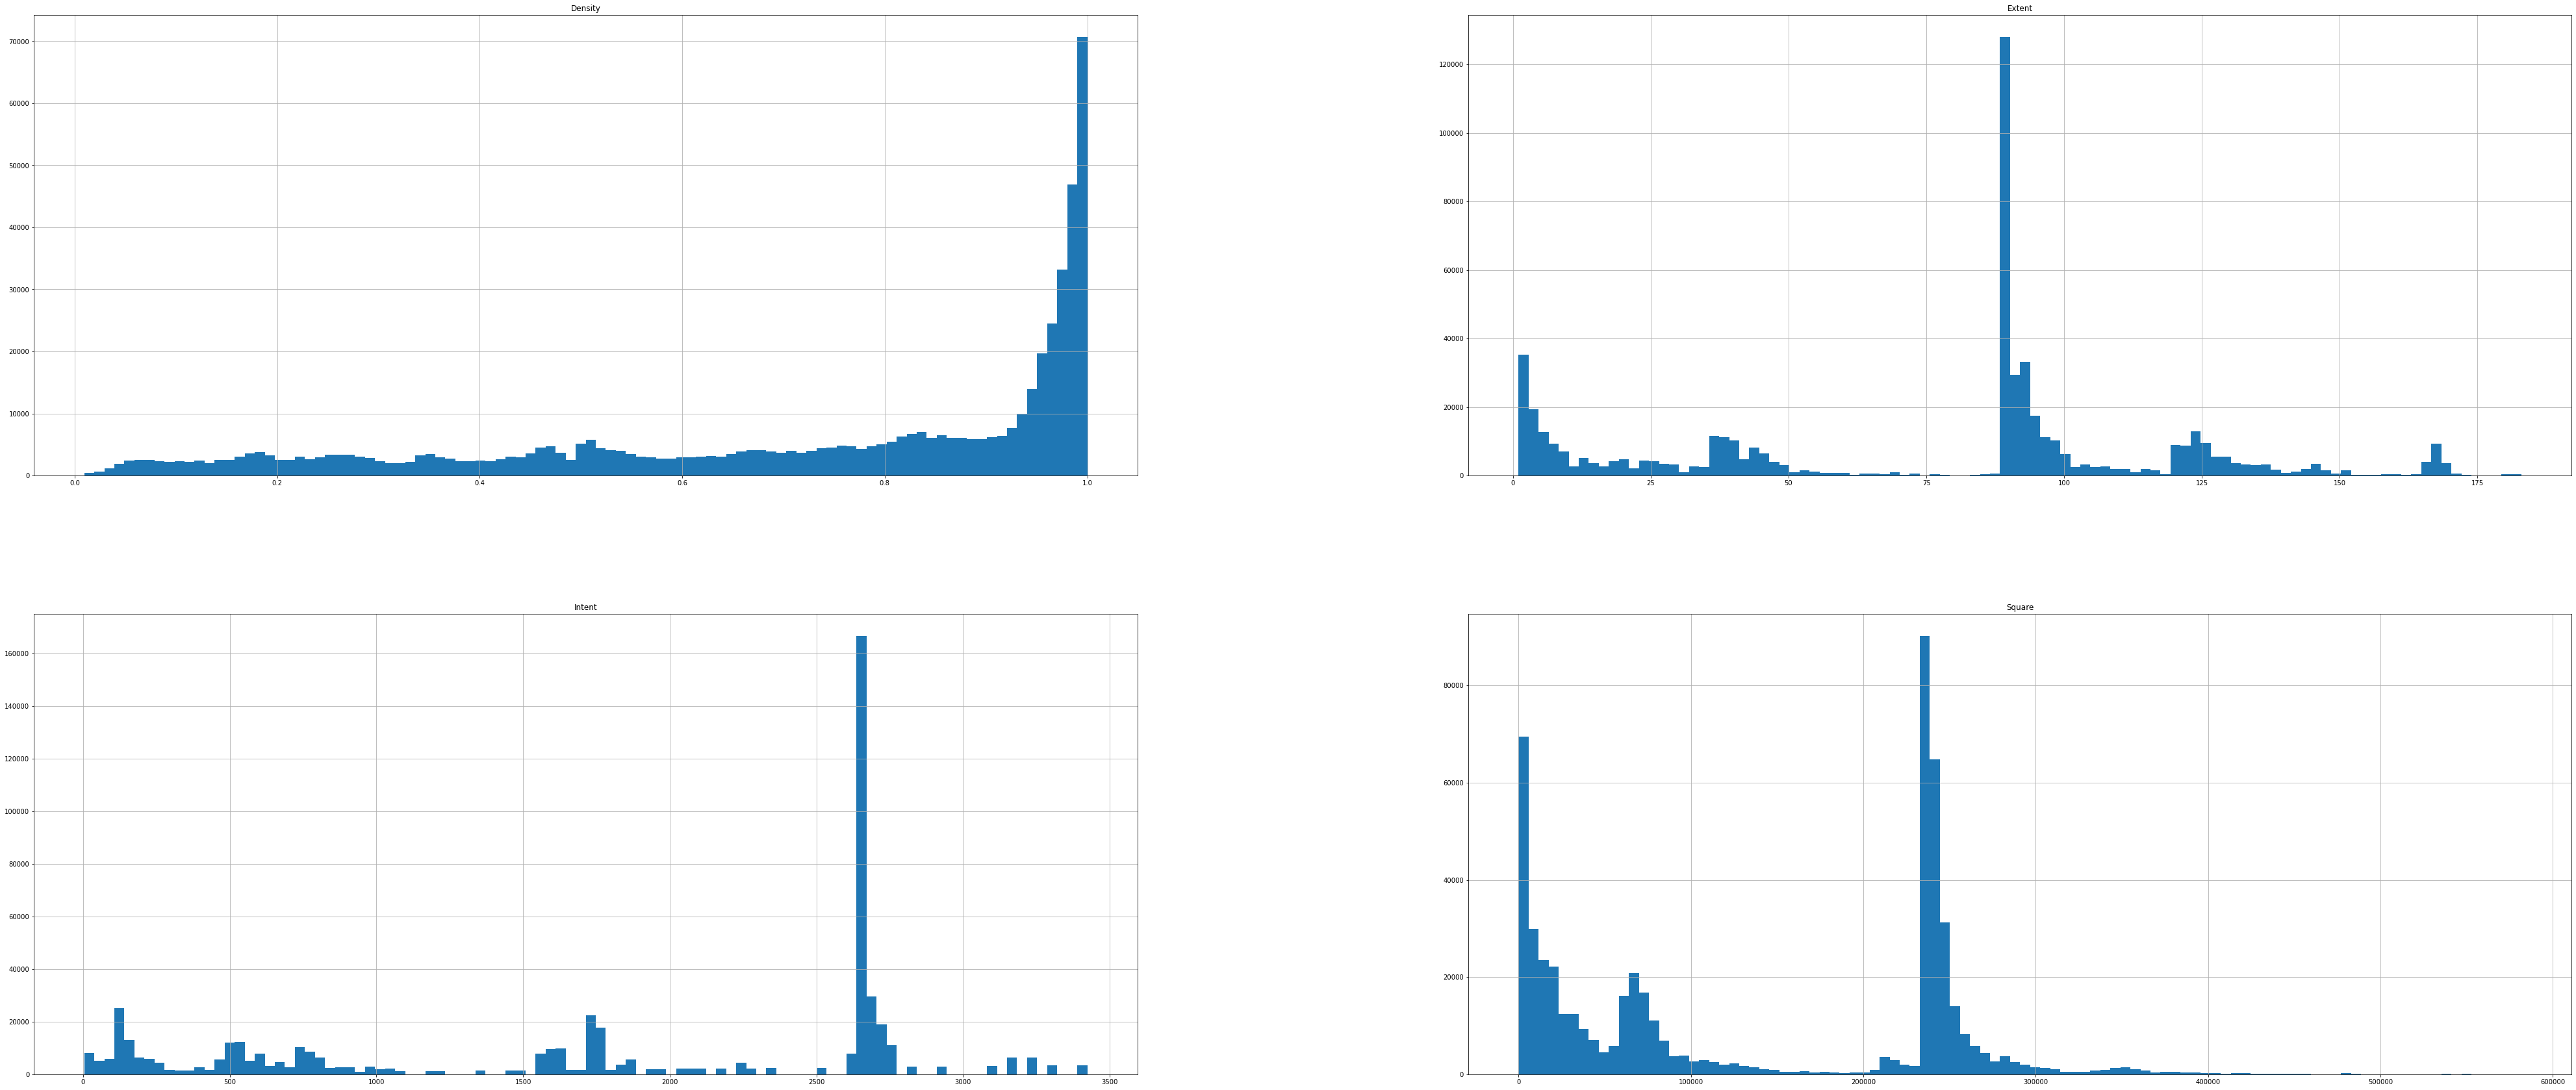

In [159]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (70,30))
ax = fig.gca()

df_Bs.hist(ax = ax, bins=100)

In [160]:
Sel=[]
for triple in range(len(Bicl_stat)):
    if Bicl_stat[triple][0]>=0.90 and Bicl_stat[triple][1]>=3 and Bicl_stat[triple][1]<=1500 and Bicl_stat[triple][2]>=3 and Bicl_stat[triple][2]<=80000:
        Sel.append(Bicl_stat[triple])

In [161]:
len(Sel)

219634

In [162]:
df_Sel=pd.DataFrame(Sel, columns =['Density', 'Extent', 'Intent'])

In [163]:
df_Sel['Square']=df_Sel['Extent']*df_Sel['Intent']

In [164]:
Sel

[[0.9835927375215471, 89, 2679],
 [0.9806517439356368, 89, 2687],
 [0.9888399635590647, 89, 2664],
 [0.9880644318382966, 89, 2666],
 [0.9938859444562221, 89, 2650],
 [0.9948935194814567, 89, 2647],
 [0.9923964674902416, 89, 2654],
 [0.9590316649642492, 89, 2750],
 [0.9920057555174676, 89, 2655],
 [0.9849837236165074, 89, 2675],
 [0.9860391576397767, 89, 2672],
 [0.9832634579909442, 89, 2680],
 [0.9867356815216934, 89, 2670],
 [0.9867525144131634, 89, 2670],
 [0.9852764448328893, 89, 2674],
 [0.9885448067963826, 89, 2665],
 [0.9713222326182176, 89, 2714],
 [0.9731274445149544, 89, 2709],
 [0.9789054543633237, 89, 2692],
 [0.9769742047792372, 89, 2698],
 [0.9956118179308001, 89, 2645],
 [0.991929579550985, 89, 2655],
 [0.9640737012920322, 89, 2735],
 [0.9823249461662854, 89, 2682],
 [0.9855861990693451, 89, 2673],
 [0.9974250936329588, 89, 2640],
 [0.9977647304264894, 89, 2639],
 [0.9660574520032443, 89, 2729],
 [0.9755112733805171, 89, 2702],
 [0.9919253475528471, 89, 2655],
 [0.9710637

/Applications/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<AxesSubplot:title={'center':'Density'}>,
        <AxesSubplot:title={'center':'Extent'}>],
       [<AxesSubplot:title={'center':'Intent'}>,
        <AxesSubplot:title={'center':'Square'}>]], dtype=object)

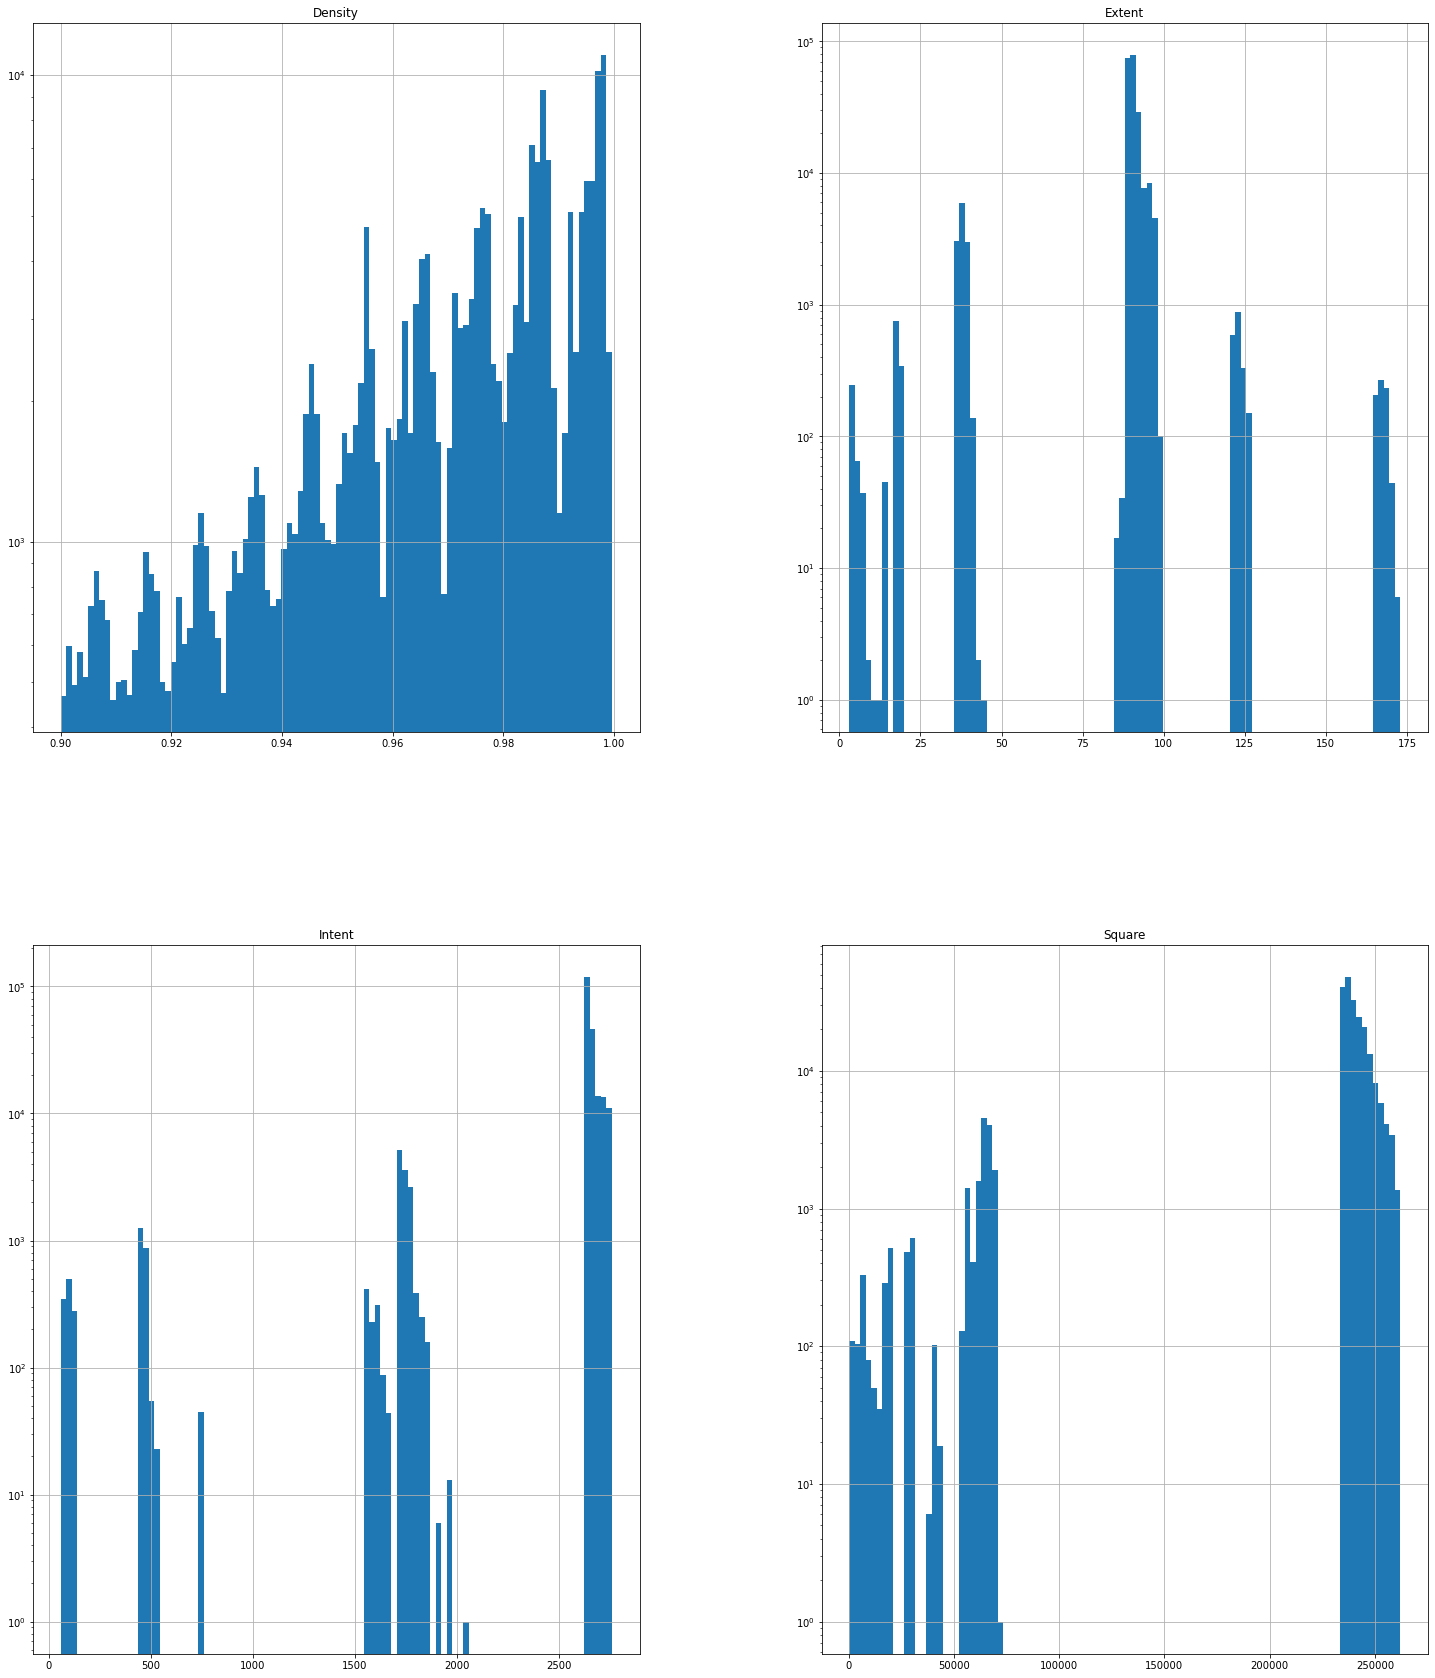

In [165]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (25,30))
ax = fig.gca()

df_Sel.hist(ax = ax, bins=100, log=True)

In [166]:
def Selection(Bicl_stat, density_min, density_max, ext_min, ext_max, int_min, int_max):
    Sel=[]
    for triple in range(len(Bicl_stat)):
        if Bicl_stat[triple][0]>=density_min and Bicl_stat[triple][0]<=density_max and Bicl_stat[triple][1]>=ext_min and Bicl_stat[triple][1]<=ext_max and Bicl_stat[triple][2]>=int_min and Bicl_stat[triple][2]<=int_max:
            Sel.append(Bicl_stat[triple])
    return Sel            

In [214]:
pd.DataFrame(Selection(Bicl_stat,0.9475796930342385,1, 121, 121, 3, 80000), columns =['Density', 'Extent', 'Intent']).describe()

Density  Extent  Intent
count  6.500000e+01    65.0    65.0
mean   9.475797e-01   121.0   455.0
std    1.230749e-15     0.0     0.0
min    9.475797e-01   121.0   455.0
25%    9.475797e-01   121.0   455.0
50%    9.475797e-01   121.0   455.0
75%    9.475797e-01   121.0   455.0
max    9.475797e-01   121.0   455.0

array([[<AxesSubplot:title={'center':'Density'}>,
        <AxesSubplot:title={'center':'Extent'}>],
       [<AxesSubplot:title={'center':'Intent'}>, <AxesSubplot:>]],
      dtype=object)

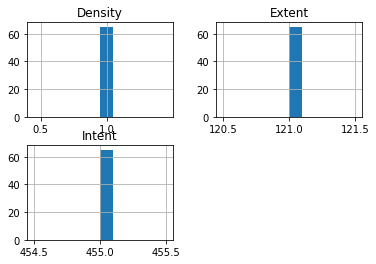

In [213]:
pd.DataFrame(Selection(Bicl_stat,0.9475796930342385,1, 121, 121, 3, 80000), columns =['Density', 'Extent', 'Intent']).hist()

In [215]:
p=pd.DataFrame(Selection(Bicl_stat,0.94757969302,1, 121, 122, 3, 80000), columns =['Density', 'Extent', 'Intent'])

In [216]:
m=max(p["Density"])

In [217]:
m

0.9475796930342385

In [218]:
import powerlaw

In [222]:
fit = powerlaw.Fit(np.array(df_Bs["Density"]))

Calculating best minimal value for power law fit


In [221]:
np.array(df_Bs["Density"])

array([0.98359274, 0.98065174, 0.98883996, ..., 0.98729317, 0.98332075,
       0.05584434])

In [223]:
powerlaw.plot_pdf(np.array(df_Bs["Density"]), color=’b’)

SyntaxError: invalid character in identifier (<ipython-input-223-6761172d2887>, line 1)

In [ ]:
powerlaw.plot_cdf(np.array(df_Bs["Density"]), color=’b’)